# Libraries

In [ ]:
# === Core Python and System Utilities ===
import os                   # File and directory management
import random               # Random number generation
import warnings             # Suppress or handle warnings
import numpy as np          # Numerical operations
import pandas as pd         # Data manipulation
from typing import Callable, Optional  # Type hinting for functions
from collections import defaultdict     # Efficient key-value data structures
from itertools import product           # Cartesian product generator

# === Visualization Libraries ===
import matplotlib.pyplot as plt         # Plotting and charting
import seaborn as sns                   # Statistical data visualization

# === TensorFlow / Keras for Deep Learning ===
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, Bidirectional, Concatenate, LayerNormalization
)                                       # Neural network layers and architecture
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Training callbacks

# === Scikit-learn - Regression Models ===
from sklearn.linear_model import LinearRegression, Ridge               # Linear models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Ensemble methods
from sklearn.tree import DecisionTreeRegressor                         # Tree-based model
from sklearn.svm import SVR                                            # Support Vector Regression
from sklearn.neighbors import KNeighborsRegressor                      # KNN Regression

# === Scikit-learn - Classification Models ===
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier                       # Multi-layer Perceptron

# === Scikit-learn - Preprocessing, Feature Selection, Class Weights ===
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder         # Feature scaling
from sklearn.feature_selection import RFE                              # Recursive Feature Elimination
from sklearn.utils.class_weight import compute_class_weight            # Handle class imbalance

# === Scikit-learn - Model Selection and Cross Validation ===
from sklearn.model_selection import (
    train_test_split,                 # Split dataset
    cross_val_score, cross_validate, # Cross-validation utilities
    KFold, StratifiedKFold,          # Cross-validation strategies
    GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
)

# === Scikit-learn - Evaluation Metrics ===
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,     # Regression metrics
    accuracy_score, f1_score, precision_score, recall_score,  # Classification metrics
    roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve  # ROC & diagnostics
)

# === XGBoost and LightGBM - Gradient Boosting Libraries ===
from xgboost import XGBRegressor, XGBClassifier           # Extreme Gradient Boosting
from lightgbm import LGBMClassifier                       # Light Gradient Boosting Machine

# === SHAP - Explainable AI Toolkit ===
import shap                                               # Model interpretability and feature importance

# Settings

In [ ]:
# Defining a constant seed value
SEED = 42

# Ensures deterministic behavior in hashing operations
os.environ['PYTHONHASHSEED'] = str(SEED)

# Seeding NumPy’s random number generator
np.random.seed(SEED)

# Seeding Python’s built-in random module
random.seed(SEED)

# Seeding TensorFlow’s random number generator
tf.random.set_seed(SEED)

In [ ]:
"""
To configure pandas to display up to 500 rows, 500 columns, and a wider console width, and to suppress warning messages.
"""
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.filterwarnings("ignore")

# Functions

In [ ]:
def load_csv_files(file_names):
    """
    To load specified CSV files and dynamically create DataFrame variables named df_<file_name> in the global scope for each.

    Input
    file_names:
    A list of CSV filenames to load (e.g., ['player.csv', 'team.stats.csv']).

    Steps
    Initialize Dictionary
    Initializes an empty dictionary dataframes = {} to store the loaded DataFrames.

    Loop and Read
    Iterates over each filename in file_names.

    Read with Pandas
    Reads the CSV using pd.read_csv(file).

    Generate Variable Name
    Constructs a variable name string df_<file_name> by removing “.csv” and replacing any “.” with “_”.

    Inject into Globals
    Assigns the DataFrame to the global namespace with globals()[var_name] = df.

    Store in Dictionary
    Stores the DataFrame in the dataframes dictionary keyed by the filename.

    Error Handling
    If reading fails, the exception is caught and an error message is printed.

    Informative Print
    On each successful load, prints the variable name and DataFrame shape to the console.

    Output
    Returns a dictionary (dataframes) mapping filenames to their DataFrames, and creates df_<file_name> variables in the global namespace.
    """
    dataframes = {}

    for file in file_names:
        try:
            df = pd.read_csv(file)
            var_name = f"df_{file.replace('.csv', '').replace('.', '_')}"
            globals()[var_name] = df
            dataframes[file] = df
            print(f"Created variable: {var_name} with shape {df.shape}")
        except Exception as e:
            print(f"Failed to load {file}: {e}")

    return dataframes

In [ ]:
def compute_rolling_win_pct(group, win_flag_col, new_col_name):
"""
Purpose:
For each team group, computes the “last 4 games win percentage” by averaging the win flags over the previous four games.

Input:
group: DataFrame
    A pandas DataFrame containing the game rows for a single team in one context (e.g. home or away, one season).

win_flag_col: str
    The name of the column containing a 0/1 win flag for each game (e.g. 'win_home').

new_col_name: str
    The desired name for the resulting rolling-win-pct Series (e.g. 'rolling_win_pct_home').

Steps:
1. shift(1)
   Shifts the series down by one so that the current game’s flag isn’t included—only prior games are considered.
2. rolling(window=4, min_periods=1)
   Applies a rolling window of size 4; with min_periods=1, averages can be computed even if fewer than four prior games exist.
3. mean()
   Computes the arithmetic mean of the 0/1 flags within each window, yielding a win percentage.
4. rename(new_col_name)
   Renames the resulting Series to the specified new column name.
5. reset_index(drop=True)
   Resets the index so it can be concatenated back to the original DataFrame without mismatched indices.

Output:
pandas.Series
A pandas Series of length equal to the input group, where each element is the win percentage (0–1) over the four games immediately preceding that row’s game.
"""
    return (
        group[win_flag_col]
        .shift(1)
        .rolling(window=4, min_periods=1)
        .mean()
        .rename(new_col_name)
        .reset_index(drop=True)
    )

In [ ]:
def compute_rolling_avg_home(group):
"""
Purpose:
To take game-by-game stats for each home team and compute the average of those stats over the previous four home games.

Input:
group:
    A DataFrame group containing all games in which the team played as the home side.

home_stat_cols:
    List of home-team statistic column names to average (e.g. ['fgm_home', 'pts_home', …]).

Steps:
shift(1)
    Shifts all values down by one row so that the current game’s stats aren’t included—ensuring we only look at prior games.

rolling(window=4, min_periods=1)
    Applies a rolling window of size 4 on the shifted data. min_periods=1 allows averages to be computed even if fewer than four prior games exist.

mean()
    Computes the arithmetic mean of the specified stat columns within each rolling window.

Column Naming:
    Renames the resulting columns to rolling_avg_<original_column_name>.

Concatenation:
    Concatenates the original group DataFrame with the rolling-average columns along the columns axis.

Output:
    A DataFrame in which each home-game row is augmented with new rolling_avg_… columns, showing the averages of the previous four home games up to—but excluding—the current game.
"""

    group = group.copy()
    group['win_home'] = (group['pts_home'] > group['pts_away']).astype(int)

    rolling = group[home_stat_cols].shift(1).rolling(window=4, min_periods=1).mean()
    rolling.columns = [f"rolling_avg_{col}" for col in home_stat_cols]

    rolling_win_pct = compute_rolling_win_pct(group, win_flag_col='win_home', new_col_name='rolling_win_pct_home')

    return pd.concat(
        [
            group.reset_index(drop=True),
            rolling.reset_index(drop=True),
            rolling_win_pct
        ],
        axis=1
    )

In [ ]:
def compute_rolling_avg_away(group):
"""
Purpose:
To take game-by-game stats for each away team and compute the average of those stats over the previous four away games.

Input:
group:
    A DataFrame group containing all games in which the team played as the away side.

away_stat_cols:
    List of away-team statistic column names to average (e.g. ['fgm_away', 'pts_away', …]).

Steps:
shift(1)
    Shifts the data down by one row so that the current away game’s stats are excluded, focusing only on prior away games.

rolling(window=4, min_periods=1)
    Defines a rolling window of size 4; with min_periods=1, averages can be computed even if fewer than four prior away games exist.

mean()
    Computes the mean of the stats over each rolling window of four games.

Column Naming:
    Assigns column names rolling_avg_<original_column_name> to the rolling-average results.

Concatenation:
    Concatenates the original away-game DataFrame with the new rolling-average columns.

Output:
    A DataFrame in which each away-game row is augmented with new rolling_avg_… columns, showing the averages of the previous four away games up to—but excluding—the current game.
"""

    group = group.copy()
    group['win_away'] = (group['pts_away'] > group['pts_home']).astype(int)

    rolling = group[away_stat_cols].shift(1).rolling(window=4, min_periods=1).mean()
    rolling.columns = [f"rolling_avg_{col}" for col in away_stat_cols]

    rolling_win_pct = compute_rolling_win_pct(
        group,
        win_flag_col='win_away',
        new_col_name='rolling_win_pct_away'
    )

    return pd.concat(
        [
            group.reset_index(drop=True),
            rolling.reset_index(drop=True),
            rolling_win_pct
        ],
        axis=1
    )

In [ ]:
def to_minutes_fraction(x):
"""
Purpose:
To convert time values in “MM:SS” format or numeric form into decimal minutes, marking invalid inputs as NA.

Input:
x:
    A time value as an “MM:SS” string or a numeric (float/int).

Steps:
1. Type & Format Check
    If x is a string containing “:”, parse it as MM:SS.
2. Parse MM:SS
    Split the string on “:”, take minutes (m) and seconds (s), then compute int(m) + int(s)/60.
3. Coerce on Error
    If parsing/conversion fails, return pandas NA.
4. Numeric Conversion
    If x is not in “MM:SS” format, attempt float(x); if that fails, return NA.

Output:
    A float representing decimal minutes, or pandas NA for invalid inputs.
"""

    if isinstance(x, str) and ':' in x:
        m, s = x.split(':')
        try:
            return int(m) + int(s)/60
        except:
            return pd.NA
    try:
        return float(x)
    except:
        return pd.NA

In [ ]:
def assign_starters(g):
"""
Purpose:
For each team-game group, separates players by position (G, F, C) and sorts them by personId;
assigns the two smallest guards to starter1/2, the two smallest forwards to starter3/4, and the smallest center to starter5.

Input:
group:
    A DataFrame slice containing all player box-score rows for one team in one game.

Steps:
1. Separate by Position
    Filter the group for position=='G', 'F', and 'C'.
2. Sort & Assign
    Sort each subset by personId ascending and take the first N as starters.
3. Coerce on Missing
    If not enough players, assign pd.NA for that starter slot.

Output:
    A pandas Series with keys starter1_personId … starter5_personId.
"""

    out = {}
    guards   = g[g.position == 'G'].sort_values('personId')
    forwards = g[g.position == 'F'].sort_values('personId')
    centers  = g[g.position == 'C'].sort_values('personId')
    out['starter1_personId'] = guards['personId'].iloc[0] if len(guards) > 0 else pd.NA
    out['starter2_personId'] = guards['personId'].iloc[1] if len(guards) > 1 else pd.NA
    out['starter3_personId'] = forwards['personId'].iloc[0] if len(forwards) > 0 else pd.NA
    out['starter4_personId'] = forwards['personId'].iloc[1] if len(forwards) > 1 else pd.NA
    out['starter5_personId'] = centers['personId'].iloc[0] if len(centers) > 0 else pd.NA
    return pd.Series(out)

In [ ]:
def expected_score(r1, r2):
"""
Purpose:
Calculates the probability of one team winning based on both teams' Elo ratings.

Input:
    r1: Elo rating of team 1
    r2: Elo rating of the opposing team

Steps:
1. Compute a logistic ratio based on the Elo difference.
2. Convert the ratio into a win probability.

Output:
    Win probability for r1 (between 0 and 1).
"""

    return 1 / (1 + 10 ** ((r2 - r1) / 400))

In [ ]:
def k_factor(point_diff, r1, r2):
"""
Purpose:
Generates a dynamic K-factor based on point difference and Elo gap.

Input:
    point_diff: Point difference in the game
    r1: Elo rating of team 1
    r2: Elo rating of team 2

Steps:
1. Compute a multiplier based on score difference.
2. Apply a logistic attenuation based on Elo difference.

Output:
    The K-factor (determines how much Elo is updated).
"""

    return 20 * ((point_diff / 10) + 1) * (1 / (1 + 10 ** (abs(r1 - r2) / 400)))

In [ ]:
def update_elo(r_old, r_opponent, s, point_diff):
"""
Purpose:
Updates the Elo rating based on game outcome and point difference.

Input:
    r_old: Team’s current Elo rating
    r_opponent: Elo of opponent team
    s: Match result (1 = win, 0 = loss)
    point_diff: Point difference in the match

Steps:
1. Compute win expectation using `expected_score`.
2. Calculate K-factor using `k_factor`.
3. New Elo = Old Elo + K × (Actual - Expected)

Output:
    Updated Elo rating (float).
"""

    E = expected_score(r_old, r_opponent)
    K = k_factor(point_diff, r_old, r_opponent)
    return r_old + K * (s - E)

In [ ]:
def get_season_from_date(date):
"""
Purpose:
Returns the NBA season (e.g., '2015-2016') based on the date.

Input:
    date: Match date (datetime)

Steps:
1. Determine start year based on the month.
2. If month is October or later, add +1 to the year for the end year.

Output:
    Season string in format 'YYYY-YYYY'.
"""

    y = date.year
    return f"{y}-{y+1}" if date.month >= 10 else f"{y-1}-{y}"

In [ ]:
def calc_rest_bonus(rest_diff: float) -> int:
"""
Map rest-day difference to an Elo bonus value. REST BONUS MAPPING
"""
    if rest_diff >= 2:
        return 20
    elif rest_diff == 1:
        return 10
    elif rest_diff == 0:
        return 0
    elif rest_diff == -1:
        return -10
    else:  # rest_diff <= -2
        return -20

In [ ]:
def get_season_if_missing(df: pd.DataFrame,
                          get_season_from_date: Optional[Callable] = None) -> pd.DataFrame:
    """
    Ensure df['season'] exists; infer from date or copy from season_id. - SEASON DETECTION HELPER
    """
    if 'season' in df.columns:
        return df
    if get_season_from_date is not None:
        df['season'] = df['game_date'].apply(get_season_from_date)
    elif 'season_id' in df.columns:
        df['season'] = df['season_id']
    else:
        raise ValueError("No 'season' or 'season_id' and no get_season_from_date function provided.")
    return df

In [ ]:
def compute_rest_days(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute rest days for each team-season row using prior game date (shift).
    First game of season gets default neutral rest days.
    Long gaps clipped at MAX_REST_CAP to avoid off-season inflation. - COMPUTE REST DAYS
    """
    # Home & away -> long form
    home_df = df[['game_id', 'season', 'team_id_home', 'game_date']].rename(
        columns={'team_id_home': 'team_id'}
    )
    away_df = df[['game_id', 'season', 'team_id_away', 'game_date']].rename(
        columns={'team_id_away': 'team_id'}
    )
    all_games = pd.concat([home_df, away_df], ignore_index=True)
    all_games = all_games.sort_values(['team_id', 'season', 'game_date', 'game_id']).reset_index(drop=True)

    # previous game within SAME SEASON ONLY (leakage safe; off-season ignored)
    all_games['prev_game_date'] = all_games.groupby(['team_id', 'season'])['game_date'].shift(1)

    # rest_days = days between current and previous game
    all_games['rest_days'] = (all_games['game_date'] - all_games['prev_game_date']).dt.days

    # season first games -> fill neutral
    all_games['rest_days'] = all_games['rest_days'].fillna(DEFAULT_SEASON_START_REST_DAYS)

    # clip extreme values
    all_games['rest_days'] = all_games['rest_days'].clip(upper=MAX_REST_CAP)

    # keep necessary columns
    rest_data = all_games[['team_id', 'season', 'game_date', 'rest_days']]
    return rest_data

In [ ]:
def expected_score(r_a: float, r_b: float) -> float:
    """
        Calculates the expected score for player/team A against player/team B based on their Elo ratings.
        This is a probability value between 0 and 1 that reflects the likelihood of A winning
        against B. Commonly used in Elo-based rating systems.
    """
    return 1.0 / (1.0 + 10 ** ((r_b - r_a) / 400.0))

In [ ]:
INITIAL_ELO = 1500
HOME_ADVANTAGE = 65                # Fixed home-court advantage
SEASON_CARRYOVER_RATIO = 0.75      # Percentage of rating retained between seasons
K = 20                             # Elo update rate (K-factor)

# Default assumptions and constraints for rest day integration
DEFAULT_SEASON_START_REST_DAYS = 3   # Neutral assumption for a team's first game of the season
MAX_REST_CAP = 8                     # Normalize excessively long breaks (prevent off-season inflation)

def update_elo_simple(r_a: float, r_b: float, score_a: float, k: float = K) -> float:
    """
    Updates the Elo rating of player/team A using a simple formula based on match outcome.
    This function is designed for binary results: a win (1) or a loss (0), no draws.

    Parameters:
    - r_a: Current Elo rating of player/team A
    - r_b: Current Elo rating of player/team B
    - score_a: Match outcome for A (1 = win, 0 = loss)
    - k: K-factor determining sensitivity of Elo adjustment (default: K)

    Returns:
    - Updated Elo rating for A (float)
    """
    exp_a = expected_score(r_a, r_b)
    return r_a + k * (score_a - exp_a)

In [ ]:
def build_rest_adjusted_elo(
    final_df: pd.DataFrame,
    get_season_from_date: Optional[Callable] = None,
    *,
    initial_elo: int = INITIAL_ELO,
    home_advantage: int = HOME_ADVANTAGE,
    season_carryover_ratio: float = SEASON_CARRYOVER_RATIO,
    k_factor: float = K
) -> pd.DataFrame:
    """
    Builds a rest-adjusted Elo rating system from game data, incorporating rest days
    and home court advantage. The steps include:

    1) Chronological sorting of matches.
    2) Ensuring or deriving season labels.
    3) Calculating rest days for each team (home and away).
    4) Generating a rest bonus based on rest day differences.
    5) Elo updates with home advantage and rest bonus integrated.
       Elo updates are applied only when the outcome is known to avoid data leakage.
    6) Computes effective Elo difference and win probability for the home team.

    Parameters:
    - final_df: Input DataFrame with game information
    - get_season_from_date: Optional function to derive season from date
    - initial_elo: Starting Elo rating for all teams
    - home_advantage: Elo points added to home team rating
    - season_carryover_ratio: Fraction of rating retained between seasons
    - k_factor: Elo learning rate (update sensitivity)

    Returns:
    - DataFrame with rest-aware Elo ratings and win probabilities
    """

    # ------------------------------------------------------------------
    # Copy & date parse
    # ------------------------------------------------------------------
    df = final_df.copy()
    df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')
    df = df.sort_values('game_date').reset_index(drop=True)

    # ------------------------------------------------------------------
    # Ensure season column
    # ------------------------------------------------------------------
    df = get_season_if_missing(df, get_season_from_date)

    # ------------------------------------------------------------------
    # Compute rest days & merge (home + away)
    # ------------------------------------------------------------------
    rest_data = compute_rest_days(df)

    # home merge
    df = df.merge(
        rest_data.rename(columns={'team_id': 'team_id_home', 'rest_days': 'rest_days_home'}),
        on=['team_id_home', 'season', 'game_date'],
        how='left'
    )

    # away merge
    df = df.merge(
        rest_data.rename(columns={'team_id': 'team_id_away', 'rest_days': 'rest_days_away'}),
        on=['team_id_away', 'season', 'game_date'],
        how='left'
    )

    # ------------------------------------------------------------------
    # Rest diff & bonus
    # ------------------------------------------------------------------
    df['rest_diff'] = df['rest_days_home'] - df['rest_days_away']
    df['rest_bonus'] = df['rest_diff'].apply(calc_rest_bonus)

    # ------------------------------------------------------------------
    # REST-ADJUSTED ELO LOOP
    # ------------------------------------------------------------------
    team_elos = defaultdict(lambda: initial_elo)
    elo_home_rest_list = []
    elo_away_rest_list = []

    # start season
    current_season = df.loc[0, 'season']

    for _, row in df.iterrows():
        game_season = row['season']

        # season transition (carryover)
        if game_season != current_season:
            for team in team_elos:
                team_elos[team] = (
                    season_carryover_ratio * team_elos[team] +
                    (1 - season_carryover_ratio) * initial_elo
                )
            current_season = game_season

        home = row['team_id_home']
        away = row['team_id_away']

        # init
        team_elos.setdefault(home, initial_elo)
        team_elos.setdefault(away, initial_elo)

        r_home = team_elos[home]
        r_away = team_elos[away]

        # record pre-game neutral ratings
        elo_home_rest_list.append(r_home)
        elo_away_rest_list.append(r_away)

        # update only if outcome known (no future info)
        if pd.notna(row['wl_home']):
            s_home = float(row['wl_home'])
            s_away = 1.0 - s_home

            # effective rating includes home_adv + rest_bonus
            rest_bonus = row['rest_bonus'] if pd.notna(row['rest_bonus']) else 0
            r_home_eff = r_home + home_advantage + rest_bonus

            # update via effective ratings
            new_r_home_eff = update_elo_simple(r_home_eff, r_away, s_home, k=k_factor)
            new_r_away = update_elo_simple(r_away, r_home_eff, s_away, k=k_factor)

            # delta -> convert back to neutral
            delta_home = new_r_home_eff - r_home_eff
            team_elos[home] = r_home + delta_home
            team_elos[away] = new_r_away  # already neutral (opponent rating was r_home_eff, OK)

    # attach columns
    df['elo_home_rest'] = elo_home_rest_list
    df['elo_away_rest'] = elo_away_rest_list
    df['elo_diff_rest'] = df['elo_home_rest'] - df['elo_away_rest']

    # ------------------------------------------------------------------
    # EFFECTIVE MATCH-DAY ELO DIFF & PROBABILITY
    # ------------------------------------------------------------------
    df['effective_elo_diff'] = df['elo_diff_rest'] + home_advantage + df['rest_bonus']
    df['p_home_win'] = 1.0 / (1.0 + 10 ** (-df['effective_elo_diff'] / 400.0))

    return df

In [ ]:
def get_season_phase(date: pd.Timestamp) -> str:
    """
    Season phase tags (example for 2019-20 COVID season).
    """
    if pd.Timestamp("2019-10-22") <= date <= pd.Timestamp("2020-03-11"):
        return "regular_pre_covid"
    elif pd.Timestamp("2020-07-30") <= date <= pd.Timestamp("2020-08-14"):
        return "regular_bubble"
    elif pd.Timestamp("2020-03-12") <= date <= pd.Timestamp("2020-07-29"):
        return "suspended"
    else:
        return "other"

In [ ]:
def get_metric_name(col, pos):
    """
    Extracts the base metric name from a column that follows the pattern '{metric}_{position}_diff'.

    Parameters:
    - col (str): Full column name (e.g., 'points_guard_diff')
    - pos (str): Position string to remove (e.g., 'guard' or 'forward')

    Returns:
    - str: Base metric name without position and suffix (e.g., 'points')
    """

    return col.replace(f"_{pos}_diff", '')

In [ ]:
def scale_dataset(X_data):
    """
        Scales numeric columns using a previously fitted StandardScaler,
        and then concatenates the unscaled categorical columns (if any) back into the dataset.
        This ensures that only the numeric features are standardized,
        while preserving categorical features for downstream use.

        Parameters:
        - X_data (pd.DataFrame): Input dataset with numeric and possibly categorical columns

        Returns:
        - pd.DataFrame: Scaled numeric features + original categorical features (if any)
    """
    # Scale numeric columns
    X_num = pd.DataFrame(
        scaler.transform(X_data[numeric_cols]),
        columns=numeric_cols,
        index=X_data.index
    )

    # Append categorical columns (if present)
    if categorical_cols:
        X_cat = X_data[categorical_cols].reset_index(drop=True)
        return pd.concat([X_num.reset_index(drop=True), X_cat], axis=1)
    else:
        return X_num.reset_index(drop=True)

In [ ]:
def eval_clf(model, X, y, threshold=0.5):
    """
    Computes key classification metrics at a given threshold using predicted probabilities.
    Returns a dictionary containing Accuracy, Precision, Recall, F1 Score, ROC AUC, and Log Loss.
    Also returns predicted probabilities and binary predictions.

    Parameters:
    - model: Trained classification model (must support predict_proba)
    - X (pd.DataFrame or np.array): Feature set
    - y (array-like): True labels
    - threshold (float): Decision threshold to classify probabilities (default = 0.5)

    Returns:
    - dict: {
        "Accuracy": ...,
        "Precision": ...,
        "Recall": ...,
        "F1": ...,
        "ROC_AUC": ...,
        "LogLoss": ...,
        "y_prob": ...,
        "y_pred": ...
      }
    """
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1": f1_score(y, y_pred),
        "ROC_AUC": roc_auc_score(y, y_prob),
        "LogLoss": log_loss(y, y_prob),
        "y_prob": y_prob,
        "y_pred": y_pred
    }

# Gathering the Data

In [ ]:
"""
To load multiple CSV files, create DataFrame variables named df_<file_name> in the global scope for each, and return a dictionary mapping filenames to DataFrames.
"""

file_names = [
    'common_player_info.csv',
    'draft_combine_stats.csv',
    'draft_history.csv',
    'game_info.csv',
    'game_summary.csv',
    'game.csv',
    'inactive_players.csv',
    'line_score.csv',
    'officials.csv',
    'other_stats.csv',
    'player.csv',
    'regular_season_box_scores_2010_2024_part_1.csv',
    'regular_season_box_scores_2010_2024_part_2.csv',
    'regular_season_box_scores_2010_2024_part_3.csv',
    'regular_season_totals_2010_2024.csv',
    'team_details.csv',
    'team_history.csv',
    'team.csv'
]

dfs = load_csv_files(file_names)

Created variable: df_common_player_info with shape (4171, 33)
Created variable: df_draft_combine_stats with shape (1202, 47)
Created variable: df_draft_history with shape (7990, 14)
Created variable: df_game_info with shape (58053, 4)
Created variable: df_game_summary with shape (58110, 14)
Created variable: df_game with shape (65698, 55)
Created variable: df_inactive_players with shape (110191, 9)
Created variable: df_line_score with shape (58053, 43)
Created variable: df_officials with shape (70971, 5)
Created variable: df_other_stats with shape (28271, 26)
Created variable: df_player with shape (4831, 5)
Created variable: df_regular_season_box_scores_2010_2024_part_1 with shape (141493, 34)
Created variable: df_regular_season_box_scores_2010_2024_part_2 with shape (141493, 34)
Created variable: df_regular_season_box_scores_2010_2024_part_3 with shape (141492, 34)
Created variable: df_regular_season_totals_2010_2024 with shape (33316, 57)
Created variable: df_team_details with shape 

In [ ]:
"""
To vertically merge three separate DataFrames of regular-season box‐score data (from 2010 to 2024) into a single comprehensive DataFrame.
"""
df_box_scores = pd.concat(
    [
        df_regular_season_box_scores_2010_2024_part_1,
        df_regular_season_box_scores_2010_2024_part_2,
        df_regular_season_box_scores_2010_2024_part_3
    ],
    axis=0,
    ignore_index=True
)
display(df_box_scores.head())

,season_year,game_date,gameId,matchup,teamId,teamCity,teamName,teamTricode,teamSlug,personId,personName,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
0,2010-11,2010-11-10,21000112,NJN @ CLE,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,NaN,NaN,NaN,4:21,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,-4
1,2010-11,2010-11-17,21000165,NJN @ UTA,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,NaN,DNP - Coach's Decision,NaN,NaN,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
2,2010-11,2010-11-27,21000237,NJN @ PHI,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,NaN,DNP - Coach's Decision,NaN,NaN,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
3,2010-11,2010-12-12,21000351,NJN vs. LAL,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,NaN,DNP - Coach's Decision,NaN,NaN,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
4,2010-11,2010-10-29,21000020,NJN vs. SAC,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,9:53,1,1,1.0,0,0,0.0,0,0,0.0,0,1,1,1,0,0,1,1,2,6


# Generating Final Data

## df_game --> final_games Analysis

* **season\_id**
  Unique identifier for the season in which the games were played.

* **team\_id\_home / team\_id\_away**
  Unique league identifier for the home / away team.

* **team\_abbreviation\_home / team\_abbreviation\_away**
  Common 3- or 4-letter abbreviation for the home / away team (e.g., “LAL”).

* **team\_name\_home / team\_name\_away**
  Full name of the home / away team.

* **game\_id**
  Unique identifier for each game record.

* **game\_date**
  Date the game was played (in YYYY-MM-DD format).

* **matchup\_home / matchup\_away**
  Game matchup string from the home / away perspective (e.g., “LAL vs BOS” or “@ BOS”).

* **wl\_home / wl\_away**
  Result for the home / away team: “W” (win) or “L” (loss).

* **min**
  Total minutes the team spent on court in the game.

* **fgm\_home / fga\_home / fg\_pct\_home**
  Home team’s field goals made (FGM), field goals attempted (FGA), and field goal percentage.

* **fgm\_away / fga\_away / fg\_pct\_away**
  Same metrics for the away team.

* **fg3m\_home / fg3a\_home / fg3\_pct\_home**
  Home team’s three-point field goals made (3PM), three-point attempts (3PA), and three-point percentage.

* **fg3m\_away / fg3a\_away / fg3\_pct\_away**
  Three-point shooting metrics for the away team.

* **ftm\_home / fta\_home / ft\_pct\_home**
  Home team’s free throws made (FTM), free throws attempted (FTA), and free throw percentage.

* **ftm\_away / fta\_away / ft\_pct\_away**
  Free throw metrics for the away team.

* **oreb\_home / dreb\_home / reb\_home**
  Home team’s offensive rebounds (OREB), defensive rebounds (DREB), and total rebounds (REB).

* **oreb\_away / dreb\_away / reb\_away**
  Rebounding stats for the away team.

* **ast\_home / stl\_home / blk\_home**
  Home team’s assists (AST), steals (STL), and blocks (BLK).

* **ast\_away / stl\_away / blk\_away**
  Same playmaking and defensive stats for the away team.

* **tov\_home / pf\_home**
  Home team’s turnovers (TOV) and personal fouls (PF).

* **tov\_away / pf\_away**
  Turnovers and fouls for the away team.

* **pts\_home / pts\_away**
  Total points scored by the home / away team.

* **plus\_minus\_home / plus\_minus\_away**
  Team’s plus/minus differential impact over the course of the game.

* **video\_available\_home / video\_available\_away**
  Indicates whether highlight video is available for the home / away team (True/False).

* **season\_type**
  Type of season: e.g., “Regular Season” or “Playoffs.”

In [ ]:
"""
To assign a direct copy of the df_game DataFrame to df and display the first 5 rows of this copy using df.head().
"""
df = df_game.copy()
display(df.head())

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
0,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01 00:00:00,HUS vs. NYK,L,0,25.0,NaN,NaN,NaN,NaN,NaN,16.0,29.0,0.552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,-2,0,1610612752,NYK,New York Knicks,NYK @ HUS,W,24.0,NaN,NaN,NaN,NaN,NaN,20.0,26.0,0.769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,2,0,Regular Season
1,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02 00:00:00,BOM vs. PIT,W,0,20.0,59.0,0.339,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,56.0,5,0,1610610031,PIT,Pittsburgh Ironmen,PIT @ BOM,L,16.0,72.0,0.222,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,51.0,-5,0,Regular Season
2,21946,1610610032,PRO,Providence Steamrollers,24600002,1946-11-02 00:00:00,PRO vs. BOS,W,0,21.0,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,6,0,1610612738,BOS,Boston Celtics,BOS @ PRO,L,21.0,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0,-6,0,Regular Season
3,21946,1610610025,CHS,Chicago Stags,24600004,1946-11-02 00:00:00,CHS vs. NYK,W,0,21.0,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,63.0,16,0,1610612752,NYK,New York Knicks,NYK @ CHS,L,16.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,47.0,-16,0,Regular Season
4,21946,1610610028,DEF,Detroit Falcons,24600005,1946-11-02 00:00:00,DEF vs. WAS,L,0,10.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,-17,0,1610610036,WAS,Washington Capitols,WAS @ DEF,W,18.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,17,0,Regular Season


In [ ]:
"""
To compute 4-game rolling averages of home-team stats by sorting, grouping (by team, season, and season type), applying compute_rolling_avg_home, and then filtering for regular-season data from 2010 onward.
"""
home_stat_cols = [
    'fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home',
    'oreb_home', 'dreb_home', 'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home', 'pts_home', 'plus_minus_home'
]


df_sorted_home = df.sort_values(by=["team_id_home", "season_id", "season_type", "game_date"]).copy()
df_result_home = (
    df_sorted_home
    .groupby(['team_id_home', 'season_id', 'season_type'], group_keys=False)
    .apply(compute_rolling_avg_home)
    .reset_index(drop=True)
)
filtered_result_home = df_result_home[(df_result_home['season_id'] >= 22010)  & (df_result_home['season_type'] == 'Regular Season')]
display(filtered_result_home.head())

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type,win_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home
3363,22010,1610612737,ATL,Atlanta Hawks,21000031,2010-10-30 00:00:00,ATL vs. WAS,W,240,34.0,81.0,0.420,5.0,19.0,0.263,26.0,30.0,0.867,13.0,30.0,43.0,19.0,4.0,4.0,17.0,22.0,99.0,4,0,1610612764,WAS,Washington Wizards,WAS @ ATL,L,38.0,76.0,0.500,4.0,12.0,0.333,15.0,21.0,0.714,8.0,26.0,34.0,16.0,8.0,13.0,18.0,25.0,95.0,-4,0,Regular Season,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3364,22010,1610612737,ATL,Atlanta Hawks,21000054,2010-11-03 00:00:00,ATL vs. DET,W,240,36.0,67.0,0.537,3.0,14.0,0.214,19.0,23.0,0.826,3.0,32.0,35.0,25.0,3.0,3.0,14.0,13.0,94.0,9,0,1610612765,DET,Detroit Pistons,DET @ ATL,L,36.0,90.0,0.400,3.0,17.0,0.176,10.0,15.0,0.667,17.0,21.0,38.0,21.0,7.0,2.0,8.0,21.0,85.0,-9,0,Regular Season,1,34.000000,81.0,0.420000,5.0,19.000000,0.263000,26.000000,30.0,0.86700,13.000000,30.000000,43.000000,19.000000,4.000000,4.000000,17.0,22.00,99.000000,4.0,1.000000
3365,22010,1610612737,ATL,Atlanta Hawks,21000090,2010-11-07 00:00:00,ATL vs. PHX,L,240,45.0,83.0,0.542,7.0,23.0,0.304,17.0,22.0,0.773,13.0,27.0,40.0,29.0,6.0,4.0,14.0,22.0,114.0,-4,0,1610612756,PHX,Phoenix Suns,PHX @ ATL,W,45.0,81.0,0.556,11.0,23.0,0.478,17.0,22.0,0.773,11.0,24.0,35.0,28.0,7.0,1.0,15.0,20.0,118.0,4,0,Regular Season,0,35.000000,74.0,0.478500,4.0,16.500000,0.238500,22.500000,26.5,0.84650,8.000000,31.000000,39.000000,22.000000,3.500000,3.500000,15.5,17.50,96.500000,6.5,1.000000
3366,22010,1610612737,ATL,Atlanta Hawks,21000108,2010-11-10 00:00:00,ATL vs. MIL,L,240,36.0,73.0,0.493,5.0,13.0,0.385,14.0,21.0,0.667,7.0,25.0,32.0,24.0,3.0,3.0,17.0,16.0,91.0,-17,0,1610612749,MIL,Milwaukee Bucks,MIL @ ATL,W,45.0,87.0,0.517,8.0,15.0,0.533,10.0,14.0,0.714,11.0,33.0,44.0,23.0,11.0,3.0,13.0,16.0,108.0,17,0,Regular Season,0,38.333333,77.0,0.499667,5.0,18.666667,0.260333,20.666667,25.0,0.82200,9.666667,29.666667,39.333333,24.333333,4.333333,3.666667,15.0,19.00,102.333333,3.0,0.666667
3367,22010,1610612737,ATL,Atlanta Hawks,21000121,2010-11-12 00:00:00,ATL vs. UTA,L,240,35.0,71.0,0.493,5.0,19.0,0.263,11.0,21.0,0.524,11.0,30.0,41.0,23.0,5.0,5.0,16.0,22.0,86.0,-4,0,1610612762,UTA,Utah Jazz,UTA @ ATL,W,36.0,84.0,0.429,4.0,12.0,0.333,14.0,19.0,0.737,15.0,28.0,43.0,25.0,7.0,3.0,9.0,18.0,90.0,4,0,Regular Season,0,37.750000,76.0,0.498000,5.0,17.250000,0.291500,19.000000,24.0,0.78325,9.000000,28.500000,37.500000,24.250000,4.000000,3.500000,15.5,18.25,99.500000,-2.0,0.500000


In [ ]:
"""
To compute 4-game rolling averages of away-team stats by sorting, grouping (by team, season, and season type), applying compute_rolling_avg_away, and then filtering for regular-season data from 2010 onward.
"""
away_stat_cols = [
    'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away', 'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away',
    'oreb_away', 'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away', 'pf_away', 'pts_away', 'plus_minus_away'
]

df_sorted_away = df.sort_values(by=["team_id_away", "season_id", "season_type", "game_date"]).copy()
df_result_away = (
    df_sorted_away
    .groupby(['team_id_away', 'season_id', 'season_type'], group_keys=False)
    .apply(compute_rolling_avg_away)
    .reset_index(drop=True)
)
filtered_result_away = df_result_away[(df_result_away['season_id'] >= 22010) & (df_result_away['season_type'] == 'Regular Season')]
display(filtered_result_away.head())

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type,win_away,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away
3458,22010,1610612763,MEM,Memphis Grizzlies,21000008,2010-10-27 00:00:00,MEM vs. ATL,L,240,40.0,86.0,0.465,4.0,9.0,0.444,20.0,25.0,0.800,9.0,30.0,39.0,13.0,7.0,4.0,14.0,26.0,104.0,-15,0,1610612737,ATL,Atlanta Hawks,ATL @ MEM,W,42.0,80.0,0.525,8.0,16.0,0.500,27.0,31.0,0.871,9.0,35.0,44.0,20.0,7.0,9.0,15.0,20.0,119.0,15,0,Regular Season,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3459,22010,1610612755,PHI,Philadelphia 76ers,21000021,2010-10-29 00:00:00,PHI vs. ATL,L,240,35.0,85.0,0.412,5.0,11.0,0.455,26.0,33.0,0.788,12.0,24.0,36.0,24.0,9.0,6.0,9.0,21.0,101.0,-3,0,1610612737,ATL,Atlanta Hawks,ATL @ PHI,W,36.0,70.0,0.514,6.0,17.0,0.353,26.0,31.0,0.839,10.0,36.0,46.0,24.0,3.0,8.0,20.0,26.0,104.0,3,0,Regular Season,1,42.000000,80.00,0.5250,8.000000,16.000000,0.500000,27.000000,31.000000,0.871000,9.00,35.000000,44.000000,20.000000,7.000000,9.0,15.00,20.0,119.000000,15.0,1.0
3460,22010,1610612739,CLE,Cleveland Cavaliers,21000047,2010-11-02 00:00:00,CLE vs. ATL,L,240,32.0,74.0,0.432,5.0,17.0,0.294,19.0,26.0,0.731,10.0,34.0,44.0,15.0,2.0,4.0,14.0,22.0,88.0,-12,0,1610612737,ATL,Atlanta Hawks,ATL @ CLE,W,37.0,84.0,0.440,5.0,17.0,0.294,21.0,30.0,0.700,14.0,29.0,43.0,26.0,7.0,7.0,7.0,17.0,100.0,12,0,Regular Season,1,39.000000,75.00,0.5195,7.000000,16.500000,0.426500,26.500000,31.000000,0.855000,9.50,35.500000,45.000000,22.000000,5.000000,8.5,17.50,23.0,111.500000,9.0,1.0
3461,22010,1610612750,MIN,Minnesota Timberwolves,21000074,2010-11-05 00:00:00,MIN vs. ATL,L,240,42.0,99.0,0.424,8.0,22.0,0.364,11.0,12.0,0.917,16.0,26.0,42.0,24.0,8.0,8.0,11.0,22.0,103.0,-10,0,1610612737,ATL,Atlanta Hawks,ATL @ MIN,W,44.0,81.0,0.543,4.0,18.0,0.222,21.0,26.0,0.808,8.0,35.0,43.0,27.0,5.0,8.0,15.0,15.0,113.0,10,0,Regular Season,1,38.333333,78.00,0.4930,6.333333,16.666667,0.382333,24.666667,30.666667,0.803333,11.00,33.333333,44.333333,23.333333,5.666667,8.0,14.00,21.0,107.666667,10.0,1.0
3462,22010,1610612753,ORL,Orlando Magic,21000096,2010-11-08 00:00:00,ORL vs. ATL,W,240,37.0,86.0,0.430,4.0,22.0,0.182,15.0,24.0,0.625,11.0,32.0,43.0,16.0,9.0,2.0,10.0,18.0,93.0,4,0,1610612737,ATL,Atlanta Hawks,ATL @ ORL,L,36.0,76.0,0.474,4.0,13.0,0.308,13.0,16.0,0.813,9.0,37.0,46.0,18.0,6.0,3.0,17.0,24.0,89.0,-4,0,Regular Season,0,39.750000,78.75,0.5055,5.750000,17.000000,0.342250,23.750000,29.500000,0.804500,10.25,33.750000,44.000000,24.250000,5.500000,8.0,14.25,19.5,109.000000,10.0,1.0


In [ ]:
"""
To filter df_game for regular-season games from 2010 onward and create a new DataFrame (selected_columns_games) containing key game information columns.
"""
filtered_df = df_game[(df_game['season_id'] >= 22010) & (df_game['season_type'] == 'Regular Season')]
selected_columns_games = filtered_df[['season_id', 'game_id', 'game_date',
                                      'team_id_home', 'team_name_home', 'team_id_away', 'team_name_away', 'wl_home']]
display(selected_columns_games.head())

,season_id,game_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home
49418,22010,21000003,2010-10-26 00:00:00,1610612747,Los Angeles Lakers,1610612745,Houston Rockets,W
49419,22010,21000002,2010-10-26 00:00:00,1610612757,Portland Trail Blazers,1610612756,Phoenix Suns,W
49420,22010,21000001,2010-10-26 00:00:00,1610612738,Boston Celtics,1610612748,Miami Heat,W
49421,22010,21000015,2010-10-27 00:00:00,1610612744,Golden State Warriors,1610612745,Houston Rockets,W
49422,22010,21000010,2010-10-27 00:00:00,1610612740,New Orleans Hornets,1610612749,Milwaukee Bucks,W


In [ ]:
"""
To select only the game_id and rolling-average columns for home and away teams, merge them together on game_id, and then inner-join with the core game information (selected_columns_games) to produce a unified DataFrame.
"""
rolling_home = df_result_home[
    ['game_id'] + [col for col in df_result_home.columns if col.startswith("rolling_") and "_home" in col]
]

rolling_away = df_result_away[
    ['game_id'] + [col for col in df_result_away.columns if col.startswith("rolling_") and "_away" in col]
]

rolling_combined = pd.merge(rolling_home, rolling_away, on='game_id', how='inner')
rolling_games = pd.merge(selected_columns_games, rolling_combined, on='game_id', how='inner')
display(rolling_games.head())

,season_id,game_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away
0,22010,21000003,2010-10-26 00:00:00,1610612747,Los Angeles Lakers,1610612745,Houston Rockets,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22010,21000002,2010-10-26 00:00:00,1610612757,Portland Trail Blazers,1610612756,Phoenix Suns,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22010,21000001,2010-10-26 00:00:00,1610612738,Boston Celtics,1610612748,Miami Heat,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22010,21000015,2010-10-27 00:00:00,1610612744,Golden State Warriors,1610612745,Houston Rockets,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,91.0,0.418,8.0,20.0,0.4,26.0,28.0,0.929,16.0,37.0,53.0,25.0,6.0,7.0,21.0,25.0,110.0,-2.0,0.0
4,22010,21000010,2010-10-27 00:00:00,1610612740,New Orleans Hornets,1610612749,Milwaukee Bucks,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""
To create a copy of the rolling_games DataFrame and convert the wl_home column values from ‘W’/‘L’ to 1/0.
"""
final_games = rolling_games.copy()
final_games['wl_home'] = final_games['wl_home'].map({'W': 1, 'L': 0})
display(final_games.head())

,season_id,game_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away
0,22010,21000003,2010-10-26 00:00:00,1610612747,Los Angeles Lakers,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22010,21000002,2010-10-26 00:00:00,1610612757,Portland Trail Blazers,1610612756,Phoenix Suns,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22010,21000001,2010-10-26 00:00:00,1610612738,Boston Celtics,1610612748,Miami Heat,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22010,21000015,2010-10-27 00:00:00,1610612744,Golden State Warriors,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,91.0,0.418,8.0,20.0,0.4,26.0,28.0,0.929,16.0,37.0,53.0,25.0,6.0,7.0,21.0,25.0,110.0,-2.0,0.0
4,22010,21000010,2010-10-27 00:00:00,1610612740,New Orleans Hornets,1610612749,Milwaukee Bucks,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""
Null Ratio
This snippet computes the number of rows in the final_games DataFrame that have no null values
    across any column, prints that count, and then subtracts it from the total row count (14199)
    to display the number of rows containing nulls. It thus reveals the proportion of incomplete
    rows (about 3.2%) in your dataset.
"""
num_complete_rows = final_games[final_games.notnull().all(axis=1)].shape[0]
print(f"Rows with Non-Null value: {num_complete_rows}")
print(f"Rows with Null value: {14199-13742}") # %3.2

Rows with Non-Null value: 13742
Rows with Null value: 457


## df_team --> df_games_teams Analysis

* **id**
  A unique identifier (numeric or string) used to distinguish each record.

* **full\_name**
  The complete official name of the entity (e.g., “Los Angeles Lakers”).

* **abbreviation**
  The commonly used short code or abbreviation (e.g., “LAL”).

* **nickname**
  The colloquial short name or moniker used in conversation or media (e.g., “Lakers”).

* **city**
  The name of the city in which the entity is based.

* **state**
  The state or region in which the entity is located.

* **year\_founded**
  The year the organization or team was officially founded.

In [ ]:
"""
To assign a direct copy of the df_team DataFrame to df and display the first 5 rows of this copy using df.head().
"""
df = df_team.copy()
display(df.head())

,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949.0
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946.0
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970.0
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002.0
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966.0


In [ ]:
"""
To rename the “id” column in the df DataFrame to “team_id.”
"""
df = df.rename(columns={"id":"team_id"})
display(df.head())

,team_id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949.0
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946.0
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970.0
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002.0
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966.0


In [ ]:
"""
To enrich the final_games DataFrame with home-team metadata (from df), prefixing columns with “home_”, then remove the redundant “home_team_id” and other unneeded columns.
"""
home_meta = df.add_prefix("home_")
df_merge = final_games.merge(
    home_meta,
    how="left",
    left_on="team_id_home",
    right_on="home_team_id"
).drop(columns=["home_team_id"])

df_merge = df_merge.drop(columns=["home_full_name", "home_abbreviation", "home_nickname"])
display(df_merge.head())

,season_id,game_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded
0,22010,21000003,2010-10-26 00:00:00,1610612747,Los Angeles Lakers,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,California,1948.0
1,22010,21000002,2010-10-26 00:00:00,1610612757,Portland Trail Blazers,1610612756,Phoenix Suns,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Portland,Oregon,1970.0
2,22010,21000001,2010-10-26 00:00:00,1610612738,Boston Celtics,1610612748,Miami Heat,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boston,Massachusetts,1946.0
3,22010,21000015,2010-10-27 00:00:00,1610612744,Golden State Warriors,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,91.0,0.418,8.0,20.0,0.4,26.0,28.0,0.929,16.0,37.0,53.0,25.0,6.0,7.0,21.0,25.0,110.0,-2.0,0.0,Golden State,California,1946.0
4,22010,21000010,2010-10-27 00:00:00,1610612740,New Orleans Hornets,1610612749,Milwaukee Bucks,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Orleans,Louisiana,2002.0


In [ ]:
"""
To merge away-team metadata (from df) into the final_games DataFrame with an “away_” prefix, drop the redundant “away_team_id” and other unneeded columns, and produce the final df_games_teams dataset.
"""

away_meta = df.add_prefix("away_")
df_merge = df_merge.merge(
    away_meta,
    how="left",
    left_on="team_id_away",
    right_on="away_team_id"
).drop(columns=["away_team_id"])

df_games_teams = df_merge.drop(columns=["away_full_name", "away_abbreviation", "away_nickname"])
display(df_games_teams.head())

,season_id,game_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded
0,22010,21000003,2010-10-26 00:00:00,1610612747,Los Angeles Lakers,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,California,1948.0,Houston,Texas,1967.0
1,22010,21000002,2010-10-26 00:00:00,1610612757,Portland Trail Blazers,1610612756,Phoenix Suns,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Portland,Oregon,1970.0,Phoenix,Arizona,1968.0
2,22010,21000001,2010-10-26 00:00:00,1610612738,Boston Celtics,1610612748,Miami Heat,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boston,Massachusetts,1946.0,Miami,Florida,1988.0
3,22010,21000015,2010-10-27 00:00:00,1610612744,Golden State Warriors,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,91.0,0.418,8.0,20.0,0.4,26.0,28.0,0.929,16.0,37.0,53.0,25.0,6.0,7.0,21.0,25.0,110.0,-2.0,0.0,Golden State,California,1946.0,Houston,Texas,1967.0
4,22010,21000010,2010-10-27 00:00:00,1610612740,New Orleans Hornets,1610612749,Milwaukee Bucks,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Orleans,Louisiana,2002.0,Milwaukee,Wisconsin,1968.0


In [ ]:
"""
Calculates the number of years since founding for both home and away teams on each game row.
"""

df_games_teams['game_date'] = pd.to_datetime(df_games_teams['game_date'])
df_games_teams['home_team_age'] = df_games_teams['game_date'].dt.year - df_games_teams['home_year_founded']
df_games_teams['away_team_age'] = df_games_teams['game_date'].dt.year - df_games_teams['away_year_founded']
display(df_games_teams.head())

,season_id,game_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age
0,22010,21000003,2010-10-26,1610612747,Los Angeles Lakers,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,California,1948.0,Houston,Texas,1967.0,62.0,43.0
1,22010,21000002,2010-10-26,1610612757,Portland Trail Blazers,1610612756,Phoenix Suns,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Portland,Oregon,1970.0,Phoenix,Arizona,1968.0,40.0,42.0
2,22010,21000001,2010-10-26,1610612738,Boston Celtics,1610612748,Miami Heat,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boston,Massachusetts,1946.0,Miami,Florida,1988.0,64.0,22.0
3,22010,21000015,2010-10-27,1610612744,Golden State Warriors,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,91.0,0.418,8.0,20.0,0.4,26.0,28.0,0.929,16.0,37.0,53.0,25.0,6.0,7.0,21.0,25.0,110.0,-2.0,0.0,Golden State,California,1946.0,Houston,Texas,1967.0,64.0,43.0
4,22010,21000010,2010-10-27,1610612740,New Orleans Hornets,1610612749,Milwaukee Bucks,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Orleans,Louisiana,2002.0,Milwaukee,Wisconsin,1968.0,8.0,42.0


## df_team_details --> df_games_teams_details Analysis

* **team\_id**
  Unique identifier for each team.

* **abbreviation**
  The team’s common short code or abbreviation (e.g., “LAL”).

* **nickname**
  The colloquial short name or moniker for the team (e.g., “Lakers”).

* **yearfounded**
  The year the franchise was founded.

* **city**
  The city where the team is based.

* **arena**
  The name of the arena where the team plays home games.

* **arenacapacity**
  The seating capacity of the arena.

* **owner**
  The name of the team’s owner or ownership group.

* **generalmanager**
  The name of the team’s general manager.

* **headcoach**
  The name of the team’s head coach.

* **dleagueaffiliation**
  The team’s NBA G League affiliate (formerly D-League).

* **facebook**
  The team’s official Facebook username or page URL extension.

* **instagram**
  The team’s official Instagram handle.

* **twitter**
  The team’s official Twitter handle.

In [ ]:
"""
To assign a direct copy of the df_team_details DataFrame to df and display the first 5 rows of this copy using df.head().
"""
df = df_team_details.copy()
display(df.head())

,team_id,abbreviation,nickname,yearfounded,city,arena,arenacapacity,owner,generalmanager,headcoach,dleagueaffiliation,facebook,instagram,twitter
0,1610612737,ATL,Hawks,1949.0,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Quin Snyder,College Park Skyhawks,https://www.facebook.com/hawks,https://instagram.com/atlhawks,https://twitter.com/ATLHawks
1,1610612741,CHI,Bulls,1966.0,Chicago,United Center,21711.0,Michael Reinsdorf,Arturas Karnisovas,Billy Donovan,Windy City Bulls,https://www.facebook.com/chicagobulls,https://instagram.com/chicagobulls,https://twitter.com/chicagobulls
2,1610612742,DAL,Mavericks,1980.0,Dallas,American Airlines Center,19200.0,Mark Cuban,Nico Harrison,Jason Kidd,Texas Legends,https://www.facebook.com/dallasmavs,https://instagram.com/dallasmavs,https://twitter.com/dallasmavs
3,1610612743,DEN,Nuggets,1976.0,Denver,Ball Arena,NaN,Stan Kroenke,Calvin Booth,Michael Malone,Grand Rapids Gold,https://www.facebook.com/DenverNuggets,https://instagram.com/nuggets,https://twitter.com/nuggets
4,1610612744,GSW,Warriors,1946.0,Golden State,Chase Center,NaN,Joe Lacob,Bob Myers,Steve Kerr,Santa Cruz Warriors,https://www.facebook.com/warriors,https://instagram.com/warriors,https://twitter.com/warriors


In [ ]:
"""
To enrich the df_games_teams dataset by merging each home team’s arena capacity (arenacapacity) as a prefixed “home_” column for more detailed game-level analysis.
"""
df = df[['team_id', 'arenacapacity']]

home_meta = df.add_prefix("home_")
df_games_teams_details = df_games_teams.merge(
    home_meta,
    how="left",
    left_on="team_id_home",
    right_on="home_team_id"
).drop(columns=["home_team_id"])

display(df_games_teams_details.head())

,season_id,game_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,home_arenacapacity
0,22010,21000003,2010-10-26,1610612747,Los Angeles Lakers,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,California,1948.0,Houston,Texas,1967.0,62.0,43.0,19060.0
1,22010,21000002,2010-10-26,1610612757,Portland Trail Blazers,1610612756,Phoenix Suns,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Portland,Oregon,1970.0,Phoenix,Arizona,1968.0,40.0,42.0,19980.0
2,22010,21000001,2010-10-26,1610612738,Boston Celtics,1610612748,Miami Heat,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boston,Massachusetts,1946.0,Miami,Florida,1988.0,64.0,22.0,NaN
3,22010,21000015,2010-10-27,1610612744,Golden State Warriors,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,91.0,0.418,8.0,20.0,0.4,26.0,28.0,0.929,16.0,37.0,53.0,25.0,6.0,7.0,21.0,25.0,110.0,-2.0,0.0,Golden State,California,1946.0,Houston,Texas,1967.0,64.0,43.0,NaN
4,22010,21000010,2010-10-27,1610612740,New Orleans Hornets,1610612749,Milwaukee Bucks,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Orleans,Louisiana,2002.0,Milwaukee,Wisconsin,1968.0,8.0,42.0,NaN


In [ ]:
"""
To augment the df_games_teams_details dataset by merging each away team’s arena capacity (arenacapacity) as an “away_”-prefixed column for complete game-level detail.
"""
away_meta = df.add_prefix("away_")
df_games_teams_details = df_games_teams_details.merge(
    away_meta,
    how="left",
    left_on="team_id_away",
    right_on="away_team_id"
).drop(columns=["away_team_id"])

display(df_games_teams_details.head())

,season_id,game_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,home_arenacapacity,away_arenacapacity
0,22010,21000003,2010-10-26,1610612747,Los Angeles Lakers,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,California,1948.0,Houston,Texas,1967.0,62.0,43.0,19060.0,18104.0
1,22010,21000002,2010-10-26,1610612757,Portland Trail Blazers,1610612756,Phoenix Suns,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Portland,Oregon,1970.0,Phoenix,Arizona,1968.0,40.0,42.0,19980.0,NaN
2,22010,21000001,2010-10-26,1610612738,Boston Celtics,1610612748,Miami Heat,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boston,Massachusetts,1946.0,Miami,Florida,1988.0,64.0,22.0,NaN,19600.0
3,22010,21000015,2010-10-27,1610612744,Golden State Warriors,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,91.0,0.418,8.0,20.0,0.4,26.0,28.0,0.929,16.0,37.0,53.0,25.0,6.0,7.0,21.0,25.0,110.0,-2.0,0.0,Golden State,California,1946.0,Houston,Texas,1967.0,64.0,43.0,NaN,18104.0
4,22010,21000010,2010-10-27,1610612740,New Orleans Hornets,1610612749,Milwaukee Bucks,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Orleans,Louisiana,2002.0,Milwaukee,Wisconsin,1968.0,8.0,42.0,NaN,17500.0


## df_box_scores --> final_df Analysis

* **season\_year**
  The year of the season (e.g., 2024).

* **game\_date**
  The date the game was played (YYYY-MM-DD).

* **gameId**
  Unique identifier for the game.

* **matchup**
  The matchup string for the game (e.g., “LAL vs BOS” or “@ BOS”).

* **teamId**
  Identifier for the team the player is on.

* **teamCity**
  City where the team is based.

* **teamName**
  Full name of the team.

* **teamTricode**
  Three-letter team abbreviation (e.g., “LAL”).

* **teamSlug**
  URL-friendly team identifier (e.g., “lakers”).

* **personId**
  Unique identifier for the player.

* **personName**
  Full name of the player.

* **position**
  The player’s position in the game (e.g., “PG”, “SF”).

* **comment**
  A short note or comment on the player’s performance.

* **jerseyNum**
  The player’s jersey number.

* **minutes**
  Total minutes played by the player.

* **fieldGoalsMade**
  Number of field goals made by the player.

* **fieldGoalsAttempted**
  Total field goals attempted by the player.

* **fieldGoalsPercentage**
  Field goal percentage (fieldGoalsMade / fieldGoalsAttempted).

* **threePointersMade**
  Number of three-point field goals made.

* **threePointersAttempted**
  Three-point field goals attempted.

* **threePointersPercentage**
  Three-point percentage (threePointersMade / threePointersAttempted).

* **freeThrowsMade**
  Number of free throws made.

* **freeThrowsAttempted**
  Free throws attempted.

* **freeThrowsPercentage**
  Free throw percentage (freeThrowsMade / freeThrowsAttempted).

* **reboundsOffensive**
  Number of offensive rebounds.

* **reboundsDefensive**
  Number of defensive rebounds.

* **reboundsTotal**
  Total rebounds (offensive + defensive).

* **assists**
  Number of assists.

* **steals**
  Number of steals.

* **blocks**
  Number of blocks.

* **turnovers**
  Number of turnovers.

* **foulsPersonal**
  Number of personal fouls.

* **points**
  Total points scored by the player.

* **plusMinusPoints**
  The player’s plus/minus contribution while on the court.

In [ ]:
"""
Creates a copy of the df_box_scores DataFrame, excludes the 2012-13 and 2023-24 seasons,
    and assigns the remaining season data to df.
"""
df = df_box_scores.copy()

exclude = ['2012-13', '2023-24']
df = df[~df['season_year'].isin(exclude)].copy()

display(df.head())

,season_year,game_date,gameId,matchup,teamId,teamCity,teamName,teamTricode,teamSlug,personId,personName,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
0,2010-11,2010-11-10,21000112,NJN @ CLE,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,NaN,NaN,NaN,4:21,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,-4
1,2010-11,2010-11-17,21000165,NJN @ UTA,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,NaN,DNP - Coach's Decision,NaN,NaN,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
2,2010-11,2010-11-27,21000237,NJN @ PHI,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,NaN,DNP - Coach's Decision,NaN,NaN,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
3,2010-11,2010-12-12,21000351,NJN vs. LAL,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,NaN,DNP - Coach's Decision,NaN,NaN,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
4,2010-11,2010-10-29,21000020,NJN vs. SAC,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,9:53,1,1,1.0,0,0,0.0,0,0,0.0,0,1,1,1,0,0,1,1,2,6


In [ ]:
"""
To compute, for each game (gameId) and team (teamId) pair, the count of non-null position entries, then determine how many distinct counts exist, check if any count differs from 5, and verify that all counts equal 5.
    """
result = (
    df[df['position'].notnull()]
    .groupby(['gameId', 'teamId'])
    .size()
    .reset_index(name='non_null_position_count')
)

display(result.head())

# 1) How many unique values are there?
print(result['non_null_position_count'].nunique())

# 2) How many are not equal to 5?
print(result['non_null_position_count'].ne(5).sum())

# 3) Are all values equal to 5?
print(result['non_null_position_count'].eq(5).all())

,gameId,teamId,non_null_position_count
0,21000001,1610612738,5
1,21000001,1610612748,5
2,21000002,1610612756,5
3,21000002,1610612757,5
4,21000003,1610612745,5


1
0
True


In [ ]:
"""
To assign an exact copy of the df_games_teams_details dataset to the variable df_games, allowing subsequent operations without altering the original data.
"""

df_games = df_games_teams_details.copy()
display(df_games.head())

,season_id,game_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,home_arenacapacity,away_arenacapacity
0,22010,21000003,2010-10-26,1610612747,Los Angeles Lakers,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,California,1948.0,Houston,Texas,1967.0,62.0,43.0,19060.0,18104.0
1,22010,21000002,2010-10-26,1610612757,Portland Trail Blazers,1610612756,Phoenix Suns,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Portland,Oregon,1970.0,Phoenix,Arizona,1968.0,40.0,42.0,19980.0,NaN
2,22010,21000001,2010-10-26,1610612738,Boston Celtics,1610612748,Miami Heat,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boston,Massachusetts,1946.0,Miami,Florida,1988.0,64.0,22.0,NaN,19600.0
3,22010,21000015,2010-10-27,1610612744,Golden State Warriors,1610612745,Houston Rockets,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,91.0,0.418,8.0,20.0,0.4,26.0,28.0,0.929,16.0,37.0,53.0,25.0,6.0,7.0,21.0,25.0,110.0,-2.0,0.0,Golden State,California,1946.0,Houston,Texas,1967.0,64.0,43.0,NaN,18104.0
4,22010,21000010,2010-10-27,1610612740,New Orleans Hornets,1610612749,Milwaukee Bucks,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Orleans,Louisiana,2002.0,Milwaukee,Wisconsin,1968.0,8.0,42.0,NaN,17500.0


In [ ]:
"""
To prepare the starter dataset by filtering df_box_scores for rows where position is not null (i.e., starters) and assigning a copy of this subset to df.
"""

df = df[df['position'].notnull()]
display(df.head())

,season_year,game_date,gameId,matchup,teamId,teamCity,teamName,teamTricode,teamSlug,personId,personName,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
4,2010-11,2010-10-29,21000020,NJN vs. SAC,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,9:53,1,1,1.000,0,0,0.0,0,0,0.0,0,1,1,1,0,0,1,1,2,6
6,2010-11,2010-10-31,21000040,NJN vs. MIA,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,5:16,0,2,0.000,0,0,0.0,0,0,0.0,1,0,1,0,0,0,1,1,0,-8
7,2010-11,2010-10-27,21000005,NJN vs. DET,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,5:25,0,1,0.000,0,0,0.0,0,0,0.0,0,1,1,0,0,0,0,1,0,-1
14,2011-12,2012-03-16,21100644,NJN @ ORL,1610612751,New Jersey,Nets,NJN,nets,2052,DeShawn Stevenson,F,NaN,NaN,17:52,4,6,0.667,3,5,0.6,0,0,0.0,1,3,4,1,1,0,1,1,11,-10
16,2011-12,2012-02-15,21100432,NJN vs. MEM,1610612751,New Jersey,Nets,NJN,nets,2052,DeShawn Stevenson,F,NaN,NaN,17:31,0,5,0.000,0,3,0.0,0,0,0.0,0,3,3,2,1,0,1,2,0,-3


In [ ]:
"""
To convert the game_date column to pandas datetime dtype—parsing dates in day-first order (dayfirst=True) and coercing invalid parsing to NaT (errors='coerce').
"""

df['game_date'] = pd.to_datetime(df['game_date'], dayfirst=True, errors='coerce')
display(df.head())

,season_year,game_date,gameId,matchup,teamId,teamCity,teamName,teamTricode,teamSlug,personId,personName,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
4,2010-11,2010-10-29,21000020,NJN vs. SAC,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,9:53,1,1,1.000,0,0,0.0,0,0,0.0,0,1,1,1,0,0,1,1,2,6
6,2010-11,2010-10-31,21000040,NJN vs. MIA,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,5:16,0,2,0.000,0,0,0.0,0,0,0.0,1,0,1,0,0,0,1,1,0,-8
7,2010-11,2010-10-27,21000005,NJN vs. DET,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,5:25,0,1,0.000,0,0,0.0,0,0,0.0,0,1,1,0,0,0,0,1,0,-1
14,2011-12,2012-03-16,21100644,NJN @ ORL,1610612751,New Jersey,Nets,NJN,nets,2052,DeShawn Stevenson,F,NaN,NaN,17:52,4,6,0.667,3,5,0.6,0,0,0.0,1,3,4,1,1,0,1,1,11,-10
16,2011-12,2012-02-15,21100432,NJN vs. MEM,1610612751,New Jersey,Nets,NJN,nets,2052,DeShawn Stevenson,F,NaN,NaN,17:31,0,5,0.000,0,3,0.0,0,0,0.0,0,3,3,2,1,0,1,2,0,-3


In [ ]:
"""
To define a helper function that converts minutes values in “MM:SS” format into decimal minutes, apply this transformation into a new minutes_fraction column, and robustly handle numeric or invalid inputs.
"""

df['minutes_fraction'] = df['minutes'].apply(to_minutes_fraction)
display(df.head())

,season_year,game_date,gameId,matchup,teamId,teamCity,teamName,teamTricode,teamSlug,personId,personName,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,minutes_fraction
4,2010-11,2010-10-29,21000020,NJN vs. SAC,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,9:53,1,1,1.000,0,0,0.0,0,0,0.0,0,1,1,1,0,0,1,1,2,6,9.883333
6,2010-11,2010-10-31,21000040,NJN vs. MIA,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,5:16,0,2,0.000,0,0,0.0,0,0,0.0,1,0,1,0,0,0,1,1,0,-8,5.266667
7,2010-11,2010-10-27,21000005,NJN vs. DET,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,5:25,0,1,0.000,0,0,0.0,0,0,0.0,0,1,1,0,0,0,0,1,0,-1,5.416667
14,2011-12,2012-03-16,21100644,NJN @ ORL,1610612751,New Jersey,Nets,NJN,nets,2052,DeShawn Stevenson,F,NaN,NaN,17:52,4,6,0.667,3,5,0.6,0,0,0.0,1,3,4,1,1,0,1,1,11,-10,17.866667
16,2011-12,2012-02-15,21100432,NJN vs. MEM,1610612751,New Jersey,Nets,NJN,nets,2052,DeShawn Stevenson,F,NaN,NaN,17:31,0,5,0.000,0,3,0.0,0,0,0.0,0,3,3,2,1,0,1,2,0,-3,17.516667


In [ ]:
"""
To create independent copies of the original DataFrames `df` and `df_games_teams_details` so that the source data remains unmodified.
"""
df_box = df.copy()
df_games = df_games_teams_details.copy()

In [ ]:
"""
To create new `_ratio` columns in `df_box` by dividing each numeric statistic column
    (per-player recorded values) by `minutes_fraction`. This normalizes every statistic to
    a per-minute basis.
"""
exclude = [
    'season_year','game_date','gameId','matchup','teamId','teamCity','teamName',
    'teamTricode','teamSlug','personId','personName','position','comment',
    'jerseyNum','minutes','minutes_fraction'
]

stat_cols = [c for c in df_box.columns
             if c not in exclude and pd.api.types.is_numeric_dtype(df_box[c])]

for stat in stat_cols:
    df_box[f"{stat}_ratio"] = df_box[stat] / df_box["minutes_fraction"]

display(df_box.head())

,season_year,game_date,gameId,matchup,teamId,teamCity,teamName,teamTricode,teamSlug,personId,personName,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,minutes_fraction,fieldGoalsMade_ratio,fieldGoalsAttempted_ratio,fieldGoalsPercentage_ratio,threePointersMade_ratio,threePointersAttempted_ratio,threePointersPercentage_ratio,freeThrowsMade_ratio,freeThrowsAttempted_ratio,freeThrowsPercentage_ratio,reboundsOffensive_ratio,reboundsDefensive_ratio,reboundsTotal_ratio,assists_ratio,steals_ratio,blocks_ratio,turnovers_ratio,foulsPersonal_ratio,points_ratio,plusMinusPoints_ratio
4,2010-11,2010-10-29,21000020,NJN vs. SAC,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,9:53,1,1,1.000,0,0,0.0,0,0,0.0,0,1,1,1,0,0,1,1,2,6,9.883333,0.101180,0.101180,0.101180,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.101180,0.101180,0.101180,0.000000,0.0,0.101180,0.101180,0.202361,0.607083
6,2010-11,2010-10-31,21000040,NJN vs. MIA,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,5:16,0,2,0.000,0,0,0.0,0,0,0.0,1,0,1,0,0,0,1,1,0,-8,5.266667,0.000000,0.379747,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.189873,0.000000,0.189873,0.000000,0.000000,0.0,0.189873,0.189873,0.000000,-1.518987
7,2010-11,2010-10-27,21000005,NJN vs. DET,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,5:25,0,1,0.000,0,0,0.0,0,0,0.0,0,1,1,0,0,0,0,1,0,-1,5.416667,0.000000,0.184615,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.184615,0.184615,0.000000,0.000000,0.0,0.000000,0.184615,0.000000,-0.184615
14,2011-12,2012-03-16,21100644,NJN @ ORL,1610612751,New Jersey,Nets,NJN,nets,2052,DeShawn Stevenson,F,NaN,NaN,17:52,4,6,0.667,3,5,0.6,0,0,0.0,1,3,4,1,1,0,1,1,11,-10,17.866667,0.223881,0.335821,0.037332,0.16791,0.279851,0.033582,0.0,0.0,0.0,0.055970,0.167910,0.223881,0.055970,0.055970,0.0,0.055970,0.055970,0.615672,-0.559701
16,2011-12,2012-02-15,21100432,NJN vs. MEM,1610612751,New Jersey,Nets,NJN,nets,2052,DeShawn Stevenson,F,NaN,NaN,17:31,0,5,0.000,0,3,0.0,0,0,0.0,0,3,3,2,1,0,1,2,0,-3,17.516667,0.000000,0.285442,0.000000,0.00000,0.171265,0.000000,0.0,0.0,0.0,0.000000,0.171265,0.171265,0.114177,0.057088,0.0,0.057088,0.114177,0.000000,-0.171265


In [ ]:
"""
To filter all box-score records with non-null position, group them by teamId and gameId,
    and apply the `assign_starters` function on each group to produce a DataFrame of starter1–starter5 personIds.
"""

starter_ids = (
    df_box[df_box.position.notnull()]
      .groupby(['teamId','gameId'])
      .apply(assign_starters)
      .reset_index()
)

display(starter_ids.head())

,teamId,gameId,starter1_personId,starter2_personId,starter3_personId,starter4_personId,starter5_personId
0,1610612737,21000008,1710,2207,2746,101107,201143
1,1610612737,21000021,1710,2207,2746,101107,201143
2,1610612737,21000031,1710,2207,2746,101107,201143
3,1610612737,21000047,1710,2207,2746,101107,201143
4,1610612737,21000054,1710,2207,2746,101107,201143


In [ ]:
"""
To convert the `starter_ids` DataFrame into long format so that each row corresponds to a single starter,
    then extract the positional index (`starter_position`) from the `starter_slot` column using regex.
"""
starter_long = (
    starter_ids
      .melt(
          id_vars=['teamId','gameId'],
          value_vars=[f"starter{i}_personId" for i in range(1,6)],
          var_name='starter_slot',
          value_name='personId'
      )
      .dropna(subset=['personId'])
)
display(starter_long.head())

starter_long['starter_position'] = (
    starter_long['starter_slot']
      .str.extract(r'starter(\d)_personId')
      .astype(int)
)
display(starter_long.head())

,teamId,gameId,starter_slot,personId
0,1610612737,21000008,starter1_personId,1710
1,1610612737,21000021,starter1_personId,1710
2,1610612737,21000031,starter1_personId,1710
3,1610612737,21000047,starter1_personId,1710
4,1610612737,21000054,starter1_personId,1710


,teamId,gameId,starter_slot,personId,starter_position
0,1610612737,21000008,starter1_personId,1710,1
1,1610612737,21000021,starter1_personId,1710,1
2,1610612737,21000031,starter1_personId,1710,1
3,1610612737,21000047,starter1_personId,1710,1
4,1610612737,21000054,starter1_personId,1710,1


In [ ]:
"""
To merge `df_box` with the `starter_long` DataFrame on teamId, gameId, and personId,
    thereby adding each box-score record’s starter position (`starter_position`).
"""
df_box2 = df_box.merge(
    starter_long[['teamId','gameId','personId','starter_position']],
    on=['teamId','gameId','personId'],
    how='inner'
)
display(df_box2.head())

,season_year,game_date,gameId,matchup,teamId,teamCity,teamName,teamTricode,teamSlug,personId,personName,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,minutes_fraction,fieldGoalsMade_ratio,fieldGoalsAttempted_ratio,fieldGoalsPercentage_ratio,threePointersMade_ratio,threePointersAttempted_ratio,threePointersPercentage_ratio,freeThrowsMade_ratio,freeThrowsAttempted_ratio,freeThrowsPercentage_ratio,reboundsOffensive_ratio,reboundsDefensive_ratio,reboundsTotal_ratio,assists_ratio,steals_ratio,blocks_ratio,turnovers_ratio,foulsPersonal_ratio,points_ratio,plusMinusPoints_ratio,starter_position
0,2010-11,2010-10-29,21000020,NJN vs. SAC,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,9:53,1,1,1.000,0,0,0.0,0,0,0.0,0,1,1,1,0,0,1,1,2,6,9.883333,0.101180,0.101180,0.101180,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.101180,0.101180,0.101180,0.000000,0.0,0.101180,0.101180,0.202361,0.607083,3
1,2010-11,2010-10-31,21000040,NJN vs. MIA,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,5:16,0,2,0.000,0,0,0.0,0,0,0.0,1,0,1,0,0,0,1,1,0,-8,5.266667,0.000000,0.379747,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.189873,0.000000,0.189873,0.000000,0.000000,0.0,0.189873,0.189873,0.000000,-1.518987,3
2,2010-11,2010-10-27,21000005,NJN vs. DET,1610612751,New Jersey,Nets,NJN,nets,693,Joe Smith,F,NaN,NaN,5:25,0,1,0.000,0,0,0.0,0,0,0.0,0,1,1,0,0,0,0,1,0,-1,5.416667,0.000000,0.184615,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.184615,0.184615,0.000000,0.000000,0.0,0.000000,0.184615,0.000000,-0.184615,3
3,2011-12,2012-03-16,21100644,NJN @ ORL,1610612751,New Jersey,Nets,NJN,nets,2052,DeShawn Stevenson,F,NaN,NaN,17:52,4,6,0.667,3,5,0.6,0,0,0.0,1,3,4,1,1,0,1,1,11,-10,17.866667,0.223881,0.335821,0.037332,0.16791,0.279851,0.033582,0.0,0.0,0.0,0.055970,0.167910,0.223881,0.055970,0.055970,0.0,0.055970,0.055970,0.615672,-0.559701,3
4,2011-12,2012-02-15,21100432,NJN vs. MEM,1610612751,New Jersey,Nets,NJN,nets,2052,DeShawn Stevenson,F,NaN,NaN,17:31,0,5,0.000,0,3,0.0,0,0,0.0,0,3,3,2,1,0,1,2,0,-3,17.516667,0.000000,0.285442,0.000000,0.00000,0.171265,0.000000,0.0,0.0,0.0,0.000000,0.171265,0.171265,0.114177,0.057088,0.0,0.057088,0.114177,0.000000,-0.171265,3


In [ ]:
"""
To compute new `_avg4` columns representing the average per-minute statistic ratios over
    the last four games for each starter, by grouping sorted box-score data by starter position
    and player ID, then applying a rolling window of size four.
"""

# 1. Sort by player, position, and date
df_box2 = df_box2.sort_values(['personId', 'position', 'game_date'])

# 2. Get all columns ending with '_ratio'
ratio_cols = [c for c in df_box2.columns if c.endswith('_ratio')]

# 3. Filter to 5+ minutes played for rolling calculations
mask_5min = df_box2['minutes_fraction'] > 5

# 4. Compute rolling average per player-position (only on 5+ dk rows)
for col in ratio_cols:
    # Apply transform on 5+ dk subset
    rolling_result = (
        df_box2[mask_5min]
        .groupby(['personId', 'position'])[col]
        .transform(lambda x: x.shift(1).rolling(window=4, min_periods=1).mean())
    )

    # Fill new column in original DataFrame, NaN where not 5+ mins
    df_box2[f"{col}_avg4"] = pd.NA
    df_box2.loc[mask_5min, f"{col}_avg4"] = rolling_result

display(df_box2.head())

,season_year,game_date,gameId,matchup,teamId,teamCity,teamName,teamTricode,teamSlug,personId,personName,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,minutes_fraction,fieldGoalsMade_ratio,fieldGoalsAttempted_ratio,fieldGoalsPercentage_ratio,threePointersMade_ratio,threePointersAttempted_ratio,threePointersPercentage_ratio,freeThrowsMade_ratio,freeThrowsAttempted_ratio,freeThrowsPercentage_ratio,reboundsOffensive_ratio,reboundsDefensive_ratio,reboundsTotal_ratio,assists_ratio,steals_ratio,blocks_ratio,turnovers_ratio,foulsPersonal_ratio,points_ratio,plusMinusPoints_ratio,starter_position,fieldGoalsMade_ratio_avg4,fieldGoalsAttempted_ratio_avg4,fieldGoalsPercentage_ratio_avg4,threePointersMade_ratio_avg4,threePointersAttempted_ratio_avg4,threePointersPercentage_ratio_avg4,freeThrowsMade_ratio_avg4,freeThrowsAttempted_ratio_avg4,freeThrowsPercentage_ratio_avg4,reboundsOffensive_ratio_avg4,reboundsDefensive_ratio_avg4,reboundsTotal_ratio_avg4,assists_ratio_avg4,steals_ratio_avg4,blocks_ratio_avg4,turnovers_ratio_avg4,foulsPersonal_ratio_avg4,points_ratio_avg4,plusMinusPoints_ratio_avg4
108876,2010-11,2010-10-26,21000002,PHX @ POR,1610612756,Phoenix,Suns,PHX,suns,255,Grant Hill,F,NaN,NaN,26:05,2,4,0.500,0,1,0.0,0,1,0.00,1,0,1,1,0,1,3,1,4,-8,26.083333,0.076677,0.153355,0.019169,0.00000,0.038339,0.00000,0.000000,0.038339,0.000000,0.038339,0.000000,0.038339,0.038339,0.000000,0.038339,0.115016,0.038339,0.153355,-0.306709,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108811,2010-11,2010-10-28,21000018,PHX @ UTA,1610612756,Phoenix,Suns,PHX,suns,255,Grant Hill,F,NaN,NaN,28:45,3,7,0.429,0,1,0.0,3,4,0.75,3,9,12,2,1,0,2,4,9,4,28.750000,0.104348,0.243478,0.014922,0.00000,0.034783,0.00000,0.104348,0.139130,0.026087,0.104348,0.313043,0.417391,0.069565,0.034783,0.000000,0.069565,0.139130,0.313043,0.139130,3,0.076677,0.153355,0.019169,0.0,0.038339,0.0,0.0,0.038339,0.0,0.038339,0.0,0.038339,0.038339,0.0,0.038339,0.115016,0.038339,0.153355,-0.306709
108834,2010-11,2010-10-29,21000030,PHX vs. LAL,1610612756,Phoenix,Suns,PHX,suns,255,Grant Hill,F,NaN,NaN,33:55,10,17,0.588,0,1,0.0,1,2,0.50,1,2,3,2,0,0,0,3,21,-2,33.916667,0.294840,0.501229,0.017337,0.00000,0.029484,0.00000,0.029484,0.058968,0.014742,0.029484,0.058968,0.088452,0.058968,0.000000,0.000000,0.000000,0.088452,0.619165,-0.058968,3,0.090513,0.198416,0.017046,0.0,0.036561,0.0,0.052174,0.088735,0.013043,0.071343,0.156522,0.227865,0.053952,0.017391,0.019169,0.092291,0.088735,0.233199,-0.083789
108865,2010-11,2010-11-03,21000062,PHX vs. SAS,1610612756,Phoenix,Suns,PHX,suns,255,Grant Hill,F,NaN,NaN,33:26,5,11,0.455,1,1,1.0,4,4,1.00,4,4,8,1,3,2,0,1,15,5,33.433333,0.149551,0.329013,0.013609,0.02991,0.029910,0.02991,0.119641,0.119641,0.029910,0.119641,0.119641,0.239282,0.029910,0.089731,0.059821,0.000000,0.029910,0.448654,0.149551,3,0.158622,0.299354,0.017143,0.0,0.034202,0.0,0.044611,0.078812,0.01361,0.05739,0.124004,0.181394,0.055624,0.011594,0.01278,0.061527,0.08864,0.361854,-0.075516
108881,2010-11,2010-11-05,21000076,PHX vs. MEM,1610612756,Phoenix,Suns,PHX,suns,255,Grant Hill,F,NaN,NaN,23:32,1,9,0.111,0,1,0.0,0,0,0.00,3,3,6,4,0,0,3,2,2,-3,23.533333,0.042493,0.382436,0.004717,0.00000,0.042493,0.00000,0.000000,0.000000,0.000000,0.127479,0.127479,0.254958,0.169972,0.000000,0.000000,0.127479,0.084986,0.084986,-0.127479,3,0.156354,0.306769,0.016259,0.007478,0.033129,0.007478,0.063368,0.08902,0.017685,0.072953,0.122913,0.195866,0.049196,0.031128,0.02454,0.046145,0.073958,0.383554,-0.019249


In [ ]:
"""
To build the `features_df` DataFrame by pivoting `df_box2`—using `gameId`, `teamId`, and each starter’s
    `_avg4` statistic columns—so that each team-game pair has a single row with starter1–starter5 average
    stats; then flatten the multi-index column names into readable `starter{n}_{stat}_avg_ratio4` format
    and reset the index with `game_id` and `team_id` column names.
"""

pivot_cols = [f"{col}_avg4" for col in ratio_cols]
features_df = (
    df_box2
      .loc[:, ['gameId','teamId','starter_position'] + pivot_cols]
      .pivot_table(
          index=['gameId','teamId'],
          columns='starter_position',
          values=pivot_cols
      )
)
display(features_df.head())

features_df.columns = [
    f"starter{pos}_{colname.replace('_avg4','')}_avg_ratio4"
    for colname, pos in features_df.columns
]
features_df = (
    features_df
      .reset_index()
      .rename(columns={'gameId':'game_id','teamId':'team_id'})
)
display(features_df.head())

assists_ratio_avg4                                         blocks_ratio_avg4                                    fieldGoalsAttempted_ratio_avg4                                         fieldGoalsMade_ratio_avg4                                         fieldGoalsPercentage_ratio_avg4                                         foulsPersonal_ratio_avg4                                         freeThrowsAttempted_ratio_avg4                                         freeThrowsMade_ratio_avg4                                         freeThrowsPercentage_ratio_avg4                                         plusMinusPoints_ratio_avg4                                         points_ratio_avg4                                         reboundsDefensive_ratio_avg4                                         reboundsOffensive_ratio_avg4                                         reboundsTotal_ratio_avg4                                         steals_ratio_avg4                                \
starter_position                     1         2         3         4         5                 1    2         3         4         5                              1         2         3         4         5                         1         2         3         4         5                               1         2         3         4         5                        1         2         3         4         5                              1         2         3         4         5                         1         2         3         4         5                               1         2         3         4         5                          1         2         3         4         5                 1         2         3         4         5                            1         2         3         4         5                            1         2         3         4         5                        1         2         3         4         5                 1         2         3         4   
gameId   teamId                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
21000004 1610612738           0.025467  0.409803  0.085187  0.073983       0.0               0.0  0.0       0.0       0.0  0.055096                        0.33107  0.216955  0.312352  0.172626  0.385675                  0.178268  0.048212  0.113583  0.098644  0.165289                        0.013701  0.005352  0.010336  0.014081  0.023636                 0.025467  0.024106  0.141978  0.073983  0.110193                       0.025467       0.0  0.113583  0.197287  0.440771                  0.025467       0.0  0.056791  0.197287  0.165289                        0.025467       0.0  0.014198  0.024661  0.020661                  -0.050934  0.096424   0.19877  0.295931  0.385675          0.509338  0.096424  0.283956  0.468557  0.495868                     0.025467  0.096424  0.227165  0.197287  0.275482                          0.0  0.024106  0.056791  0.024661  0.110193                 0.025467   0.12053  0.283956  0.221948  0.385675               0.0  0.048212  0.085187  0.024661   
21000006 1610612748                0.0  0.16

,game_id,team_id,starter1_assists_ratio_avg_ratio4,starter2_assists_ratio_avg_ratio4,starter3_assists_ratio_avg_ratio4,starter4_assists_ratio_avg_ratio4,starter5_assists_ratio_avg_ratio4,starter1_blocks_ratio_avg_ratio4,starter2_blocks_ratio_avg_ratio4,starter3_blocks_ratio_avg_ratio4,starter4_blocks_ratio_avg_ratio4,starter5_blocks_ratio_avg_ratio4,starter1_fieldGoalsAttempted_ratio_avg_ratio4,starter2_fieldGoalsAttempted_ratio_avg_ratio4,starter3_fieldGoalsAttempted_ratio_avg_ratio4,starter4_fieldGoalsAttempted_ratio_avg_ratio4,starter5_fieldGoalsAttempted_ratio_avg_ratio4,starter1_fieldGoalsMade_ratio_avg_ratio4,starter2_fieldGoalsMade_ratio_avg_ratio4,starter3_fieldGoalsMade_ratio_avg_ratio4,starter4_fieldGoalsMade_ratio_avg_ratio4,starter5_fieldGoalsMade_ratio_avg_ratio4,starter1_fieldGoalsPercentage_ratio_avg_ratio4,starter2_fieldGoalsPercentage_ratio_avg_ratio4,starter3_fieldGoalsPercentage_ratio_avg_ratio4,starter4_fieldGoalsPercentage_ratio_avg_ratio4,starter5_fieldGoalsPercentage_ratio_avg_ratio4,starter1_foulsPersonal_ratio_avg_ratio4,starter2_foulsPersonal_ratio_avg_ratio4,starter3_foulsPersonal_ratio_avg_ratio4,starter4_foulsPersonal_ratio_avg_ratio4,starter5_foulsPersonal_ratio_avg_ratio4,starter1_freeThrowsAttempted_ratio_avg_ratio4,starter2_freeThrowsAttempted_ratio_avg_ratio4,starter3_freeThrowsAttempted_ratio_avg_ratio4,starter4_freeThrowsAttempted_ratio_avg_ratio4,starter5_freeThrowsAttempted_ratio_avg_ratio4,starter1_freeThrowsMade_ratio_avg_ratio4,starter2_freeThrowsMade_ratio_avg_ratio4,starter3_freeThrowsMade_ratio_avg_ratio4,starter4_freeThrowsMade_ratio_avg_ratio4,starter5_freeThrowsMade_ratio_avg_ratio4,starter1_freeThrowsPercentage_ratio_avg_ratio4,starter2_freeThrowsPercentage_ratio_avg_ratio4,starter3_freeThrowsPercentage_ratio_avg_ratio4,starter4_freeThrowsPercentage_ratio_avg_ratio4,starter5_freeThrowsPercentage_ratio_avg_ratio4,starter1_plusMinusPoints_ratio_avg_ratio4,starter2_plusMinusPoints_ratio_avg_ratio4,starter3_plusMinusPoints_ratio_avg_ratio4,starter4_plusMinusPoints_ratio_avg_ratio4,starter5_plusMinusPoints_ratio_avg_ratio4,starter1_points_ratio_avg_ratio4,starter2_points_ratio_avg_ratio4,starter3_points_ratio_avg_ratio4,starter4_points_ratio_avg_ratio4,starter5_points_ratio_avg_ratio4,starter1_reboundsDefensive_ratio_avg_ratio4,starter2_reboundsDefensive_ratio_avg_ratio4,starter3_reboundsDefensive_ratio_avg_ratio4,starter4_reboundsDefensive_ratio_avg_ratio4,starter5_reboundsDefensive_ratio_avg_ratio4,starter1_reboundsOffensive_ratio_avg_ratio4,starter2_reboundsOffensive_ratio_avg_ratio4,starter3_reboundsOffensive_ratio_avg_ratio4,starter4_reboundsOffensive_ratio_avg_ratio4,starter5_reboundsOffensive_ratio_avg_ratio4,starter1_reboundsTotal_ratio_avg_ratio4,starter2_reboundsTotal_ratio_avg_ratio4,starter3_reboundsTotal_ratio_avg_ratio4,starter4_reboundsTotal_ratio_avg_ratio4,starter5_reboundsTotal_ratio_avg_ratio4,starter1_steals_ratio_avg_ratio4,starter2_steals_ratio_avg_ratio4,starter3_steals_ratio_avg_ratio4,starter4_steals_ratio_avg_ratio4,starter5_steals_ratio_avg_ratio4,starter1_threePointersAttempted_ratio_avg_ratio4,starter2_threePointersAttempted_ratio_avg_ratio4,starter3_threePointersAttempted_ratio_avg_ratio4,starter4_threePointersAttempted_ratio_avg_ratio4,starter5_threePointersAttempted_ratio_avg_ratio4,starter1_threePointersMade_ratio_avg_ratio4,starter2_threePointersMade_ratio_avg_ratio4,starter3_threePointersMade_ratio_avg_ratio4,starter4_threePointersMade_ratio_avg_ratio4,starter5_threePointersMade_ratio_avg_ratio4,starter1_threePointersPercentage_ratio_avg_ratio4,starter2_threePointersPercentage_ratio_avg_ratio4,starter3_threePointersPercentage_ratio_avg_ratio4,starter4_threePointersPercentage_ratio_avg_ratio4,starter5_threePointersPercentage_ratio_avg_ratio4,starter1_turnovers_ratio_avg_ratio4,starter2_turnovers_ratio_avg_ratio4,starter3_turnovers_ratio_avg_ratio4,starter4_turnovers_ratio_avg_ratio4,starter5_turnovers_ratio_avg_ratio4
0,21000004,1610612738,0.025467,0.

In [ ]:
"""
To create two separate DataFrames (`home_feats` and `away_feats`) from `features_df`—renaming
    the team ID index to `team_id_home` and `team_id_away` respectively—then join them onto `df_games`
    so that each game appears as a single row containing both home and away team features in `df_one_row`.
"""
home_feats = (
    features_df
      .rename(columns={'team_id':'team_id_home'})
      .set_index(['game_id','team_id_home'])
)
home_feats.columns = [f"home_{c}" for c in home_feats.columns]
display(home_feats.head())

away_feats = (
    features_df
      .rename(columns={'team_id':'team_id_away'})
      .set_index(['game_id','team_id_away'])
)
away_feats.columns = [f"away_{c}" for c in away_feats.columns]
display(away_feats.head())

df_one_row = (
    df_games
      .set_index('game_id')
      .join(home_feats, on=['game_id','team_id_home'])
      .join(away_feats, on=['game_id','team_id_away'])
      .reset_index()
)
display(df_one_row.head())

,,home_starter1_assists_ratio_avg_ratio4,home_starter2_assists_ratio_avg_ratio4,home_starter3_assists_ratio_avg_ratio4,home_starter4_assists_ratio_avg_ratio4,home_starter5_assists_ratio_avg_ratio4,home_starter1_blocks_ratio_avg_ratio4,home_starter2_blocks_ratio_avg_ratio4,home_starter3_blocks_ratio_avg_ratio4,home_starter4_blocks_ratio_avg_ratio4,home_starter5_blocks_ratio_avg_ratio4,home_starter1_fieldGoalsAttempted_ratio_avg_ratio4,home_starter2_fieldGoalsAttempted_ratio_avg_ratio4,home_starter3_fieldGoalsAttempted_ratio_avg_ratio4,home_starter4_fieldGoalsAttempted_ratio_avg_ratio4,home_starter5_fieldGoalsAttempted_ratio_avg_ratio4,home_starter1_fieldGoalsMade_ratio_avg_ratio4,home_starter2_fieldGoalsMade_ratio_avg_ratio4,home_starter3_fieldGoalsMade_ratio_avg_ratio4,home_starter4_fieldGoalsMade_ratio_avg_ratio4,home_starter5_fieldGoalsMade_ratio_avg_ratio4,home_starter1_fieldGoalsPercentage_ratio_avg_ratio4,home_starter2_fieldGoalsPercentage_ratio_avg_ratio4,home_starter3_fieldGoalsPercentage_ratio_avg_ratio4,home_starter4_fieldGoalsPercentage_ratio_avg_ratio4,home_starter5_fieldGoalsPercentage_ratio_avg_ratio4,home_starter1_foulsPersonal_ratio_avg_ratio4,home_starter2_foulsPersonal_ratio_avg_ratio4,home_starter3_foulsPersonal_ratio_avg_ratio4,home_starter4_foulsPersonal_ratio_avg_ratio4,home_starter5_foulsPersonal_ratio_avg_ratio4,home_starter1_freeThrowsAttempted_ratio_avg_ratio4,home_starter2_freeThrowsAttempted_ratio_avg_ratio4,home_starter3_freeThrowsAttempted_ratio_avg_ratio4,home_starter4_freeThrowsAttempted_ratio_avg_ratio4,home_starter5_freeThrowsAttempted_ratio_avg_ratio4,home_starter1_freeThrowsMade_ratio_avg_ratio4,home_starter2_freeThrowsMade_ratio_avg_ratio4,home_starter3_freeThrowsMade_ratio_avg_ratio4,home_starter4_freeThrowsMade_ratio_avg_ratio4,home_starter5_freeThrowsMade_ratio_avg_ratio4,home_starter1_freeThrowsPercentage_ratio_avg_ratio4,home_starter2_freeThrowsPercentage_ratio_avg_ratio4,home_starter3_freeThrowsPercentage_ratio_avg_ratio4,home_starter4_freeThrowsPercentage_ratio_avg_ratio4,home_starter5_freeThrowsPercentage_ratio_avg_ratio4,home_starter1_plusMinusPoints_ratio_avg_ratio4,home_starter2_plusMinusPoints_ratio_avg_ratio4,home_starter3_plusMinusPoints_ratio_avg_ratio4,home_starter4_plusMinusPoints_ratio_avg_ratio4,home_starter5_plusMinusPoints_ratio_avg_ratio4,home_starter1_points_ratio_avg_ratio4,home_starter2_points_ratio_avg_ratio4,home_starter3_points_ratio_avg_ratio4,home_starter4_points_ratio_avg_ratio4,home_starter5_points_ratio_avg_ratio4,home_starter1_reboundsDefensive_ratio_avg_ratio4,home_starter2_reboundsDefensive_ratio_avg_ratio4,home_starter3_reboundsDefensive_ratio_avg_ratio4,home_starter4_reboundsDefensive_ratio_avg_ratio4,home_starter5_reboundsDefensive_ratio_avg_ratio4,home_starter1_reboundsOffensive_ratio_avg_ratio4,home_starter2_reboundsOffensive_ratio_avg_ratio4,home_starter3_reboundsOffensive_ratio_avg_ratio4,home_starter4_reboundsOffensive_ratio_avg_ratio4,home_starter5_reboundsOffensive_ratio_avg_ratio4,home_starter1_reboundsTotal_ratio_avg_ratio4,home_starter2_reboundsTotal_ratio_avg_ratio4,home_starter3_reboundsTotal_ratio_avg_ratio4,home_starter4_reboundsTotal_ratio_avg_ratio4,home_starter5_reboundsTotal_ratio_avg_ratio4,home_starter1_steals_ratio_avg_ratio4,home_starter2_steals_ratio_avg_ratio4,home_starter3_steals_ratio_avg_ratio4,home_starter4_steals_ratio_avg_ratio4,home_starter5_steals_ratio_avg_ratio4,home_starter1_threePointersAttempted_ratio_avg_ratio4,home_starter2_threePointersAttempted_ratio_avg_ratio4,home_starter3_threePointersAttempted_ratio_avg_ratio4,home_starter4_threePointersAttempted_ratio_avg_ratio4,home_starter5_threePointersAttempted_ratio_avg_ratio4,home_starter1_threePointersMade_ratio_avg_ratio4,home_starter2_threePointersMade_ratio_avg_ratio4,home_starter3_threePointersMade_ratio_avg_ratio4,home_starter4_threePointersMade_ratio_avg_ratio4,home_starter5_threePointersMade_ratio_avg_ratio4,home_starter1_threePointersPercentage_ratio_avg_ratio

,,away_starter1_assists_ratio_avg_ratio4,away_starter2_assists_ratio_avg_ratio4,away_starter3_assists_ratio_avg_ratio4,away_starter4_assists_ratio_avg_ratio4,away_starter5_assists_ratio_avg_ratio4,away_starter1_blocks_ratio_avg_ratio4,away_starter2_blocks_ratio_avg_ratio4,away_starter3_blocks_ratio_avg_ratio4,away_starter4_blocks_ratio_avg_ratio4,away_starter5_blocks_ratio_avg_ratio4,away_starter1_fieldGoalsAttempted_ratio_avg_ratio4,away_starter2_fieldGoalsAttempted_ratio_avg_ratio4,away_starter3_fieldGoalsAttempted_ratio_avg_ratio4,away_starter4_fieldGoalsAttempted_ratio_avg_ratio4,away_starter5_fieldGoalsAttempted_ratio_avg_ratio4,away_starter1_fieldGoalsMade_ratio_avg_ratio4,away_starter2_fieldGoalsMade_ratio_avg_ratio4,away_starter3_fieldGoalsMade_ratio_avg_ratio4,away_starter4_fieldGoalsMade_ratio_avg_ratio4,away_starter5_fieldGoalsMade_ratio_avg_ratio4,away_starter1_fieldGoalsPercentage_ratio_avg_ratio4,away_starter2_fieldGoalsPercentage_ratio_avg_ratio4,away_starter3_fieldGoalsPercentage_ratio_avg_ratio4,away_starter4_fieldGoalsPercentage_ratio_avg_ratio4,away_starter5_fieldGoalsPercentage_ratio_avg_ratio4,away_starter1_foulsPersonal_ratio_avg_ratio4,away_starter2_foulsPersonal_ratio_avg_ratio4,away_starter3_foulsPersonal_ratio_avg_ratio4,away_starter4_foulsPersonal_ratio_avg_ratio4,away_starter5_foulsPersonal_ratio_avg_ratio4,away_starter1_freeThrowsAttempted_ratio_avg_ratio4,away_starter2_freeThrowsAttempted_ratio_avg_ratio4,away_starter3_freeThrowsAttempted_ratio_avg_ratio4,away_starter4_freeThrowsAttempted_ratio_avg_ratio4,away_starter5_freeThrowsAttempted_ratio_avg_ratio4,away_starter1_freeThrowsMade_ratio_avg_ratio4,away_starter2_freeThrowsMade_ratio_avg_ratio4,away_starter3_freeThrowsMade_ratio_avg_ratio4,away_starter4_freeThrowsMade_ratio_avg_ratio4,away_starter5_freeThrowsMade_ratio_avg_ratio4,away_starter1_freeThrowsPercentage_ratio_avg_ratio4,away_starter2_freeThrowsPercentage_ratio_avg_ratio4,away_starter3_freeThrowsPercentage_ratio_avg_ratio4,away_starter4_freeThrowsPercentage_ratio_avg_ratio4,away_starter5_freeThrowsPercentage_ratio_avg_ratio4,away_starter1_plusMinusPoints_ratio_avg_ratio4,away_starter2_plusMinusPoints_ratio_avg_ratio4,away_starter3_plusMinusPoints_ratio_avg_ratio4,away_starter4_plusMinusPoints_ratio_avg_ratio4,away_starter5_plusMinusPoints_ratio_avg_ratio4,away_starter1_points_ratio_avg_ratio4,away_starter2_points_ratio_avg_ratio4,away_starter3_points_ratio_avg_ratio4,away_starter4_points_ratio_avg_ratio4,away_starter5_points_ratio_avg_ratio4,away_starter1_reboundsDefensive_ratio_avg_ratio4,away_starter2_reboundsDefensive_ratio_avg_ratio4,away_starter3_reboundsDefensive_ratio_avg_ratio4,away_starter4_reboundsDefensive_ratio_avg_ratio4,away_starter5_reboundsDefensive_ratio_avg_ratio4,away_starter1_reboundsOffensive_ratio_avg_ratio4,away_starter2_reboundsOffensive_ratio_avg_ratio4,away_starter3_reboundsOffensive_ratio_avg_ratio4,away_starter4_reboundsOffensive_ratio_avg_ratio4,away_starter5_reboundsOffensive_ratio_avg_ratio4,away_starter1_reboundsTotal_ratio_avg_ratio4,away_starter2_reboundsTotal_ratio_avg_ratio4,away_starter3_reboundsTotal_ratio_avg_ratio4,away_starter4_reboundsTotal_ratio_avg_ratio4,away_starter5_reboundsTotal_ratio_avg_ratio4,away_starter1_steals_ratio_avg_ratio4,away_starter2_steals_ratio_avg_ratio4,away_starter3_steals_ratio_avg_ratio4,away_starter4_steals_ratio_avg_ratio4,away_starter5_steals_ratio_avg_ratio4,away_starter1_threePointersAttempted_ratio_avg_ratio4,away_starter2_threePointersAttempted_ratio_avg_ratio4,away_starter3_threePointersAttempted_ratio_avg_ratio4,away_starter4_threePointersAttempted_ratio_avg_ratio4,away_starter5_threePointersAttempted_ratio_avg_ratio4,away_starter1_threePointersMade_ratio_avg_ratio4,away_starter2_threePointersMade_ratio_avg_ratio4,away_starter3_threePointersMade_ratio_avg_ratio4,away_starter4_threePointersMade_ratio_avg_ratio4,away_starter5_threePointersMade_ratio_avg_ratio4,away_starter1_threePointersPercentage_ratio_avg_ratio

,game_id,season_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,home_arenacapacity,away_arenacapacity,home_starter1_assists_ratio_avg_ratio4,home_starter2_assists_ratio_avg_ratio4,home_starter3_assists_ratio_avg_ratio4,home_starter4_assists_ratio_avg_ratio4,home_starter5_assists_ratio_avg_ratio4,home_starter1_blocks_ratio_avg_ratio4,home_starter2_blocks_ratio_avg_ratio4,home_starter3_blocks_ratio_avg_ratio4,home_starter4_blocks_ratio_avg_ratio4,home_starter5_blocks_ratio_avg_ratio4,home_starter1_fieldGoalsAttempted_ratio_avg_ratio4,home_starter2_fieldGoalsAttempted_ratio_avg_ratio4,home_starter3_fieldGoalsAttempted_ratio_avg_ratio4,home_starter4_fieldGoalsAttempted_ratio_avg_ratio4,home_starter5_fieldGoalsAttempted_ratio_avg_ratio4,home_starter1_fieldGoalsMade_ratio_avg_ratio4,home_starter2_fieldGoalsMade_ratio_avg_ratio4,home_starter3_fieldGoalsMade_ratio_avg_ratio4,home_starter4_fieldGoalsMade_ratio_avg_ratio4,home_starter5_fieldGoalsMade_ratio_avg_ratio4,home_starter1_fieldGoalsPercentage_ratio_avg_ratio4,home_starter2_fieldGoalsPercentage_ratio_avg_ratio4,home_starter3_fieldGoalsPercentage_ratio_avg_ratio4,home_starter4_fieldGoalsPercentage_ratio_avg_ratio4,home_starter5_fieldGoalsPercentage_ratio_avg_ratio4,home_starter1_foulsPersonal_ratio_avg_ratio4,home_starter2_foulsPersonal_ratio_avg_ratio4,home_starter3_foulsPersonal_ratio_avg_ratio4,home_starter4_foulsPersonal_ratio_avg_ratio4,home_starter5_foulsPersonal_ratio_avg_ratio4,home_starter1_freeThrowsAttempted_ratio_avg_ratio4,home_starter2_freeThrowsAttempted_ratio_avg_ratio4,home_starter3_freeThrowsAttempted_ratio_avg_ratio4,home_starter4_freeThrowsAttempted_ratio_avg_ratio4,home_starter5_freeThrowsAttempted_ratio_avg_ratio4,home_starter1_freeThrowsMade_ratio_avg_ratio4,home_starter2_freeThrowsMade_ratio_avg_ratio4,home_starter3_freeThrowsMade_ratio_avg_ratio4,home_starter4_freeThrowsMade_ratio_avg_ratio4,home_starter5_freeThrowsMade_ratio_avg_ratio4,home_starter1_freeThrowsPercentage_ratio_avg_ratio4,home_starter2_freeThrowsPercentage_ratio_avg_ratio4,home_starter3_freeThrowsPercentage_ratio_avg_ratio4,home_starter4_freeThrowsPercentage_ratio_avg_ratio4,home_starter5_freeThrowsPercentage_ratio_avg_ratio4,home_starter1_plusMinusPoints_ratio_avg_ratio4,home_starter2_plusMinusPoints_ratio_avg_ratio4,home_starter3_plusMinusPoints_ratio_avg_ratio4,home_starter4_plusMinusPoints_ratio_avg_ratio4,home_starter5_plusMinusPoints_ratio_avg_ratio4,home_starter1_points_ratio_avg_ratio4,home_starter2_points_ratio_avg_ratio4,home_starter3_points_ratio_avg_ratio4,home_starter4_points_ratio_avg_ratio4,home_starter5_points_ratio_avg_ratio4,home_starter1_reboundsDefensive_ratio_avg_ratio4,home_starter2_reboundsDefensive_ratio_avg_ratio4,home_starter3_reboundsDefensive_ratio_avg_ratio4,home_starter4_reboundsDefensive_ratio_avg_ratio4,home_starter5_reboundsDefensive_ratio_avg_ratio4,home_starter1_reboundsOffensive_ratio_avg_ratio4,home_starter2_reboundsOffensive_ratio_avg_ratio4,home_starter3_r

In [ ]:
"""
To create an independent copy of the `df_one_row` DataFrame named `final_df`, preserving its current state
    for any subsequent processing or analysis.
"""
final_df = df_one_row.copy()
display(final_df.head())

,game_id,season_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,home_arenacapacity,away_arenacapacity,home_starter1_assists_ratio_avg_ratio4,home_starter2_assists_ratio_avg_ratio4,home_starter3_assists_ratio_avg_ratio4,home_starter4_assists_ratio_avg_ratio4,home_starter5_assists_ratio_avg_ratio4,home_starter1_blocks_ratio_avg_ratio4,home_starter2_blocks_ratio_avg_ratio4,home_starter3_blocks_ratio_avg_ratio4,home_starter4_blocks_ratio_avg_ratio4,home_starter5_blocks_ratio_avg_ratio4,home_starter1_fieldGoalsAttempted_ratio_avg_ratio4,home_starter2_fieldGoalsAttempted_ratio_avg_ratio4,home_starter3_fieldGoalsAttempted_ratio_avg_ratio4,home_starter4_fieldGoalsAttempted_ratio_avg_ratio4,home_starter5_fieldGoalsAttempted_ratio_avg_ratio4,home_starter1_fieldGoalsMade_ratio_avg_ratio4,home_starter2_fieldGoalsMade_ratio_avg_ratio4,home_starter3_fieldGoalsMade_ratio_avg_ratio4,home_starter4_fieldGoalsMade_ratio_avg_ratio4,home_starter5_fieldGoalsMade_ratio_avg_ratio4,home_starter1_fieldGoalsPercentage_ratio_avg_ratio4,home_starter2_fieldGoalsPercentage_ratio_avg_ratio4,home_starter3_fieldGoalsPercentage_ratio_avg_ratio4,home_starter4_fieldGoalsPercentage_ratio_avg_ratio4,home_starter5_fieldGoalsPercentage_ratio_avg_ratio4,home_starter1_foulsPersonal_ratio_avg_ratio4,home_starter2_foulsPersonal_ratio_avg_ratio4,home_starter3_foulsPersonal_ratio_avg_ratio4,home_starter4_foulsPersonal_ratio_avg_ratio4,home_starter5_foulsPersonal_ratio_avg_ratio4,home_starter1_freeThrowsAttempted_ratio_avg_ratio4,home_starter2_freeThrowsAttempted_ratio_avg_ratio4,home_starter3_freeThrowsAttempted_ratio_avg_ratio4,home_starter4_freeThrowsAttempted_ratio_avg_ratio4,home_starter5_freeThrowsAttempted_ratio_avg_ratio4,home_starter1_freeThrowsMade_ratio_avg_ratio4,home_starter2_freeThrowsMade_ratio_avg_ratio4,home_starter3_freeThrowsMade_ratio_avg_ratio4,home_starter4_freeThrowsMade_ratio_avg_ratio4,home_starter5_freeThrowsMade_ratio_avg_ratio4,home_starter1_freeThrowsPercentage_ratio_avg_ratio4,home_starter2_freeThrowsPercentage_ratio_avg_ratio4,home_starter3_freeThrowsPercentage_ratio_avg_ratio4,home_starter4_freeThrowsPercentage_ratio_avg_ratio4,home_starter5_freeThrowsPercentage_ratio_avg_ratio4,home_starter1_plusMinusPoints_ratio_avg_ratio4,home_starter2_plusMinusPoints_ratio_avg_ratio4,home_starter3_plusMinusPoints_ratio_avg_ratio4,home_starter4_plusMinusPoints_ratio_avg_ratio4,home_starter5_plusMinusPoints_ratio_avg_ratio4,home_starter1_points_ratio_avg_ratio4,home_starter2_points_ratio_avg_ratio4,home_starter3_points_ratio_avg_ratio4,home_starter4_points_ratio_avg_ratio4,home_starter5_points_ratio_avg_ratio4,home_starter1_reboundsDefensive_ratio_avg_ratio4,home_starter2_reboundsDefensive_ratio_avg_ratio4,home_starter3_reboundsDefensive_ratio_avg_ratio4,home_starter4_reboundsDefensive_ratio_avg_ratio4,home_starter5_reboundsDefensive_ratio_avg_ratio4,home_starter1_reboundsOffensive_ratio_avg_ratio4,home_starter2_reboundsOffensive_ratio_avg_ratio4,home_starter3_r

## Elo Rayting

In [ ]:
INITIAL_ELO = 1500
HOME_ADVANTAGE = 65                # Fixed home-court advantage
SEASON_CARRYOVER_RATIO = 0.75      # Percentage of rating retained between seasons
K = 20                             # Elo update rate (K-factor)

# Default assumptions and constraints for rest day integration
DEFAULT_SEASON_START_REST_DAYS = 3   # Neutral assumption for a team's first game of the season
MAX_REST_CAP = 8                     # Normalize excessively long breaks (prevent off-season inflation)

final_df['season'] = final_df['game_date'].apply(get_season_from_date)
df_out = build_rest_adjusted_elo(final_df, get_season_from_date=get_season_from_date)
df_out['season_phase'] = df_out['game_date'].apply(get_season_phase)

display(df_out.head())

,game_id,season_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,home_arenacapacity,away_arenacapacity,home_starter1_assists_ratio_avg_ratio4,home_starter2_assists_ratio_avg_ratio4,home_starter3_assists_ratio_avg_ratio4,home_starter4_assists_ratio_avg_ratio4,home_starter5_assists_ratio_avg_ratio4,home_starter1_blocks_ratio_avg_ratio4,home_starter2_blocks_ratio_avg_ratio4,home_starter3_blocks_ratio_avg_ratio4,home_starter4_blocks_ratio_avg_ratio4,home_starter5_blocks_ratio_avg_ratio4,home_starter1_fieldGoalsAttempted_ratio_avg_ratio4,home_starter2_fieldGoalsAttempted_ratio_avg_ratio4,home_starter3_fieldGoalsAttempted_ratio_avg_ratio4,home_starter4_fieldGoalsAttempted_ratio_avg_ratio4,home_starter5_fieldGoalsAttempted_ratio_avg_ratio4,home_starter1_fieldGoalsMade_ratio_avg_ratio4,home_starter2_fieldGoalsMade_ratio_avg_ratio4,home_starter3_fieldGoalsMade_ratio_avg_ratio4,home_starter4_fieldGoalsMade_ratio_avg_ratio4,home_starter5_fieldGoalsMade_ratio_avg_ratio4,home_starter1_fieldGoalsPercentage_ratio_avg_ratio4,home_starter2_fieldGoalsPercentage_ratio_avg_ratio4,home_starter3_fieldGoalsPercentage_ratio_avg_ratio4,home_starter4_fieldGoalsPercentage_ratio_avg_ratio4,home_starter5_fieldGoalsPercentage_ratio_avg_ratio4,home_starter1_foulsPersonal_ratio_avg_ratio4,home_starter2_foulsPersonal_ratio_avg_ratio4,home_starter3_foulsPersonal_ratio_avg_ratio4,home_starter4_foulsPersonal_ratio_avg_ratio4,home_starter5_foulsPersonal_ratio_avg_ratio4,home_starter1_freeThrowsAttempted_ratio_avg_ratio4,home_starter2_freeThrowsAttempted_ratio_avg_ratio4,home_starter3_freeThrowsAttempted_ratio_avg_ratio4,home_starter4_freeThrowsAttempted_ratio_avg_ratio4,home_starter5_freeThrowsAttempted_ratio_avg_ratio4,home_starter1_freeThrowsMade_ratio_avg_ratio4,home_starter2_freeThrowsMade_ratio_avg_ratio4,home_starter3_freeThrowsMade_ratio_avg_ratio4,home_starter4_freeThrowsMade_ratio_avg_ratio4,home_starter5_freeThrowsMade_ratio_avg_ratio4,home_starter1_freeThrowsPercentage_ratio_avg_ratio4,home_starter2_freeThrowsPercentage_ratio_avg_ratio4,home_starter3_freeThrowsPercentage_ratio_avg_ratio4,home_starter4_freeThrowsPercentage_ratio_avg_ratio4,home_starter5_freeThrowsPercentage_ratio_avg_ratio4,home_starter1_plusMinusPoints_ratio_avg_ratio4,home_starter2_plusMinusPoints_ratio_avg_ratio4,home_starter3_plusMinusPoints_ratio_avg_ratio4,home_starter4_plusMinusPoints_ratio_avg_ratio4,home_starter5_plusMinusPoints_ratio_avg_ratio4,home_starter1_points_ratio_avg_ratio4,home_starter2_points_ratio_avg_ratio4,home_starter3_points_ratio_avg_ratio4,home_starter4_points_ratio_avg_ratio4,home_starter5_points_ratio_avg_ratio4,home_starter1_reboundsDefensive_ratio_avg_ratio4,home_starter2_reboundsDefensive_ratio_avg_ratio4,home_starter3_reboundsDefensive_ratio_avg_ratio4,home_starter4_reboundsDefensive_ratio_avg_ratio4,home_starter5_reboundsDefensive_ratio_avg_ratio4,home_starter1_reboundsOffensive_ratio_avg_ratio4,home_starter2_reboundsOffensive_ratio_avg_ratio4,home_starter3_r

# Data Cleaning

In [ ]:
df_clean = df_out.copy()
df_clean.head()

,game_id,season_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,home_arenacapacity,away_arenacapacity,home_starter1_assists_ratio_avg_ratio4,home_starter2_assists_ratio_avg_ratio4,home_starter3_assists_ratio_avg_ratio4,home_starter4_assists_ratio_avg_ratio4,home_starter5_assists_ratio_avg_ratio4,home_starter1_blocks_ratio_avg_ratio4,home_starter2_blocks_ratio_avg_ratio4,home_starter3_blocks_ratio_avg_ratio4,home_starter4_blocks_ratio_avg_ratio4,home_starter5_blocks_ratio_avg_ratio4,home_starter1_fieldGoalsAttempted_ratio_avg_ratio4,home_starter2_fieldGoalsAttempted_ratio_avg_ratio4,home_starter3_fieldGoalsAttempted_ratio_avg_ratio4,home_starter4_fieldGoalsAttempted_ratio_avg_ratio4,home_starter5_fieldGoalsAttempted_ratio_avg_ratio4,home_starter1_fieldGoalsMade_ratio_avg_ratio4,home_starter2_fieldGoalsMade_ratio_avg_ratio4,home_starter3_fieldGoalsMade_ratio_avg_ratio4,home_starter4_fieldGoalsMade_ratio_avg_ratio4,home_starter5_fieldGoalsMade_ratio_avg_ratio4,home_starter1_fieldGoalsPercentage_ratio_avg_ratio4,home_starter2_fieldGoalsPercentage_ratio_avg_ratio4,home_starter3_fieldGoalsPercentage_ratio_avg_ratio4,home_starter4_fieldGoalsPercentage_ratio_avg_ratio4,home_starter5_fieldGoalsPercentage_ratio_avg_ratio4,home_starter1_foulsPersonal_ratio_avg_ratio4,home_starter2_foulsPersonal_ratio_avg_ratio4,home_starter3_foulsPersonal_ratio_avg_ratio4,home_starter4_foulsPersonal_ratio_avg_ratio4,home_starter5_foulsPersonal_ratio_avg_ratio4,home_starter1_freeThrowsAttempted_ratio_avg_ratio4,home_starter2_freeThrowsAttempted_ratio_avg_ratio4,home_starter3_freeThrowsAttempted_ratio_avg_ratio4,home_starter4_freeThrowsAttempted_ratio_avg_ratio4,home_starter5_freeThrowsAttempted_ratio_avg_ratio4,home_starter1_freeThrowsMade_ratio_avg_ratio4,home_starter2_freeThrowsMade_ratio_avg_ratio4,home_starter3_freeThrowsMade_ratio_avg_ratio4,home_starter4_freeThrowsMade_ratio_avg_ratio4,home_starter5_freeThrowsMade_ratio_avg_ratio4,home_starter1_freeThrowsPercentage_ratio_avg_ratio4,home_starter2_freeThrowsPercentage_ratio_avg_ratio4,home_starter3_freeThrowsPercentage_ratio_avg_ratio4,home_starter4_freeThrowsPercentage_ratio_avg_ratio4,home_starter5_freeThrowsPercentage_ratio_avg_ratio4,home_starter1_plusMinusPoints_ratio_avg_ratio4,home_starter2_plusMinusPoints_ratio_avg_ratio4,home_starter3_plusMinusPoints_ratio_avg_ratio4,home_starter4_plusMinusPoints_ratio_avg_ratio4,home_starter5_plusMinusPoints_ratio_avg_ratio4,home_starter1_points_ratio_avg_ratio4,home_starter2_points_ratio_avg_ratio4,home_starter3_points_ratio_avg_ratio4,home_starter4_points_ratio_avg_ratio4,home_starter5_points_ratio_avg_ratio4,home_starter1_reboundsDefensive_ratio_avg_ratio4,home_starter2_reboundsDefensive_ratio_avg_ratio4,home_starter3_reboundsDefensive_ratio_avg_ratio4,home_starter4_reboundsDefensive_ratio_avg_ratio4,home_starter5_reboundsDefensive_ratio_avg_ratio4,home_starter1_reboundsOffensive_ratio_avg_ratio4,home_starter2_reboundsOffensive_ratio_avg_ratio4,home_starter3_r

In [ ]:
# Check null count and column types
null_counts = df_clean.isnull().sum()
column_types = df_clean.dtypes

# Combine into a summary DataFrame
null_summary = pd.DataFrame({
    "null_count": null_counts,
    "dtype": column_types
}).reset_index().rename(columns={"index": "column"})

display(null_summary)

,column,null_count,dtype
0,game_id,0,int64
1,season_id,0,int64
2,game_date,0,datetime64[ns]
3,team_id_home,0,int64
4,team_name_home,0,object
5,team_id_away,0,int64
6,team_name_away,0,object
7,wl_home,0,int64
8,rolling_avg_fgm_home,360,float64
9,rolling_avg_fga_home,360,float64


In [ ]:
# Drop the specified columns
df_clean = df_clean.drop(columns=['home_arenacapacity', 'away_arenacapacity'])

In [ ]:
# Define the mapping of starter positions
position_map = {
    'starter1': 'guard',
    'starter2': 'guard',
    'starter3': 'forward',
    'starter4': 'forward',
    'starter5': 'center'
}

# Get list of metrics from starter columns
starter_cols = [col for col in df_clean.columns if 'starter' in col]
metrics = sorted(list(set('_'.join(col.split('_')[2:]) for col in starter_cols)))

# Initialize new columns for aggregated values
for pos in ['guard', 'forward', 'center']:
    for metric in metrics:
        df_clean[f'home_{metric}_{pos}_avg'] = 0.0
        df_clean[f'away_{metric}_{pos}_avg'] = 0.0

# Aggregate by role for home and away
for pos in ['guard', 'forward', 'center']:
    relevant_home_cols = [
        f"home_{starter}_{metric}"
        for starter, mapped_pos in position_map.items()
        if mapped_pos == pos
        for metric in metrics
        if f"home_{starter}_{metric}" in df_clean.columns
    ]
    relevant_away_cols = [
        f"away_{starter}_{metric}"
        for starter, mapped_pos in position_map.items()
        if mapped_pos == pos
        for metric in metrics
        if f"away_{starter}_{metric}" in df_clean.columns
    ]

    for metric in metrics:
        metric_home_cols = [col for col in relevant_home_cols if col.endswith(metric)]
        metric_away_cols = [col for col in relevant_away_cols if col.endswith(metric)]

        if metric_home_cols:
            df_clean[f'home_{metric}_{pos}_avg'] = df_clean[metric_home_cols].mean(axis=1)
        if metric_away_cols:
            df_clean[f'away_{metric}_{pos}_avg'] = df_clean[metric_away_cols].mean(axis=1)

df_clean.head()

,game_id,season_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,home_starter1_assists_ratio_avg_ratio4,home_starter2_assists_ratio_avg_ratio4,home_starter3_assists_ratio_avg_ratio4,home_starter4_assists_ratio_avg_ratio4,home_starter5_assists_ratio_avg_ratio4,home_starter1_blocks_ratio_avg_ratio4,home_starter2_blocks_ratio_avg_ratio4,home_starter3_blocks_ratio_avg_ratio4,home_starter4_blocks_ratio_avg_ratio4,home_starter5_blocks_ratio_avg_ratio4,home_starter1_fieldGoalsAttempted_ratio_avg_ratio4,home_starter2_fieldGoalsAttempted_ratio_avg_ratio4,home_starter3_fieldGoalsAttempted_ratio_avg_ratio4,home_starter4_fieldGoalsAttempted_ratio_avg_ratio4,home_starter5_fieldGoalsAttempted_ratio_avg_ratio4,home_starter1_fieldGoalsMade_ratio_avg_ratio4,home_starter2_fieldGoalsMade_ratio_avg_ratio4,home_starter3_fieldGoalsMade_ratio_avg_ratio4,home_starter4_fieldGoalsMade_ratio_avg_ratio4,home_starter5_fieldGoalsMade_ratio_avg_ratio4,home_starter1_fieldGoalsPercentage_ratio_avg_ratio4,home_starter2_fieldGoalsPercentage_ratio_avg_ratio4,home_starter3_fieldGoalsPercentage_ratio_avg_ratio4,home_starter4_fieldGoalsPercentage_ratio_avg_ratio4,home_starter5_fieldGoalsPercentage_ratio_avg_ratio4,home_starter1_foulsPersonal_ratio_avg_ratio4,home_starter2_foulsPersonal_ratio_avg_ratio4,home_starter3_foulsPersonal_ratio_avg_ratio4,home_starter4_foulsPersonal_ratio_avg_ratio4,home_starter5_foulsPersonal_ratio_avg_ratio4,home_starter1_freeThrowsAttempted_ratio_avg_ratio4,home_starter2_freeThrowsAttempted_ratio_avg_ratio4,home_starter3_freeThrowsAttempted_ratio_avg_ratio4,home_starter4_freeThrowsAttempted_ratio_avg_ratio4,home_starter5_freeThrowsAttempted_ratio_avg_ratio4,home_starter1_freeThrowsMade_ratio_avg_ratio4,home_starter2_freeThrowsMade_ratio_avg_ratio4,home_starter3_freeThrowsMade_ratio_avg_ratio4,home_starter4_freeThrowsMade_ratio_avg_ratio4,home_starter5_freeThrowsMade_ratio_avg_ratio4,home_starter1_freeThrowsPercentage_ratio_avg_ratio4,home_starter2_freeThrowsPercentage_ratio_avg_ratio4,home_starter3_freeThrowsPercentage_ratio_avg_ratio4,home_starter4_freeThrowsPercentage_ratio_avg_ratio4,home_starter5_freeThrowsPercentage_ratio_avg_ratio4,home_starter1_plusMinusPoints_ratio_avg_ratio4,home_starter2_plusMinusPoints_ratio_avg_ratio4,home_starter3_plusMinusPoints_ratio_avg_ratio4,home_starter4_plusMinusPoints_ratio_avg_ratio4,home_starter5_plusMinusPoints_ratio_avg_ratio4,home_starter1_points_ratio_avg_ratio4,home_starter2_points_ratio_avg_ratio4,home_starter3_points_ratio_avg_ratio4,home_starter4_points_ratio_avg_ratio4,home_starter5_points_ratio_avg_ratio4,home_starter1_reboundsDefensive_ratio_avg_ratio4,home_starter2_reboundsDefensive_ratio_avg_ratio4,home_starter3_reboundsDefensive_ratio_avg_ratio4,home_starter4_reboundsDefensive_ratio_avg_ratio4,home_starter5_reboundsDefensive_ratio_avg_ratio4,home_starter1_reboundsOffensive_ratio_avg_ratio4,home_starter2_reboundsOffensive_ratio_avg_ratio4,home_starter3_reboundsOffensive_ratio_avg_ratio4,home

In [ ]:
# Convert all object-type home/away performance columns to numeric
cols_to_convert = [
    # GUARD
    ("home_assists_ratio_avg_ratio4_guard_avg", "away_assists_ratio_avg_ratio4_guard_avg"),
    ("home_blocks_ratio_avg_ratio4_guard_avg", "away_blocks_ratio_avg_ratio4_guard_avg"),
    ("home_fieldGoalsAttempted_ratio_avg_ratio4_guard_avg", "away_fieldGoalsAttempted_ratio_avg_ratio4_guard_avg"),
    ("home_fieldGoalsMade_ratio_avg_ratio4_guard_avg", "away_fieldGoalsMade_ratio_avg_ratio4_guard_avg"),
    ("home_fieldGoalsPercentage_ratio_avg_ratio4_guard_avg", "away_fieldGoalsPercentage_ratio_avg_ratio4_guard_avg"),
    ("home_foulsPersonal_ratio_avg_ratio4_guard_avg", "away_foulsPersonal_ratio_avg_ratio4_guard_avg"),
    ("home_freeThrowsAttempted_ratio_avg_ratio4_guard_avg", "away_freeThrowsAttempted_ratio_avg_ratio4_guard_avg"),
    ("home_freeThrowsMade_ratio_avg_ratio4_guard_avg", "away_freeThrowsMade_ratio_avg_ratio4_guard_avg"),
    ("home_freeThrowsPercentage_ratio_avg_ratio4_guard_avg", "away_freeThrowsPercentage_ratio_avg_ratio4_guard_avg"),
    ("home_plusMinusPoints_ratio_avg_ratio4_guard_avg", "away_plusMinusPoints_ratio_avg_ratio4_guard_avg"),
    ("home_points_ratio_avg_ratio4_guard_avg", "away_points_ratio_avg_ratio4_guard_avg"),
    ("home_reboundsDefensive_ratio_avg_ratio4_guard_avg", "away_reboundsDefensive_ratio_avg_ratio4_guard_avg"),
    ("home_reboundsOffensive_ratio_avg_ratio4_guard_avg", "away_reboundsOffensive_ratio_avg_ratio4_guard_avg"),
    ("home_reboundsTotal_ratio_avg_ratio4_guard_avg", "away_reboundsTotal_ratio_avg_ratio4_guard_avg"),
    ("home_steals_ratio_avg_ratio4_guard_avg", "away_steals_ratio_avg_ratio4_guard_avg"),
    ("home_threePointersAttempted_ratio_avg_ratio4_guard_avg", "away_threePointersAttempted_ratio_avg_ratio4_guard_avg"),
    ("home_threePointersMade_ratio_avg_ratio4_guard_avg", "away_threePointersMade_ratio_avg_ratio4_guard_avg"),
    ("home_threePointersPercentage_ratio_avg_ratio4_guard_avg", "away_threePointersPercentage_ratio_avg_ratio4_guard_avg"),
    ("home_turnovers_ratio_avg_ratio4_guard_avg", "away_turnovers_ratio_avg_ratio4_guard_avg"),

    # FORWARD
    ("home_assists_ratio_avg_ratio4_forward_avg", "away_assists_ratio_avg_ratio4_forward_avg"),
    ("home_blocks_ratio_avg_ratio4_forward_avg", "away_blocks_ratio_avg_ratio4_forward_avg"),
    ("home_fieldGoalsAttempted_ratio_avg_ratio4_forward_avg", "away_fieldGoalsAttempted_ratio_avg_ratio4_forward_avg"),
    ("home_fieldGoalsMade_ratio_avg_ratio4_forward_avg", "away_fieldGoalsMade_ratio_avg_ratio4_forward_avg"),
    ("home_fieldGoalsPercentage_ratio_avg_ratio4_forward_avg", "away_fieldGoalsPercentage_ratio_avg_ratio4_forward_avg"),
    ("home_foulsPersonal_ratio_avg_ratio4_forward_avg", "away_foulsPersonal_ratio_avg_ratio4_forward_avg"),
    ("home_freeThrowsAttempted_ratio_avg_ratio4_forward_avg", "away_freeThrowsAttempted_ratio_avg_ratio4_forward_avg"),
    ("home_freeThrowsMade_ratio_avg_ratio4_forward_avg", "away_freeThrowsMade_ratio_avg_ratio4_forward_avg"),
    ("home_freeThrowsPercentage_ratio_avg_ratio4_forward_avg", "away_freeThrowsPercentage_ratio_avg_ratio4_forward_avg"),
    ("home_plusMinusPoints_ratio_avg_ratio4_forward_avg", "away_plusMinusPoints_ratio_avg_ratio4_forward_avg"),
    ("home_points_ratio_avg_ratio4_forward_avg", "away_points_ratio_avg_ratio4_forward_avg"),
    ("home_reboundsDefensive_ratio_avg_ratio4_forward_avg", "away_reboundsDefensive_ratio_avg_ratio4_forward_avg"),
    ("home_reboundsOffensive_ratio_avg_ratio4_forward_avg", "away_reboundsOffensive_ratio_avg_ratio4_forward_avg"),
    ("home_reboundsTotal_ratio_avg_ratio4_forward_avg", "away_reboundsTotal_ratio_avg_ratio4_forward_avg"),
    ("home_steals_ratio_avg_ratio4_forward_avg", "away_steals_ratio_avg_ratio4_forward_avg"),
    ("home_threePointersAttempted_ratio_avg_ratio4_forward_avg", "away_threePointersAttempted_ratio_avg_ratio4_forward_avg"),
    ("home_threePointersMade_ratio_avg_ratio4_forward_avg", "away_threePointersMade_ratio_avg_ratio4_forward_avg"),
    ("home_threePointersPercentage_ratio_avg_ratio4_forward_avg", "away_threePointersPercentage_ratio_avg_ratio4_forward_avg"),
    ("home_turnovers_ratio_avg_ratio4_forward_avg", "away_turnovers_ratio_avg_ratio4_forward_avg"),

    # CENTER
    ("home_assists_ratio_avg_ratio4_center_avg", "away_assists_ratio_avg_ratio4_center_avg"),
    ("home_blocks_ratio_avg_ratio4_center_avg", "away_blocks_ratio_avg_ratio4_center_avg"),
    ("home_fieldGoalsAttempted_ratio_avg_ratio4_center_avg", "away_fieldGoalsAttempted_ratio_avg_ratio4_center_avg"),
    ("home_fieldGoalsMade_ratio_avg_ratio4_center_avg", "away_fieldGoalsMade_ratio_avg_ratio4_center_avg"),
    ("home_fieldGoalsPercentage_ratio_avg_ratio4_center_avg", "away_fieldGoalsPercentage_ratio_avg_ratio4_center_avg"),
    ("home_foulsPersonal_ratio_avg_ratio4_center_avg", "away_foulsPersonal_ratio_avg_ratio4_center_avg"),
    ("home_freeThrowsAttempted_ratio_avg_ratio4_center_avg", "away_freeThrowsAttempted_ratio_avg_ratio4_center_avg"),
    ("home_freeThrowsMade_ratio_avg_ratio4_center_avg", "away_freeThrowsMade_ratio_avg_ratio4_center_avg"),
    ("home_freeThrowsPercentage_ratio_avg_ratio4_center_avg", "away_freeThrowsPercentage_ratio_avg_ratio4_center_avg"),
    ("home_plusMinusPoints_ratio_avg_ratio4_center_avg", "away_plusMinusPoints_ratio_avg_ratio4_center_avg"),
    ("home_points_ratio_avg_ratio4_center_avg", "away_points_ratio_avg_ratio4_center_avg"),
    ("home_reboundsDefensive_ratio_avg_ratio4_center_avg", "away_reboundsDefensive_ratio_avg_ratio4_center_avg"),
    ("home_reboundsOffensive_ratio_avg_ratio4_center_avg", "away_reboundsOffensive_ratio_avg_ratio4_center_avg"),
    ("home_reboundsTotal_ratio_avg_ratio4_center_avg", "away_reboundsTotal_ratio_avg_ratio4_center_avg"),
    ("home_steals_ratio_avg_ratio4_center_avg", "away_steals_ratio_avg_ratio4_center_avg"),
    ("home_threePointersAttempted_ratio_avg_ratio4_center_avg", "away_threePointersAttempted_ratio_avg_ratio4_center_avg"),
    ("home_threePointersMade_ratio_avg_ratio4_center_avg", "away_threePointersMade_ratio_avg_ratio4_center_avg"),
    ("home_threePointersPercentage_ratio_avg_ratio4_center_avg", "away_threePointersPercentage_ratio_avg_ratio4_center_avg"),
    ("home_turnovers_ratio_avg_ratio4_center_avg", "away_turnovers_ratio_avg_ratio4_center_avg")
]

# Calculate differences
for home_col, away_col in cols_to_convert:
    df_clean[home_col] = pd.to_numeric(df_clean[home_col], errors='coerce')
    df_clean[away_col] = pd.to_numeric(df_clean[away_col], errors='coerce')
    df_clean[f"{home_col.replace('home_', '').replace('_avg', '')}_diff"] = df_clean[home_col] - df_clean[away_col]

df_clean.head()

,game_id,season_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,home_starter1_assists_ratio_avg_ratio4,home_starter2_assists_ratio_avg_ratio4,home_starter3_assists_ratio_avg_ratio4,home_starter4_assists_ratio_avg_ratio4,home_starter5_assists_ratio_avg_ratio4,home_starter1_blocks_ratio_avg_ratio4,home_starter2_blocks_ratio_avg_ratio4,home_starter3_blocks_ratio_avg_ratio4,home_starter4_blocks_ratio_avg_ratio4,home_starter5_blocks_ratio_avg_ratio4,home_starter1_fieldGoalsAttempted_ratio_avg_ratio4,home_starter2_fieldGoalsAttempted_ratio_avg_ratio4,home_starter3_fieldGoalsAttempted_ratio_avg_ratio4,home_starter4_fieldGoalsAttempted_ratio_avg_ratio4,home_starter5_fieldGoalsAttempted_ratio_avg_ratio4,home_starter1_fieldGoalsMade_ratio_avg_ratio4,home_starter2_fieldGoalsMade_ratio_avg_ratio4,home_starter3_fieldGoalsMade_ratio_avg_ratio4,home_starter4_fieldGoalsMade_ratio_avg_ratio4,home_starter5_fieldGoalsMade_ratio_avg_ratio4,home_starter1_fieldGoalsPercentage_ratio_avg_ratio4,home_starter2_fieldGoalsPercentage_ratio_avg_ratio4,home_starter3_fieldGoalsPercentage_ratio_avg_ratio4,home_starter4_fieldGoalsPercentage_ratio_avg_ratio4,home_starter5_fieldGoalsPercentage_ratio_avg_ratio4,home_starter1_foulsPersonal_ratio_avg_ratio4,home_starter2_foulsPersonal_ratio_avg_ratio4,home_starter3_foulsPersonal_ratio_avg_ratio4,home_starter4_foulsPersonal_ratio_avg_ratio4,home_starter5_foulsPersonal_ratio_avg_ratio4,home_starter1_freeThrowsAttempted_ratio_avg_ratio4,home_starter2_freeThrowsAttempted_ratio_avg_ratio4,home_starter3_freeThrowsAttempted_ratio_avg_ratio4,home_starter4_freeThrowsAttempted_ratio_avg_ratio4,home_starter5_freeThrowsAttempted_ratio_avg_ratio4,home_starter1_freeThrowsMade_ratio_avg_ratio4,home_starter2_freeThrowsMade_ratio_avg_ratio4,home_starter3_freeThrowsMade_ratio_avg_ratio4,home_starter4_freeThrowsMade_ratio_avg_ratio4,home_starter5_freeThrowsMade_ratio_avg_ratio4,home_starter1_freeThrowsPercentage_ratio_avg_ratio4,home_starter2_freeThrowsPercentage_ratio_avg_ratio4,home_starter3_freeThrowsPercentage_ratio_avg_ratio4,home_starter4_freeThrowsPercentage_ratio_avg_ratio4,home_starter5_freeThrowsPercentage_ratio_avg_ratio4,home_starter1_plusMinusPoints_ratio_avg_ratio4,home_starter2_plusMinusPoints_ratio_avg_ratio4,home_starter3_plusMinusPoints_ratio_avg_ratio4,home_starter4_plusMinusPoints_ratio_avg_ratio4,home_starter5_plusMinusPoints_ratio_avg_ratio4,home_starter1_points_ratio_avg_ratio4,home_starter2_points_ratio_avg_ratio4,home_starter3_points_ratio_avg_ratio4,home_starter4_points_ratio_avg_ratio4,home_starter5_points_ratio_avg_ratio4,home_starter1_reboundsDefensive_ratio_avg_ratio4,home_starter2_reboundsDefensive_ratio_avg_ratio4,home_starter3_reboundsDefensive_ratio_avg_ratio4,home_starter4_reboundsDefensive_ratio_avg_ratio4,home_starter5_reboundsDefensive_ratio_avg_ratio4,home_starter1_reboundsOffensive_ratio_avg_ratio4,home_starter2_reboundsOffensive_ratio_avg_ratio4,home_starter3_reboundsOffensive_ratio_avg_ratio4,home

In [ ]:
# Find all '_diff' columns related to guard and forward
diff_cols = [col for col in df_clean.columns if col.endswith('_diff')]
guard_cols = [col for col in diff_cols if 'guard' in col]
forward_cols = [col for col in diff_cols if 'forward' in col]

# Identify common metric names (e.g., points, assists, etc.)
guard_metrics = set(get_metric_name(col, 'guard') for col in guard_cols)
forward_metrics = set(get_metric_name(col, 'forward') for col in forward_cols)
common_metrics = guard_metrics.intersection(forward_metrics)

# Calculate the average of guard and forward differences and store in new columns
gf_avg_components = []

for metric in common_metrics:
    g_col = f"{metric}_guard_diff"
    f_col = f"{metric}_forward_diff"
    avg_col = f"{metric}_GF_avg"

    df_clean[avg_col] = df_clean[[g_col, f_col]].mean(axis=1)

    gf_avg_components.append(avg_col)

# Compute overall average of all guard-forward metrics into a single column
df_clean['GF_avg_diff'] = df_clean[gf_avg_components].mean(axis=1)

# Display sample output for verification
display(df_clean[['GF_avg_diff'] + gf_avg_components].head())

,GF_avg_diff,plusMinusPoints_ratio_ratio4_GF_avg,freeThrowsMade_ratio_ratio4_GF_avg,foulsPersonal_ratio_ratio4_GF_avg,steals_ratio_ratio4_GF_avg,threePointersMade_ratio_ratio4_GF_avg,fieldGoalsPercentage_ratio_ratio4_GF_avg,fieldGoalsAttempted_ratio_ratio4_GF_avg,reboundsDefensive_ratio_ratio4_GF_avg,threePointersAttempted_ratio_ratio4_GF_avg,points_ratio_ratio4_GF_avg,threePointersPercentage_ratio_ratio4_GF_avg,assists_ratio_ratio4_GF_avg,fieldGoalsMade_ratio_ratio4_GF_avg,blocks_ratio_ratio4_GF_avg,reboundsOffensive_ratio_ratio4_GF_avg,reboundsTotal_ratio_ratio4_GF_avg,freeThrowsAttempted_ratio_ratio4_GF_avg,turnovers_ratio_ratio4_GF_avg,freeThrowsPercentage_ratio_ratio4_GF_avg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop all columns that contain "starter" in their name
df_clean = df_clean.drop(columns=[col for col in df_clean.columns if 'starter' in col])
df_clean.head()

,game_id,season_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,season,rest_days_home,rest_days_away,rest_diff,rest_bonus,elo_home_rest,elo_away_rest,elo_diff_rest,effective_elo_diff,p_home_win,season_phase,home_assists_ratio_avg_ratio4_guard_avg,away_assists_ratio_avg_ratio4_guard_avg,home_blocks_ratio_avg_ratio4_guard_avg,away_blocks_ratio_avg_ratio4_guard_avg,home_fieldGoalsAttempted_ratio_avg_ratio4_guard_avg,away_fieldGoalsAttempted_ratio_avg_ratio4_guard_avg,home_fieldGoalsMade_ratio_avg_ratio4_guard_avg,away_fieldGoalsMade_ratio_avg_ratio4_guard_avg,home_fieldGoalsPercentage_ratio_avg_ratio4_guard_avg,away_fieldGoalsPercentage_ratio_avg_ratio4_guard_avg,home_foulsPersonal_ratio_avg_ratio4_guard_avg,away_foulsPersonal_ratio_avg_ratio4_guard_avg,home_freeThrowsAttempted_ratio_avg_ratio4_guard_avg,away_freeThrowsAttempted_ratio_avg_ratio4_guard_avg,home_freeThrowsMade_ratio_avg_ratio4_guard_avg,away_freeThrowsMade_ratio_avg_ratio4_guard_avg,home_freeThrowsPercentage_ratio_avg_ratio4_guard_avg,away_freeThrowsPercentage_ratio_avg_ratio4_guard_avg,home_plusMinusPoints_ratio_avg_ratio4_guard_avg,away_plusMinusPoints_ratio_avg_ratio4_guard_avg,home_points_ratio_avg_ratio4_guard_avg,away_points_ratio_avg_ratio4_guard_avg,home_reboundsDefensive_ratio_avg_ratio4_guard_avg,away_reboundsDefensive_ratio_avg_ratio4_guard_avg,home_reboundsOffensive_ratio_avg_ratio4_guard_avg,away_reboundsOffensive_ratio_avg_ratio4_guard_avg,home_reboundsTotal_ratio_avg_ratio4_guard_avg,away_reboundsTotal_ratio_avg_ratio4_guard_avg,home_steals_ratio_avg_ratio4_guard_avg,away_steals_ratio_avg_ratio4_guard_avg,home_threePointersAttempted_ratio_avg_ratio4_guard_avg,away_threePointersAttempted_ratio_avg_ratio4_guard_avg,home_threePointersMade_ratio_avg_ratio4_guard_avg,away_threePointersMade_ratio_avg_ratio4_guard_avg,home_threePointersPercentage_ratio_avg_ratio4_guard_avg,away_threePointersPercentage_ratio_avg_ratio4_guard_avg,home_turnovers_ratio_avg_ratio4_guard_avg,away_turnovers_ratio_avg_ratio4_guard_avg,home_assists_ratio_avg_ratio4_forward_avg,away_assists_ratio_avg_ratio4_forward_avg,home_blocks_ratio_avg_ratio4_forward_avg,away_blocks_ratio_avg_ratio4_forward_avg,home_fieldGoalsAttempted_ratio_avg_ratio4_forward_avg,away_fieldGoalsAttempted_ratio_avg_ratio4_forward_avg,home_fieldGoalsMade_ratio_avg_ratio4_forward_avg,away_fieldGoalsMade_ratio_avg_ratio4_forward_avg,home_fieldGoalsPercentage_ratio_avg_ratio4_forward_avg,away_fieldGoalsPercentage_ratio_avg_ratio4_forward_avg,home_foulsPersonal_ratio_avg_ratio4_forward_avg,away_foulsPersonal_ratio_avg_ratio4_forward_avg,home_freeThrowsAttempted_ratio_avg_ratio4_forward_avg,away_freeThrowsAttempted_ratio_avg_ratio4_forward_avg,home_freeThrowsMade_ratio_avg_ratio4_forward_avg,away_freeThrowsMade_ratio_avg_ratio4_forward_avg,home_freeThrowsPercentage_ratio_avg_ratio4_forward_avg,away_freeThrowsPercentage_ratio_avg_ratio4_forward_avg,home_plusMinusPoints_ratio_avg_ratio4_forward_avg,away_plusMinusPoints_ratio

In [ ]:
# Drop columns that match positional player averages (guard, forward, center)
drop_cols = [col for col in df_clean.columns
             if 'ratio_avg_ratio4_' in col and (
                 col.endswith('guard_avg') or
                 col.endswith('forward_avg') or
                 col.endswith('center_avg')
             )]

# Drop the columns
df_clean = df_clean.drop(columns=drop_cols)

df_clean.head()

,game_id,season_id,game_date,team_id_home,team_name_home,team_id_away,team_name_away,wl_home,rolling_avg_fgm_home,rolling_avg_fga_home,rolling_avg_fg_pct_home,rolling_avg_fg3m_home,rolling_avg_fg3a_home,rolling_avg_fg3_pct_home,rolling_avg_ftm_home,rolling_avg_fta_home,rolling_avg_ft_pct_home,rolling_avg_oreb_home,rolling_avg_dreb_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fgm_away,rolling_avg_fga_away,rolling_avg_fg_pct_away,rolling_avg_fg3m_away,rolling_avg_fg3a_away,rolling_avg_fg3_pct_away,rolling_avg_ftm_away,rolling_avg_fta_away,rolling_avg_ft_pct_away,rolling_avg_oreb_away,rolling_avg_dreb_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_avg_plus_minus_away,rolling_win_pct_away,home_city,home_state,home_year_founded,away_city,away_state,away_year_founded,home_team_age,away_team_age,season,rest_days_home,rest_days_away,rest_diff,rest_bonus,elo_home_rest,elo_away_rest,elo_diff_rest,effective_elo_diff,p_home_win,season_phase,assists_ratio_ratio4_guard_diff,blocks_ratio_ratio4_guard_diff,fieldGoalsAttempted_ratio_ratio4_guard_diff,fieldGoalsMade_ratio_ratio4_guard_diff,fieldGoalsPercentage_ratio_ratio4_guard_diff,foulsPersonal_ratio_ratio4_guard_diff,freeThrowsAttempted_ratio_ratio4_guard_diff,freeThrowsMade_ratio_ratio4_guard_diff,freeThrowsPercentage_ratio_ratio4_guard_diff,plusMinusPoints_ratio_ratio4_guard_diff,points_ratio_ratio4_guard_diff,reboundsDefensive_ratio_ratio4_guard_diff,reboundsOffensive_ratio_ratio4_guard_diff,reboundsTotal_ratio_ratio4_guard_diff,steals_ratio_ratio4_guard_diff,threePointersAttempted_ratio_ratio4_guard_diff,threePointersMade_ratio_ratio4_guard_diff,threePointersPercentage_ratio_ratio4_guard_diff,turnovers_ratio_ratio4_guard_diff,assists_ratio_ratio4_forward_diff,blocks_ratio_ratio4_forward_diff,fieldGoalsAttempted_ratio_ratio4_forward_diff,fieldGoalsMade_ratio_ratio4_forward_diff,fieldGoalsPercentage_ratio_ratio4_forward_diff,foulsPersonal_ratio_ratio4_forward_diff,freeThrowsAttempted_ratio_ratio4_forward_diff,freeThrowsMade_ratio_ratio4_forward_diff,freeThrowsPercentage_ratio_ratio4_forward_diff,plusMinusPoints_ratio_ratio4_forward_diff,points_ratio_ratio4_forward_diff,reboundsDefensive_ratio_ratio4_forward_diff,reboundsOffensive_ratio_ratio4_forward_diff,reboundsTotal_ratio_ratio4_forward_diff,steals_ratio_ratio4_forward_diff,threePointersAttempted_ratio_ratio4_forward_diff,threePointersMade_ratio_ratio4_forward_diff,threePointersPercentage_ratio_ratio4_forward_diff,turnovers_ratio_ratio4_forward_diff,assists_ratio_ratio4_center_diff,blocks_ratio_ratio4_center_diff,fieldGoalsAttempted_ratio_ratio4_center_diff,fieldGoalsMade_ratio_ratio4_center_diff,fieldGoalsPercentage_ratio_ratio4_center_diff,foulsPersonal_ratio_ratio4_center_diff,freeThrowsAttempted_ratio_ratio4_center_diff,freeThrowsMade_ratio_ratio4_center_diff,freeThrowsPercentage_ratio_ratio4_center_diff,plusMinusPoints_ratio_ratio4_center_diff,points_ratio_ratio4_center_diff,reboundsDefensive_ratio_ratio4_center_diff,reboundsOffensive_ratio_ratio4_center_diff,reboundsTotal_ratio_ratio4_center_diff,steals_ratio_ratio4_center_diff,threePointersAttempted_ratio_ratio4_center_diff,threePointersMade_ratio_ratio4_center_diff,threePointersPercentage_ratio_ratio4_center_diff,turnovers_ratio_ratio4_center_diff,plusMinusPoints_ratio_ratio4_GF_avg,freeThrowsMade_ratio_ratio4_GF_avg,foulsPersonal_ratio_ratio4_GF_avg,steals_ratio_ratio4_GF_avg,threePointersMade_ratio_ratio4_GF_avg,fieldGoalsPercentage_ratio_ratio4_GF_avg,fieldGoalsAttempted_ratio_ratio4_GF_avg,reboundsDefensive_ratio_ratio4_GF_avg,threePointersAttempted_ratio_ratio4_GF_avg,points_ratio_ratio4_GF_avg,threePointersPercentage_ratio_ratio4_GF_avg,assists_ratio_ratio4_GF_avg,fieldGoalsMade_ratio_ratio4_GF_avg

In [ ]:
# Filter out rows where the 'season_phase' column is 'regular_bubble'
df_cleaned = df_clean[df_clean['season_phase'] != 'regular_bubble']

# Check the remaining unique values in the 'season_phase' column
df_cleaned['season_phase'].unique()

array(['other', 'regular_pre_covid'], dtype=object)

In [ ]:
# Drop null rows
df_cleaned = df_clean.dropna().reset_index(drop=True) # 13329/14199
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13329 entries, 0 to 13328
Columns: 144 entries, game_id to GF_avg_diff
dtypes: datetime64[ns](1), float64(129), int64(6), object(8)
memory usage: 14.6+ MB


# Preprocessing - Model Development

## Selecting Columns

In [ ]:
# Drop Unnecessary Columns
# Load the dataset
df_model = pd.read_csv('model.csv')

# Define the target column
target_col = "wl_home"

# Drop candidate columns (IDs, dates, leakage-prone)
drop_cols = [ "team_id_home", "team_id_away", "season_id",
             "home_year_founded", "away_year_founded", "elo_home", "elo_away", "rolling_avg_plus_minus_away",
             "rolling_avg_oreb_home","rolling_avg_dreb_home","rolling_avg_oreb_away","rolling_avg_dreb_away",
             "reboundsOffensive_ratio_ratio4_guard_diff", "reboundsDefensive_ratio_ratio4_guard_diff",
             "reboundsOffensive_ratio_ratio4_forward_diff", "reboundsDefensive_ratio_ratio4_forward_diff",
             "reboundsOffensive_ratio_ratio4_center_diff", "reboundsDefensive_ratio_ratio4_center_diff",
             "rolling_avg_fgm_home", "rolling_avg_fga_home", "rolling_avg_fgm_away", "rolling_avg_fga_away",
             "rolling_avg_fg3m_home", "rolling_avg_fg3a_home", "rolling_avg_fg3m_away", "rolling_avg_fg3a_away",
             "rolling_avg_ftm_home", "rolling_avg_fta_home", "rolling_avg_ftm_away", "rolling_avg_fta_away",
             "fieldGoalsMade_ratio_ratio4_guard_diff", "fieldGoalsAttempted_ratio_ratio4_guard_diff",
             "fieldGoalsMade_ratio_ratio4_forward_diff", "fieldGoalsAttempted_ratio_ratio4_forward_diff",
             "fieldGoalsMade_ratio_ratio4_center_diff", "fieldGoalsAttempted_ratio_ratio4_center_diff",
             "freeThrowsMade_ratio_ratio4_guard_diff", "freeThrowsAttempted_ratio_ratio4_guard_diff",
             "freeThrowsMade_ratio_ratio4_forward_diff", "freeThrowsAttempted_ratio_ratio4_forward_diff",
             "freeThrowsMade_ratio_ratio4_center_diff", "freeThrowsAttempted_ratio_ratio4_center_diff",
             "threePointersMade_ratio_ratio4_guard_diff", "threePointersAttempted_ratio_ratio4_guard_diff",
             "threePointersMade_ratio_ratio4_forward_diff", "threePointersAttempted_ratio_ratio4_forward_diff",
             "threePointersMade_ratio_ratio4_center_diff", "threePointersAttempted_ratio_ratio4_center_diff",

             'assists_ratio_ratio4_guard_diff', 'blocks_ratio_ratio4_guard_diff', 'fieldGoalsPercentage_ratio_ratio4_guard_diff',
             'foulsPersonal_ratio_ratio4_guard_diff', 'freeThrowsPercentage_ratio_ratio4_guard_diff', 'plusMinusPoints_ratio_ratio4_guard_diff',
             'points_ratio_ratio4_guard_diff', 'reboundsTotal_ratio_ratio4_guard_diff', 'steals_ratio_ratio4_guard_diff',
             'threePointersPercentage_ratio_ratio4_guard_diff', 'turnovers_ratio_ratio4_guard_diff', 'assists_ratio_ratio4_forward_diff',
             'blocks_ratio_ratio4_forward_diff', 'fieldGoalsPercentage_ratio_ratio4_forward_diff', 'foulsPersonal_ratio_ratio4_forward_diff',
             'freeThrowsPercentage_ratio_ratio4_forward_diff', 'plusMinusPoints_ratio_ratio4_forward_diff', 'points_ratio_ratio4_forward_diff',
             'reboundsTotal_ratio_ratio4_forward_diff', 'steals_ratio_ratio4_forward_diff', 'threePointersPercentage_ratio_ratio4_forward_diff',
             'turnovers_ratio_ratio4_forward_diff',

             'rest_diff', 'elo_home_rest', 'elo_away_rest', 'elo_diff_rest', 'rest_days_home', 'rest_days_away', 'p_home_win'
            ]

# Only drop columns that exist in the dataset
drop_cols = [col for col in drop_cols if col in df_model.columns]
df_model = df_model.drop(columns=drop_cols)

# copy
df_model2 = df_model.copy()

drop_cols2 = ["game_id"]
df_model = df_model.drop(columns=drop_cols2)

# Split into X (features) and y (target)
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

print(f"Remaining features: {X.shape[1]} columns")
print(f"Number of samples: {X.shape[0]}")

Remaining features: 35 columns
Number of samples: 12167


## Train - Test Split & Normalization

In [ ]:
# Separate Numeric and Categorical Columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Remove 'season' from categorical columns (to be handled separately)
if 'season' in categorical_cols:
    categorical_cols.remove('season')

In [ ]:
# Date-Based Splitting

# Sort the DataFrame by game date
df_sorted = df_model.sort_values('game_date').reset_index(drop=True)

# Define Train/Validation/Test split ratios
n_total = len(df_sorted)
n_train = int(0.7 * n_total)
n_val   = int(0.1 * n_total)  # %10 validation
n_test  = n_total - n_train - n_val

# Determine split indices
train_idx = df_sorted.index[:n_train]
val_idx   = df_sorted.index[n_train:n_train+n_val]
test_idx  = df_sorted.index[n_train+n_val:]

# 4. Create X and y splits (drop 'season' from features)
X_train = X.loc[train_idx]
X_val   = X.loc[val_idx]
X_test  = X.loc[test_idx]
y_train = y.loc[train_idx]
y_val   = y.loc[val_idx]
y_test  = y.loc[test_idx]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (8516, 35), Val: (1216, 35), Test: (2435, 35)


In [ ]:
# StandardScaler (Fit only on Training Set)
scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

# Apply scaling
X_train_scaled = scale_dataset(X_train)
X_val_scaled   = scale_dataset(X_val)
X_test_scaled  = scale_dataset(X_test)

NameError: name 'scale_dataset' is not defined

In [ ]:
# Add the 'season' Column Back
X_train_scaled['season'] = df_model.loc[X_train.index, 'season'].values
X_val_scaled['season']   = df_model.loc[X_val.index, 'season'].values
X_test_scaled['season']  = df_model.loc[X_test.index, 'season'].values

In [ ]:
# Display
print("Train shape:", X_train_scaled.shape)
print("Val shape:", X_val_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (9330, 67)
Val shape: (1332, 67)
Test shape: (2667, 67)


# Classification Models

### LogisticRegression

In [ ]:
# Feature Selection with RFE

# RFE is applied only on the training set
X_numeric_train = X_train_scaled[numeric_cols]

model = LogisticRegression(max_iter=1000, solver='liblinear')
rfe = RFE(estimator=model, n_features_to_select=30)
rfe.fit(X_numeric_train, y_train)

# Retrieve the top 30 selected features
selected_features = X_numeric_train.columns[rfe.support_].tolist()

print("Top 30 Features Selected by RFE (Logistic Regression):")
for i, f in enumerate(selected_features, 1):
    print(f"{i:02d}. {f}")

Top 30 Features Selected by RFE (Logistic Regression):
01. rolling_avg_ast_home
02. rolling_avg_stl_home
03. rolling_avg_pts_home
04. rolling_avg_plus_minus_home
05. rolling_win_pct_home
06. rolling_avg_pts_away
07. home_team_age
08. rest_bonus
09. effective_elo_diff
10. assists_ratio_ratio4_center_diff
11. blocks_ratio_ratio4_center_diff
12. fieldGoalsPercentage_ratio_ratio4_center_diff
13. foulsPersonal_ratio_ratio4_center_diff
14. plusMinusPoints_ratio_ratio4_center_diff
15. points_ratio_ratio4_center_diff
16. reboundsTotal_ratio_ratio4_center_diff
17. plusMinusPoints_ratio_ratio4_GF_avg
18. freeThrowsMade_ratio_ratio4_GF_avg
19. steals_ratio_ratio4_GF_avg
20. threePointersMade_ratio_ratio4_GF_avg
21. threePointersAttempted_ratio_ratio4_GF_avg
22. points_ratio_ratio4_GF_avg
23. assists_ratio_ratio4_GF_avg
24. fieldGoalsMade_ratio_ratio4_GF_avg
25. blocks_ratio_ratio4_GF_avg
26. reboundsOffensive_ratio_ratio4_GF_avg
27. reboundsTotal_ratio_ratio4_GF_avg
28. freeThrowsAttempted_ratio_

In [ ]:
# Cross-Validation (Training Set)

# Select only the RFE-selected features for each dataset
X_train_final = X_train_scaled[selected_features]
X_val_final   = X_val_scaled[selected_features]
X_test_final  = X_test_scaled[selected_features]

# Define 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize logistic regression model
model = LogisticRegression(max_iter=1000, solver='liblinear')

# Evaluate model with cross-validation using different scoring metrics
accuracy = cross_val_score(model, X_train_final, y_train, cv=cv, scoring='accuracy')
f1       = cross_val_score(model, X_train_final, y_train, cv=cv, scoring='f1')
roc_auc  = cross_val_score(model, X_train_final, y_train, cv=cv, scoring='roc_auc')

# Print results
print("\nCross-Validation Results (Train Set, 30 RFE Features):")
print(f"Accuracy :  {accuracy.mean():.4f} ± {accuracy.std():.4f}")
print(f"F1 Score :  {f1.mean():.4f} ± {f1.std():.4f}")
print(f"ROC AUC  :  {roc_auc.mean():.4f} ± {roc_auc.std():.4f}")


Cross-Validation Results (Train Set, 30 RFE Features):
Accuracy :  0.6727 ± 0.0065
F1 Score :  0.7405 ± 0.0036
ROC AUC  :  0.7174 ± 0.0082


In [ ]:
# Final Model Training (Train + Validation)
# Combine training and validation sets for final model training
X_trainval_final = pd.concat([X_train_final, X_val_final], axis=0)
y_trainval_final = pd.concat([y_train, y_val], axis=0)

# Fit the model on the combined dataset
model.fit(X_trainval_final, y_trainval_final)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
# Test Set Performance

# Predict labels and probabilities on the test set
y_pred = model.predict(X_test_final)
y_prob = model.predict_proba(X_test_final)[:, 1]

# Compute evaluation metrics
test_acc   = accuracy_score(y_test, y_pred)
test_f1    = f1_score(y_test, y_pred)
test_auc   = roc_auc_score(y_test, y_prob)
test_lloss = log_loss(y_test, y_prob)

# Display final performance on unseen test data
print("\n=== Final Test Results ===")
print(f"Accuracy : {test_acc:.4f}")
print(f"F1 Score : {test_f1:.4f}")
print(f"ROC AUC  : {test_auc:.4f}")
print(f"Log Loss : {test_lloss:.4f}")


=== Final Test Results ===
Accuracy : 0.6535
F1 Score : 0.7203
ROC AUC  : 0.6894
Log Loss : 0.6312


#### Optimization

In [ ]:
# Predicted probabilities for the test set
# On the ROC curve, the threshold that maximizes Youden's J statistic (TPR - FPR) is considered optimal
y_prob = model.predict_proba(X_test_final)[:, 1]  # X_test_final = X_test_scaled[selected_features]

# Compute ROC curve values
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Youden's J statistic for each threshold
j_scores = tpr - fpr
best_thresh_roc = thresholds[np.argmax(j_scores)]

print(f"ROC curve optimum threshold: {best_thresh_roc:.2f}")

ROC curve optimum threshold: 0.56


In [ ]:
# Evaluate F1 score (or accuracy) for different thresholds

# Predicted probabilities on the test set
y_prob = model.predict_proba(X_test_final)[:, 1]
y_true = y_test.values  # veya y_test_final.values

# Threshold range
thresholds = np.arange(0.0, 1.01, 0.01)
best_thresh = 0.5
best_f1 = 0

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    f1 = f1_score(y_true, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"En iyi F1: {best_f1:.4f} @ threshold = {best_thresh:.2f}")

En iyi F1: 0.7352 @ threshold = 0.40


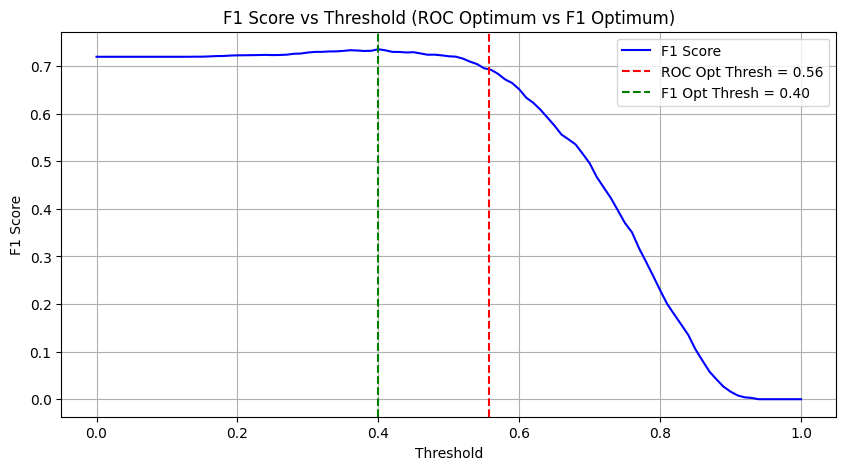

ROC Curve Optimum Threshold: 0.56
F1 Max: 0.7352 @ Threshold = 0.40


In [ ]:
# Predicted probabilities on the test set
y_prob = model.predict_proba(X_test_final)[:, 1]
y_true = y_test.values

# ROC curve & Youden's J statistic to find ROC-optimal threshold
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
j_scores = tpr - fpr
best_thresh_roc = thresholds_roc[np.argmax(j_scores)]

# F1 score analysis across different thresholds
thresholds_f1 = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_true, (y_prob >= thr).astype(int)) for thr in thresholds_f1]
best_f1 = max(f1_scores)
best_thresh_f1 = thresholds_f1[np.argmax(f1_scores)]

# Plot F1 Score vs Threshold (and mark ROC-optimal & F1-optimal thresholds)
plt.figure(figsize=(10,5))

# F1 score curve
plt.plot(thresholds_f1, f1_scores, label='F1 Score', color='blue')

# ROC-optimal threshold line
plt.axvline(best_thresh_roc, color='red', linestyle='--', label=f'ROC Opt Thresh = {best_thresh_roc:.2f}')

# F1-optimal threshold line
plt.axvline(best_thresh_f1, color='green', linestyle='--', label=f'F1 Opt Thresh = {best_thresh_f1:.2f}')

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold (ROC Optimum vs F1 Optimum)')
plt.legend()
plt.grid(True)
plt.show()

# Print summary of optimal thresholds
print(f"ROC Curve Optimum Threshold: {best_thresh_roc:.2f}")
print(f"F1 Max: {best_f1:.4f} @ Threshold = {best_thresh_f1:.2f}")

   Threshold  Accuracy  Precision    Recall  F1 Score
0       0.40  0.629921   0.614625  0.914553  0.735176
1       0.50  0.653543   0.658915  0.794393  0.720339
2       0.56  0.652793   0.689655  0.694259  0.691949


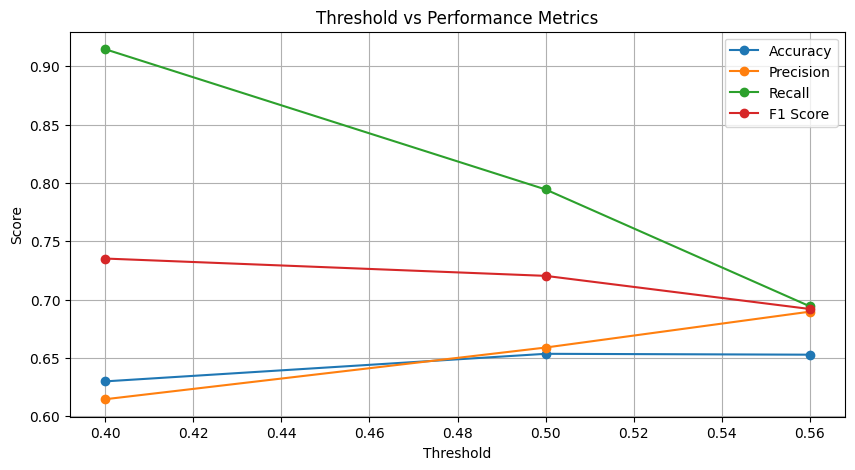

In [ ]:
# List of thresholds to evaluate
thresholds = [0.40, 0.50, 0.56]

results = []
for thr in thresholds:
    y_pred_thr = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_test, y_pred_thr)
    f1 = f1_score(y_test, y_pred_thr)
    prec = precision_score(y_test, y_pred_thr)
    rec = recall_score(y_test, y_pred_thr)
    results.append([thr, acc, prec, rec, f1])

# Display metrics as a DataFrame
df_thr = pd.DataFrame(results, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(df_thr)

# Plot metrics by threshold
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(10,5))
for metric in metrics:
    plt.plot(df_thr['Threshold'], df_thr[metric], marker='o', label=metric)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()

### XGBoostClassifier

In [ ]:
# BASELINE XGBoost Model (Using RFE-Selected Feature Set)
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

In [ ]:
# Cross-Validation (Training Set)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train_final = X_train_scaled[selected_features]

# Evaluate the XGBoost model using 5-fold cross-validation
acc_scores = cross_val_score(xgb_model, X_train_final, y_train, cv=cv, scoring='accuracy')
f1_scores  = cross_val_score(xgb_model, X_train_final, y_train, cv=cv, scoring='f1')
auc_scores = cross_val_score(xgb_model, X_train_final, y_train, cv=cv, scoring='roc_auc')

print("=== XGBoost Cross-Validation Results ===")
print(f"Accuracy : {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"F1 Score : {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
print(f"ROC AUC  : {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")

=== XGBoost Cross-Validation Results ===
Accuracy : 0.6542 ± 0.0097
F1 Score : 0.7255 ± 0.0071
ROC AUC  : 0.6985 ± 0.0084


In [ ]:
# Train the Model on Combined Train + Validation Set
X_trainval_final = pd.concat([X_train_scaled[selected_features], X_val_scaled[selected_features]], axis=0)
y_trainval_final = pd.concat([y_train, y_val], axis=0)

xgb_model.fit(X_trainval_final, y_trainval_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Test Set Performance
X_test_final = X_test_scaled[selected_features]
y_test_final = y_test

# Generate predictions and predicted probabilities
y_test_pred = xgb_model.predict(X_test_final)
y_test_prob = xgb_model.predict_proba(X_test_final)[:, 1]

# Evaluate model on the test set
print("\n=== XGBoost Test Results ===")
print(f"Accuracy : {accuracy_score(y_test_final, y_test_pred):.4f}")
print(f"F1 Score : {f1_score(y_test_final, y_test_pred):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test_final, y_test_prob):.4f}")
print(f"Log Loss : {log_loss(y_test_final, y_test_prob):.4f}")


=== XGBoost Test Results ===
Accuracy : 0.6397
F1 Score : 0.7037
ROC AUC  : 0.6630
Log Loss : 0.6529


#### Optimization

In [ ]:
# BASELINE XGBoost Model (Using 30 RFE-Selected Features)
xgb_baseline = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

# Define train/val/test sets using selected features
Xtr = X_train_scaled[selected_features]
ytr = y_train
Xva = X_val_scaled[selected_features]
yva = y_val
Xte = X_test_scaled[selected_features]
yte = y_test

# Train only on training set, evaluate on validation set
xgb_baseline.fit(Xtr, ytr, eval_set=[(Xva, yva)], verbose=False)

print("=== Baseline XGBoost (RFE 30 features) ===")
val_metrics = eval_clf(xgb_baseline, Xva, yva, threshold=0.5)
print(f"Val Accuracy: {val_metrics['Accuracy']:.4f} | AUC: {val_metrics['ROC_AUC']:.4f}")

=== Baseline XGBoost (RFE 30 features) ===
Val Accuracy: 0.6156 | AUC: 0.6462


In [ ]:
# Hyperparameter Tuning (Small Grid Search)
# Model is selected based on best Validation AUC / LogLoss
param_grid = {
    "n_estimators":   [200, 400],
    "learning_rate":  [0.03, 0.05, 0.1],
    "max_depth":      [3, 5, 7],
    "subsample":      [0.8],
    "colsample_bytree":[0.8, 1.0]
}

search_rows = []
best_auc = -np.inf
best_params = None
best_model = None

# Grid search over all parameter combinations
for n_est, lr, md, ss, cs in product(
        param_grid["n_estimators"],
        param_grid["learning_rate"],
        param_grid["max_depth"],
        param_grid["subsample"],
        param_grid["colsample_bytree"]):

    model_tmp = XGBClassifier(
        n_estimators=n_est,
        learning_rate=lr,
        max_depth=md,
        subsample=ss,
        colsample_bytree=cs,
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    )

    # Train on train set, evaluate on validation set
    model_tmp.fit(Xtr, ytr, eval_set=[(Xva, yva)], verbose=False)

    # Evaluate validation performance
    m = eval_clf(model_tmp, Xva, yva, threshold=0.5)

    # Save results
    search_rows.append({
        "n_estimators": n_est,
        "learning_rate": lr,
        "max_depth": md,
        "subsample": ss,
        "colsample_bytree": cs,
        "Val_AUC": m["ROC_AUC"],
        "Val_LogLoss": m["LogLoss"],
        "Val_F1": m["F1"],
        "Val_Acc": m["Accuracy"]
    })

    # Track best model by AUC
    if m["ROC_AUC"] > best_auc:
        best_auc = m["ROC_AUC"]
        best_params = (n_est, lr, md, ss, cs)
        best_model = model_tmp

# Compile results into a DataFrame and sort by AUC
xgb_search_df = pd.DataFrame(search_rows).sort_values("Val_AUC", ascending=False)
print("\n=== Grid Search (Val AUC sorted, top 5) ===")
display(xgb_search_df.head())

# Print best configuration
print(f"\nBest params (Val AUC): n_estimators={best_params[0]}, lr={best_params[1]}, "
      f"max_depth={best_params[2]}, subsample={best_params[3]}, colsample_bytree={best_params[4]} "
      f"| Val AUC={best_auc:.4f}")


=== Grid Search (Val AUC sorted, top 5) ===


,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,Val_AUC,Val_LogLoss,Val_F1,Val_Acc
0,200,0.03,3,0.8,0.8,0.667794,0.651780,0.682266,0.612613
1,200,0.03,3,0.8,1.0,0.667513,0.652484,0.684406,0.617117
7,200,0.05,3,0.8,1.0,0.660317,0.659185,0.680798,0.615616
6,200,0.05,3,0.8,0.8,0.659363,0.657872,0.677798,0.608859
2,200,0.03,5,0.8,0.8,0.657395,0.659223,0.675726,0.605856



Best params (Val AUC): n_estimators=200, lr=0.03, max_depth=3, subsample=0.8, colsample_bytree=0.8 | Val AUC=0.6678


In [ ]:
# Final Model: Train on Train + Validation Using Best Parameters

# Combine training and validation sets
Xtrv = pd.concat([Xtr, Xva], axis=0)
ytrv = pd.concat([ytr, yva], axis=0)

# Initialize XGBoost with best hyperparameters from grid search
xgb_final = XGBClassifier(
    n_estimators=best_params[0],
    learning_rate=best_params[1],
    max_depth=best_params[2],
    subsample=best_params[3],
    colsample_bytree=best_params[4],
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

# Fit final model on full train+val set (eval_set is for monitoring only)
xgb_final.fit(Xtrv, ytrv, eval_set=[(Xva, yva)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Test Performance Evaluation (initial threshold = 0.5)
test_metrics = eval_clf(xgb_final, Xte, yte, threshold=0.5)
print("\n=== XGBoost Final Test (threshold=0.5) ===")
for k in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "LogLoss"]:
    print(f"{k:>10}: {test_metrics[k]:.4f}")

# Store predicted probabilities for threshold analysis
y_prob_xgb = test_metrics["y_prob"]


=== XGBoost Final Test (threshold=0.5) ===
  Accuracy: 0.6438
 Precision: 0.6527
    Recall: 0.7817
        F1: 0.7114
   ROC_AUC: 0.6805
   LogLoss: 0.6370


In [ ]:
# Threshold Analysis (ROC-optimal, F1-optimal, and specific thresholds)
# Find ROC-optimal threshold using Youden’s J statistic (TPR - FPR)
fpr, tpr, thr_roc = roc_curve(yte, y_prob_xgb)
j_scores = tpr - fpr
best_thr_roc = thr_roc[np.argmax(j_scores)]

# Find F1-optimal threshold via threshold sweep
thr_sweep = np.arange(0.0, 1.01, 0.01)
f1_sweep = [f1_score(yte, (y_prob_xgb >= t).astype(int)) for t in thr_sweep]
best_thr_f1 = thr_sweep[np.argmax(f1_sweep)]
best_f1_val = max(f1_sweep)

# Print best thresholds
print(f"\nThreshold sweep:")
print(f"- ROC-opt threshold: {best_thr_roc:.2f}")
print(f"- Max F1: {best_f1_val:.4f} @ threshold={best_thr_f1:.2f}")

# Compare multiple thresholds (including fixed and dynamic)
check_thr = [0.40, 0.50, 0.56, best_thr_f1, best_thr_roc]
rows = []
for t in check_thr:
    y_hat = (y_prob_xgb >= t).astype(int)
    rows.append({
        "Threshold": t,
        "Accuracy": accuracy_score(yte, y_hat),
        "Precision": precision_score(yte, y_hat),
        "Recall": recall_score(yte, y_hat),
        "F1": f1_score(yte, y_hat)
    })

# Create DataFrame and display results
thr_df = pd.DataFrame(rows).drop_duplicates(subset=["Threshold"]).sort_values("Threshold")
print("\n=== Threshold Comparison (XGBoost Test) ===")
display(thr_df)


Threshold sweep:
- ROC-opt threshold: 0.59
- Max F1: 0.7310 @ threshold=0.39

=== Threshold Comparison (XGBoost Test) ===


,Threshold,Accuracy,Precision,Recall,F1
3,0.390000,0.616048,0.602686,0.928571,0.730951
0,0.400000,0.620172,0.607064,0.917891,0.730800
1,0.500000,0.643795,0.652731,0.781709,0.711422
2,0.560000,0.641545,0.684354,0.671562,0.677898
4,0.587266,0.638545,0.699552,0.624833,0.660085


In [ ]:
# Alternative: XGBoost Using ALL Numeric Features (for Comparison)
# Use all numeric features from the same scaled dataset
Xtr_all = X_train_scaled[numeric_cols]
Xva_all = X_val_scaled[numeric_cols]
Xte_all = X_test_scaled[numeric_cols]

xgb_all = XGBClassifier(
    n_estimators=best_params[0],    # using same best parameters from RFE model
    learning_rate=best_params[1],
    max_depth=best_params[2],
    subsample=best_params[3],
    colsample_bytree=best_params[4],
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

# Train on full training + validation set
xgb_all.fit(pd.concat([Xtr_all, Xva_all], axis=0), pd.concat([ytr, yva], axis=0), verbose=False)

# Evaluate on test set
all_metrics = eval_clf(xgb_all, Xte_all, yte, threshold=0.5)
print("\n=== XGBoost (All Numeric Features) Test Results (thr=0.5) ===")
for k in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "LogLoss"]:
    print(f"{k:>10}: {all_metrics[k]:.4f}")


=== XGBoost (All Numeric Features) Test Results (thr=0.5) ===
  Accuracy: 0.6363
 Precision: 0.6480
    Recall: 0.7717
        F1: 0.7044
   ROC_AUC: 0.6824
   LogLoss: 0.6350


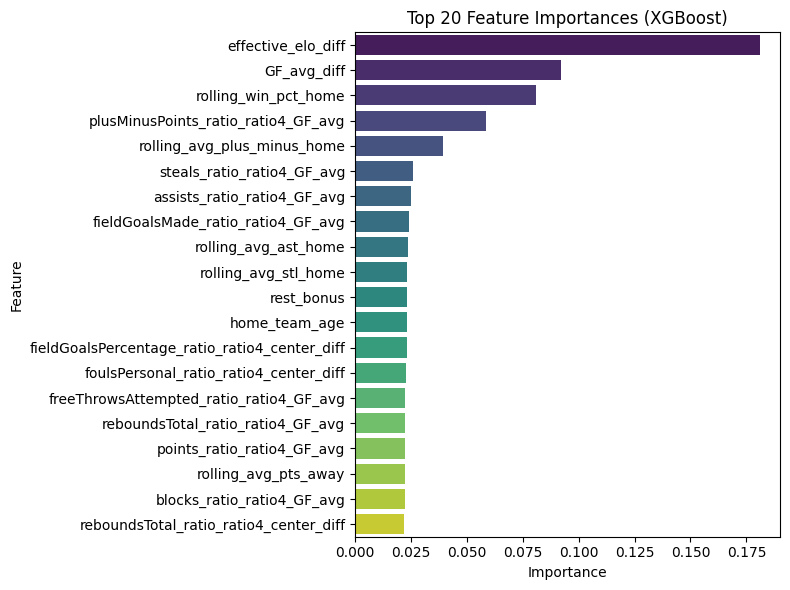

Top 20 Feature Importances:
                                          Feature  Importance
8                              effective_elo_diff    0.180990
29                                    GF_avg_diff    0.091952
4                            rolling_win_pct_home    0.080946
16            plusMinusPoints_ratio_ratio4_GF_avg    0.058640
3                     rolling_avg_plus_minus_home    0.039251
18                     steals_ratio_ratio4_GF_avg    0.025660
22                    assists_ratio_ratio4_GF_avg    0.025175
23             fieldGoalsMade_ratio_ratio4_GF_avg    0.024050
0                            rolling_avg_ast_home    0.023640
1                            rolling_avg_stl_home    0.023344
7                                      rest_bonus    0.023137
6                                   home_team_age    0.023069
11  fieldGoalsPercentage_ratio_ratio4_center_diff    0.022986
12         foulsPersonal_ratio_ratio4_center_diff    0.022914
27        freeThrowsAttempted_ratio_ratio4

In [ ]:
# Compute feature importances from trained XGBoost model
importances = xgb_final.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top N most important features
top_n = 20
top_features = feat_imp.head(top_n)

# Plot top N feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

# Print the table of top features
print("Top 20 Feature Importances:")
print(top_features)

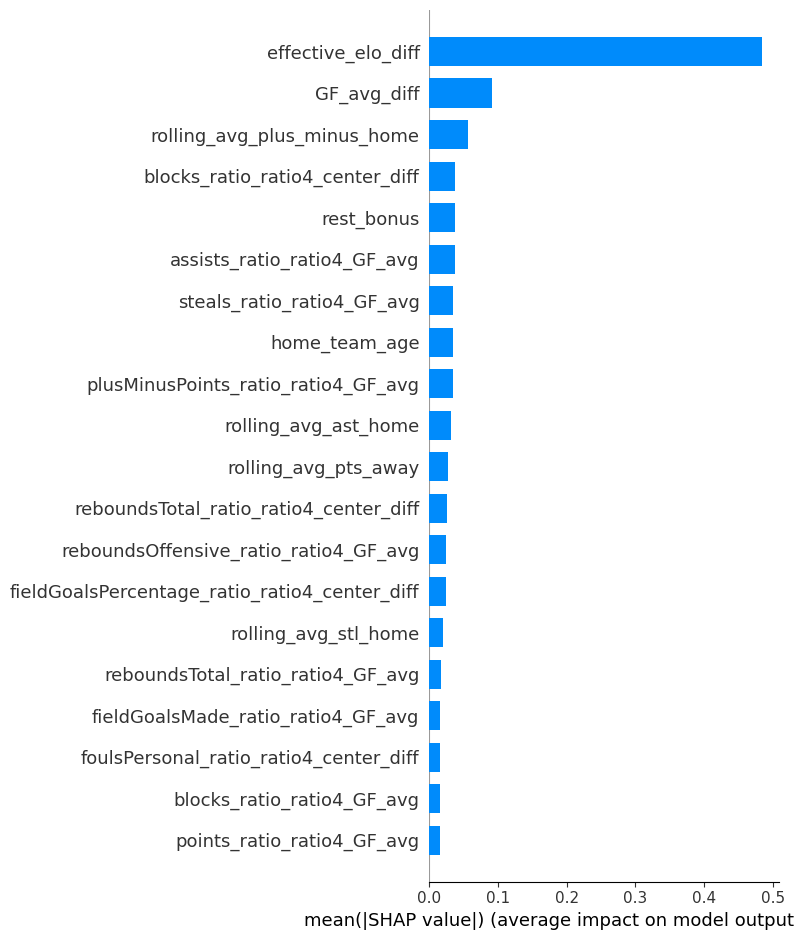

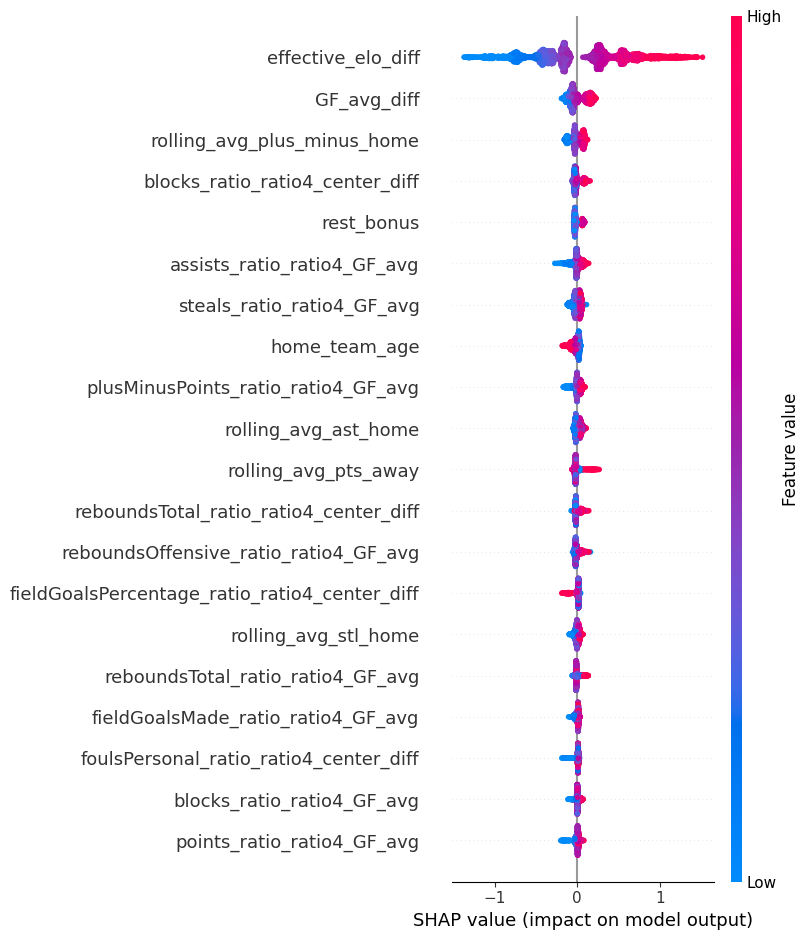

In [ ]:
# Create SHAP explainer for the trained XGBoost model
explainer = shap.TreeExplainer(xgb_final)

# Compute SHAP values on the test set
shap_values = explainer.shap_values(X_test_scaled[selected_features])

# Summary Plot (Global feature importance as bar chart)
shap.summary_plot(shap_values, X_test_scaled[selected_features], plot_type="bar")

# Summary Plot (Feature value vs SHAP value distribution)
shap.summary_plot(shap_values, X_test_scaled[selected_features])

# Explanation for a single test instance (e.g., first row)
sample_index = 0
shap.force_plot(explainer.expected_value, shap_values[sample_index, :],
                X_test_scaled[selected_features].iloc[sample_index, :])

### Random Forest Classifier

In [ ]:
# Baseline Random Forest
rf_baseline = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Define Train/Val/Test sets using RFE-selected features
Xtr = X_train_scaled[selected_features]
ytr = y_train
Xva = X_val_scaled[selected_features]
yva = y_val
Xte = X_test_scaled[selected_features]
yte = y_test

# Train Random Forest on the training set
rf_baseline.fit(Xtr, ytr)
print("=== Baseline Random Forest (RFE 30 features) ===")
val_metrics = eval_clf(rf_baseline, Xva, yva, threshold=0.5)
print(f"Val Accuracy: {val_metrics['Accuracy']:.4f} | AUC: {val_metrics['ROC_AUC']:.4f}")

=== Baseline Random Forest (RFE 30 features) ===
Val Accuracy: 0.6096 | AUC: 0.6619


In [ ]:
# Hyperparameter Tuning (RandomizedSearchCV)
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [5, 10, 15, 20, None],
    "max_features": ['sqrt', 'log2', 0.5, 0.7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_grid,
    n_iter=20,   # Test 20 random combinations
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Run the random search on the training set
random_search.fit(Xtr, ytr)

# Display the best parameter set and score
print("\nBest Params (RandomizedSearch):", random_search.best_params_)
print("Best AUC (CV):", random_search.best_score_)

# Save best parameter combination
best_params = random_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Params (RandomizedSearch): {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 5}
Best AUC (CV): 0.71412553626234


In [ ]:
# Final Model Training (Train + Validation Combined)
# Combine training and validation sets
Xtrv = pd.concat([Xtr, Xva], axis=0)
ytrv = pd.concat([ytr, yva], axis=0)

# Initialize Random Forest with best hyperparameters
rf_final = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

# Train final model
rf_final.fit(Xtrv, ytrv)

RandomForestClassifier(max_depth=5, max_features=0.5, min_samples_split=10,
                       n_estimators=600, n_jobs=-1, random_state=42)

In [ ]:
# Test Performance (threshold = 0.5)

# Evaluate final Random Forest model on the test set
test_metrics = eval_clf(rf_final, Xte, yte, threshold=0.5)
print("\n=== Random Forest Final Test (threshold=0.5) ===")
for k in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "LogLoss"]:
    print(f"{k:>10}: {test_metrics[k]:.4f}")

# Store predicted probabilities for further threshold analysis
y_prob_rf = test_metrics["y_prob"]


=== Random Forest Final Test (threshold=0.5) ===
  Accuracy: 0.6464
 Precision: 0.6521
    Recall: 0.7944
        F1: 0.7162
   ROC_AUC: 0.6833
   LogLoss: 0.6350


In [ ]:
# Threshold Analysis (ROC-optimal & F1-optimal Thresholds)
# Compute ROC-optimal threshold using Youden's J statistic (TPR - FPR)
fpr, tpr, thr_roc = roc_curve(yte, y_prob_rf)
j_scores = tpr - fpr
best_thr_roc = thr_roc[np.argmax(j_scores)]

#Find F1-optimal threshold via sweep
thr_sweep = np.arange(0.0, 1.01, 0.01)
f1_sweep = [f1_score(yte, (y_prob_rf >= t).astype(int)) for t in thr_sweep]
best_thr_f1 = thr_sweep[np.argmax(f1_sweep)]
best_f1_val = max(f1_sweep)

# Print optimal thresholds
print(f"\nThreshold sweep:")
print(f"- ROC-opt threshold: {best_thr_roc:.2f}")
print(f"- Max F1: {best_f1_val:.4f} @ threshold={best_thr_f1:.2f}")

# Compare performance at selected thresholds
check_thr = [0.40, 0.50, 0.56, best_thr_f1, best_thr_roc]
rows = []
for t in check_thr:
    y_hat = (y_prob_rf >= t).astype(int)
    rows.append({
        "Threshold": t,
        "Accuracy": accuracy_score(yte, y_hat),
        "Precision": precision_score(yte, y_hat),
        "Recall": recall_score(yte, y_hat),
        "F1": f1_score(yte, y_hat)
    })

thr_df = pd.DataFrame(rows).drop_duplicates(subset=["Threshold"]).sort_values("Threshold")
print("\n=== Threshold Comparison (Random Forest Test) ===")
print(thr_df)


Threshold sweep:
- ROC-opt threshold: 0.57
- Max F1: 0.7354 @ threshold=0.45

=== Threshold Comparison (Random Forest Test) ===
   Threshold  Accuracy  Precision    Recall        F1
0   0.400000  0.611174   0.599482  0.927236  0.728178
3   0.450000  0.644169   0.631403  0.880507  0.735434
1   0.500000  0.646419   0.652055  0.794393  0.716220
2   0.560000  0.640420   0.681481  0.675567  0.678512
4   0.574097  0.643795   0.694326  0.653538  0.673315


### MLPClassifier

In [ ]:
# Baseline MLP (Multi-Layer Perceptron)
mlp_baseline = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # 2 katmanlı basit bir ağ
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    max_iter=300,
    random_state=42
)

# Prepare Train/Validation/Test sets using RFE-selected features
Xtr = X_train_scaled[selected_features]
ytr = y_train
Xva = X_val_scaled[selected_features]
yva = y_val
Xte = X_test_scaled[selected_features]
yte = y_test

# Train baseline MLP model
mlp_baseline.fit(Xtr, ytr)

# Evaluate on validation set
print("=== Baseline MLP (RFE 30 features) ===")
val_metrics = eval_clf(mlp_baseline, Xva, yva, threshold=0.5)
print(f"Val Accuracy: {val_metrics['Accuracy']:.4f} | AUC: {val_metrics['ROC_AUC']:.4f}")

=== Baseline MLP (RFE 30 features) ===
Val Accuracy: 0.5698 | AUC: 0.5805


In [ ]:
# Hyperparameter Tuning (RandomizedSearchCV for MLP)
param_grid = {
    "hidden_layer_sizes": [(64,), (64, 32), (128, 64), (128, 64, 32)],
    "activation": ['relu', 'tanh'],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate_init": [0.001, 0.01],
    "batch_size": [32, 64, 128]
}

mlp_model = MLPClassifier(
    solver='adam',
    max_iter=300,
    random_state=42
)

random_search = RandomizedSearchCV(
    mlp_model,
    param_distributions=param_grid,
    n_iter=20,   # Try 20 random hyperparameter combinations
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Perform hyperparameter search
random_search.fit(Xtr, ytr)

# Display best parameters and validation AUC
print("\nBest Params (RandomizedSearch):", random_search.best_params_)
print("Best AUC (CV):", random_search.best_score_)

# Save the best parameter set
best_params = random_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Params (RandomizedSearch): {'learning_rate_init': 0.01, 'hidden_layer_sizes': (128, 64), 'batch_size': 32, 'alpha': 0.01, 'activation': 'tanh'}
Best AUC (CV): 0.6820237225162386


In [ ]:
# Final Model Training (Train + Validation Combined)
# Combine training and validation sets
Xtrv = pd.concat([Xtr, Xva], axis=0)
ytrv = pd.concat([ytr, yva], axis=0)

# Initialize final MLP model with best hyperparameters
mlp_final = MLPClassifier(
    **best_params,
    solver='adam',
    max_iter=500, # Increase max_iter for full training
    random_state=42
)

# Train the final model
mlp_final.fit(Xtrv, ytrv)

MLPClassifier(activation='tanh', alpha=0.01, batch_size=32,
              hidden_layer_sizes=(128, 64), learning_rate_init=0.01,
              max_iter=500, random_state=42)

In [ ]:
# Test Performance Evaluation (Threshold = 0.5)
# Evaluate final MLP model on the test set
test_metrics = eval_clf(mlp_final, Xte, yte, threshold=0.5)
print("\n=== MLP Final Test (threshold=0.5) ===")
for k in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "LogLoss"]:
    print(f"{k:>10}: {test_metrics[k]:.4f}")

# Store predicted probabilities for further threshold analysis
y_prob_mlp = test_metrics["y_prob"]


=== MLP Final Test (threshold=0.5) ===
  Accuracy: 0.6479
 Precision: 0.6507
    Recall: 0.8057
        F1: 0.7200
   ROC_AUC: 0.6806
   LogLoss: 0.6361


In [ ]:
# Threshold Analysis (ROC Optimum & F1 Optimum)
# ROC Curve – Youden's J statistic for optimal threshold
fpr, tpr, thr_roc = roc_curve(yte, y_prob_mlp)
j_scores = tpr - fpr
best_thr_roc = thr_roc[np.argmax(j_scores)]

# F1 Score Sweep – Find threshold that maximizes F1
thr_sweep = np.arange(0.0, 1.01, 0.01)
f1_sweep = [f1_score(yte, (y_prob_mlp >= t).astype(int)) for t in thr_sweep]
best_thr_f1 = thr_sweep[np.argmax(f1_sweep)]
best_f1_val = max(f1_sweep)

# Print threshold summary
print(f"\nThreshold sweep:")
print(f"- ROC-opt threshold: {best_thr_roc:.2f}")
print(f"- Max F1: {best_f1_val:.4f} @ threshold={best_thr_f1:.2f}")

# Evaluate model at selected thresholds
check_thr = [0.40, 0.50, 0.56, best_thr_f1, best_thr_roc]
rows = []
for t in check_thr:
    y_hat = (y_prob_mlp >= t).astype(int)
    rows.append({
        "Threshold": t,
        "Accuracy": accuracy_score(yte, y_hat),
        "Precision": precision_score(yte, y_hat),
        "Recall": recall_score(yte, y_hat),
        "F1": f1_score(yte, y_hat)
    })

# Display threshold comparison table
thr_df = pd.DataFrame(rows).drop_duplicates(subset=["Threshold"]).sort_values("Threshold")
print("\n=== Threshold Comparison (MLP Test) ===")
print(thr_df)


Threshold sweep:
- ROC-opt threshold: 0.56
- Max F1: 0.7337 @ threshold=0.38

=== Threshold Comparison (MLP Test) ===
   Threshold  Accuracy  Precision    Recall        F1
3   0.380000  0.620547   0.605560  0.930574  0.733684
0   0.400000  0.629921   0.616720  0.901202  0.732303
1   0.500000  0.647919   0.650674  0.805741  0.719952
2   0.560000  0.652793   0.678082  0.726969  0.701675
4   0.560742  0.653543   0.679151  0.726302  0.701935


### Naive Bayes (GaussianNB)

In [ ]:
# Naive Bayes + Grid Search (var_smoothing)
# Define parameter grid for GaussianNB
param_grid_gnb = {'var_smoothing': np.logspace(-9, -1, 9)}

# Grid search with 3-fold CV using ROC AUC as scoring
grid_gnb = GridSearchCV(GaussianNB(), param_grid_gnb, scoring='roc_auc', cv=3, n_jobs=-1, verbose=0)

# Define train/val/test splits using RFE-selected features
Xtr = X_train_scaled[selected_features]
ytr = y_train
Xva = X_val_scaled[selected_features]
yva = y_val
Xte = X_test_scaled[selected_features]
yte = y_test

# Fit grid search on training data
grid_gnb.fit(Xtr, ytr)
print(f"Best var_smoothing: {grid_gnb.best_params_['var_smoothing']} | Best CV AUC: {grid_gnb.best_score_:.4f}")

# Best model from search
nb_model = grid_gnb.best_estimator_

# Evaluate on validation set
print("\n=== Baseline Naive Bayes (Best var_smoothing) ===")
val_metrics = eval_clf(nb_model, Xva, yva, threshold=0.5)
print(f"Val Accuracy: {val_metrics['Accuracy']:.4f} | AUC: {val_metrics['ROC_AUC']:.4f}")

Best var_smoothing: 1e-05 | Best CV AUC: 0.6871

=== Baseline Naive Bayes (Best var_smoothing) ===
Val Accuracy: 0.5983 | AUC: 0.6371


In [ ]:
# Final Model Training (Train + Validation)
# Combine train and validation sets
Xtrv = pd.concat([Xtr, Xva], axis=0)
ytrv = pd.concat([ytr, yva], axis=0)

# Instantiate GaussianNB with best var_smoothing from GridSearch
nb_final = GaussianNB(var_smoothing=grid_gnb.best_params_['var_smoothing'])

# Fit final model on the full training data
nb_final.fit(Xtrv, ytrv)

GaussianNB(var_smoothing=np.float64(1e-05))

In [ ]:
# Test Performance (threshold = 0.5)
test_metrics = eval_clf(nb_final, Xte, yte, threshold=0.5)
print("\n=== Naive Bayes Final Test (threshold=0.5) ===")
for k in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "LogLoss"]:
    print(f"{k:>10}: {test_metrics[k]:.4f}")

y_prob_nb = test_metrics["y_prob"]


=== Naive Bayes Final Test (threshold=0.5) ===
  Accuracy: 0.6127
 Precision: 0.6521
    Recall: 0.6656
        F1: 0.6587
   ROC_AUC: 0.6560
   LogLoss: 1.0563


In [ ]:
# Threshold Analysis (ROC Optimum & F1 Optimum)
fpr, tpr, thr_roc = roc_curve(yte, y_prob_nb)
j_scores = tpr - fpr
best_thr_roc = thr_roc[np.argmax(j_scores)]

# F1 Sweep
thr_sweep = np.arange(0.0, 1.01, 0.01)
f1_sweep = [f1_score(yte, (y_prob_nb >= t).astype(int)) for t in thr_sweep]
best_thr_f1 = thr_sweep[np.argmax(f1_sweep)]
best_f1_val = max(f1_sweep)

print(f"\nThreshold sweep:")
print(f"- ROC-opt threshold: {best_thr_roc:.2f}")
print(f"- Max F1: {best_f1_val:.4f} @ threshold={best_thr_f1:.2f}")

# Comparison table for selected thresholds
check_thr = [0.40, 0.50, 0.56, best_thr_f1, best_thr_roc]
rows = []
for t in check_thr:
    y_hat = (y_prob_nb >= t).astype(int)
    rows.append({
        "Threshold": t,
        "Accuracy": accuracy_score(yte, y_hat),
        "Precision": precision_score(yte, y_hat),
        "Recall": recall_score(yte, y_hat),
        "F1": f1_score(yte, y_hat)
    })

thr_df = pd.DataFrame(rows).drop_duplicates(subset=["Threshold"]).sort_values("Threshold")
print("\n=== Threshold Comparison (Naive Bayes Test) ===")
print(thr_df)



Threshold sweep:
- ROC-opt threshold: 0.76
- Max F1: 0.7250 @ threshold=0.01

=== Threshold Comparison (Naive Bayes Test) ===
   Threshold  Accuracy  Precision    Recall        F1
3   0.010000  0.587927   0.579832  0.967290  0.725044
0   0.400000  0.621297   0.647521  0.714953  0.679569
1   0.500000  0.612673   0.652060  0.665554  0.658738
2   0.560000  0.608549   0.656336  0.636182  0.646102
4   0.759163  0.606674   0.693368  0.537383  0.605491


### K Neighbors Classifier

In [ ]:
# Split scaled train, val, test using selected features
Xtr = X_train_scaled[selected_features]
ytr = y_train
Xva = X_val_scaled[selected_features]
yva = y_val
Xte = X_test_scaled[selected_features]
yte = y_test

# Define hyperparameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

# Perform GridSearchCV with 3-fold CV and ROC AUC scoring
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
grid_knn.fit(Xtr, ytr)

# Display best model and its performance
best_knn = grid_knn.best_estimator_
print("Best KNN Params:", grid_knn.best_params_)
print("Val AUC:", grid_knn.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best KNN Params: {'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'distance'}
Val AUC: 0.6399403536603389


In [ ]:
#  Combined Train + Validation Model
Xtrv = pd.concat([Xtr, Xva], axis=0)
ytrv = pd.concat([ytr, yva], axis=0)
best_knn.fit(Xtrv, ytrv)

KNeighborsClassifier(n_neighbors=11, weights='distance')

In [ ]:
# Test Performance
knn_metrics = eval_clf(best_knn, Xte, yte)
print("\n=== KNN Test (threshold=0.5) ===")
for k in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "LogLoss"]:
    print(f"{k:>10}: {knn_metrics[k]:.4f}")


=== KNN Test (threshold=0.5) ===
  Accuracy: 0.5996
 Precision: 0.6192
    Recall: 0.7457
        F1: 0.6766
   ROC_AUC: 0.6231
   LogLoss: 0.8480


### Support Vector Classifier

In [ ]:
# GridSearchCV for SVC (Tuning C, gamma, and kernel)
# Initialize SVC model with probability estimates and balanced class weights
svc = SVC(probability=True, class_weight='balanced', random_state=42)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 5, 10],
    'gamma': ['scale', 0.01, 0.1, 1]
}

# Set up GridSearchCV with 3-fold cross-validation and AUC as the scoring metric
grid_svc = GridSearchCV(
    svc,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the model using only the training set
grid_svc.fit(X_train_scaled[selected_features], y_train)

# Print best parameters and best cross-validation AUC score
print("\n=== Best Params (SVC) ===")
print(grid_svc.best_params_)
print(f"Best CV AUC: {grid_svc.best_score_:.4f}")

# Retrieve the best estimator from grid search
svc_best = grid_svc.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits

=== Best Params (SVC) ===
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV AUC: 0.7170


In [ ]:
# Validation Performance
# Evaluate the best SVC model on the validation set using default threshold = 0.5
val_metrics = eval_clf(svc_best, X_val_scaled[selected_features], y_val)

# Print validation performance metrics
print("\n=== SVC Validation Metrics (Threshold=0.5) ===")
for k in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "LogLoss"]:
    print(f"{k:>10}: {val_metrics[k]:.4f}")


=== SVC Validation Metrics (Threshold=0.5) ===
  Accuracy: 0.6149
 Precision: 0.6135
    Recall: 0.7795
        F1: 0.6866
   ROC_AUC: 0.6663
   LogLoss: 0.6525


In [ ]:
# Final Model with Train + Validation Data
# Concatenate train and validation sets to train the final model
Xtrv = pd.concat([X_train_scaled[selected_features], X_val_scaled[selected_features]], axis=0)
ytrv = pd.concat([y_train, y_val], axis=0)

# Initialize the final SVC model with best hyperparameters from GridSearch
svc_final = SVC(
    C=grid_svc.best_params_['C'],
    kernel=grid_svc.best_params_['kernel'],
    gamma=grid_svc.best_params_['gamma'],
    probability=True,
    class_weight='balanced',
    random_state=42
)

# Fit the final model on the combined training data
svc_final.fit(Xtrv, ytrv)

SVC(C=0.1, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)

In [ ]:
# Test Performance (Threshold = 0.5)
# Evaluate the final SVC model on the test set using default threshold of 0.5
test_metrics = eval_clf(svc_final, X_test_scaled[selected_features], y_test, threshold=0.5)

# Print key performance metrics
print("\n=== SVC Final Test (Threshold=0.5) ===")
for k in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "LogLoss"]:
    print(f"{k:>10}: {test_metrics[k]:.4f}")


=== SVC Final Test (Threshold=0.5) ===
  Accuracy: 0.6502
 Precision: 0.6538
    Recall: 0.8017
        F1: 0.7202
   ROC_AUC: 0.6899
   LogLoss: 0.6305


In [ ]:
# Threshold Analysis (ROC-optimal and F1-optimal)

# Predicted probabilities for the test set
y_prob_svc = test_metrics["y_prob"]

# ROC-optimal threshold using Youden's J statistic
fpr, tpr, thr_roc = roc_curve(y_test, y_prob_svc)
j_scores = tpr - fpr
best_thr_roc = thr_roc[np.argmax(j_scores)]

# F1-optimal threshold sweep
thr_sweep = np.arange(0.0, 1.01, 0.01)
f1_sweep = [f1_score(y_test, (y_prob_svc >= t).astype(int)) for t in thr_sweep]
best_thr_f1 = thr_sweep[np.argmax(f1_sweep)]
best_f1_val = max(f1_sweep)

# Print best thresholds
print(f"\nThreshold sweep:")
print(f"- ROC-opt threshold: {best_thr_roc:.2f}")
print(f"- Max F1: {best_f1_val:.4f} @ threshold={best_thr_f1:.2f}")

# Compare performance at selected thresholds
check_thr = [0.40, 0.50, 0.56, best_thr_f1, best_thr_roc]
rows = []
for t in check_thr:
    y_hat = (y_prob_svc >= t).astype(int)
    rows.append({
        "Threshold": t,
        "Accuracy": accuracy_score(y_test, y_hat),
        "Precision": precision_score(y_test, y_hat),
        "Recall": recall_score(y_test, y_hat),
        "F1": f1_score(y_test, y_hat)
    })

# Create comparison table
thr_df_svc = pd.DataFrame(rows).drop_duplicates(subset=["Threshold"]).sort_values("Threshold")
print("\n=== Threshold Comparison (SVC Test) ===")
print(thr_df_svc)


Threshold sweep:
- ROC-opt threshold: 0.55
- Max F1: 0.7339 @ threshold=0.39

=== Threshold Comparison (SVC Test) ===
   Threshold  Accuracy  Precision    Recall        F1
3   0.390000  0.623922   0.608983  0.923231  0.733882
0   0.400000  0.623547   0.610465  0.911215  0.731119
1   0.500000  0.650169   0.653783  0.801736  0.720240
4   0.550201  0.655043   0.685972  0.711615  0.698558
2   0.560000  0.650169   0.688208  0.689586  0.688896


### ANN

In [ ]:
# Input preparation for the model: RFE-selected numerical features
X_train_dl = X_train_scaled[selected_features].values
X_val_dl   = X_val_scaled[selected_features].values
X_test_dl  = X_test_scaled[selected_features].values

In [ ]:
# ANN Model with EarlyStopping
ann = Sequential([
    Input(shape=(X_train_dl.shape[1],)),  # Input layer with shape equal to number of features
    Dense(128, activation='relu'),        # First hidden layer with 128 neurons and ReLU activation
    Dropout(0.3),                         # Dropout layer for regularization (30%)
    Dense(64, activation='relu'),         # Second hidden layer with 64 neurons
    Dropout(0.3),                         # Another dropout layer
    Dense(1, activation='sigmoid')        # Output layer with sigmoid activation for binary classification
])

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',                  # Monitors validation loss to prevent overfitting
    patience=5,                          # Stops training if no improvement for 5 epochs
    restore_best_weights=True            # Restores the model weights from the epoch with the best val_loss
)

history = ann.fit(
    X_train_dl, y_train,                 # Training data
    validation_data=(X_val_dl, y_val),   # Validation data
    epochs=100,                          # Maximum number of training epochs
    batch_size=32,                       # Number of samples per gradient update
    callbacks=[early_stop],              # Use early stopping during training
    verbose=0                            # Suppress training output
)

In [ ]:
# Prediction and Performance Evaluation
y_prob_ann = ann.predict(X_test_dl).flatten()
y_pred_ann = (y_prob_ann >= 0.5).astype(int)

print("\n=== ANN Test Results (threshold = 0.50) ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred_ann):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_ann):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_prob_ann):.4f}")
print(f"Log Loss : {log_loss(y_test, y_prob_ann):.4f}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

=== ANN Test Results (threshold = 0.50) ===
Accuracy : 0.6479
F1 Score : 0.7150
ROC AUC  : 0.6800
Log Loss : 0.6369


In [ ]:
# Threshold Sweep (to maximize F1 score)
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_test, (y_prob_ann >= t).astype(int)) for t in thresholds]
best_thr = thresholds[np.argmax(f1_scores)]
best_f1  = max(f1_scores)

print(f"\nBest Threshold for F1: {best_thr:.2f} (F1 = {best_f1:.4f})")

# Evaluate using the best threshold
y_pred_best = (y_prob_ann >= best_thr).astype(int)

print("\n=== ANN Test Results (Best Threshold) ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_best):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_prob_ann):.4f}")
print(f"Log Loss : {log_loss(y_test, y_prob_ann):.4f}")


Best Threshold for F1: 0.40 (F1 = 0.7337)

=== ANN Test Results (Best Threshold) ===
Accuracy : 0.6239
Precision: 0.6091
Recall   : 0.9226
F1 Score : 0.7337
ROC AUC  : 0.6800
Log Loss : 0.6369


### RNN

In [ ]:
# Load the cleaned dataset and define the target variable
df = df_cleaned.copy()
df['target'] = df['wl_home'].astype(int)

In [ ]:
# Select sequence and flat features
sequence_home = [col for col in df.columns if 'rolling_avg_' in col and '_home' in col]
sequence_away = [col for col in df.columns if 'rolling_avg_' in col and '_away' in col]
flat_features = [col for col in df.columns if ('diff' in col or 'elo' in col or 'rest_' in col) and df[col].dtype in [np.float64, np.int64]]

In [ ]:
# Remove rows with missing values in selected features or target
df.dropna(subset=sequence_home + sequence_away + flat_features + ['target'], inplace=True)

In [ ]:
# Scale sequential features and reshape for LSTM input (samples, timesteps, features)
scaler_seq = MinMaxScaler()
X_seq = df[sequence_home + sequence_away].copy()
X_seq_scaled = scaler_seq.fit_transform(X_seq)
seq_feature_count = len(sequence_home + sequence_away)
X_seq_scaled = X_seq_scaled.reshape(-1, 2, seq_feature_count // 2)  # (samples, timesteps, features)

scaler_flat = MinMaxScaler()
X_flat_scaled = scaler_flat.fit_transform(df[flat_features])
y = df['target'].values

In [ ]:
# Time-based train/test split (85% train, 15% test)
split_idx = int(len(df) * 0.85)
X_seq_train, X_seq_test = X_seq_scaled[:split_idx], X_seq_scaled[split_idx:]
X_flat_train, X_flat_test = X_flat_scaled[:split_idx], X_flat_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [ ]:
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


In [ ]:
# Build hybrid model (Bidirectional LSTM + Dense for flat features)
seq_input = Input(shape=(2, seq_feature_count // 2))
x = Bidirectional(LSTM(64, return_sequences=True))(seq_input)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32))(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)

flat_input = Input(shape=(X_flat_scaled.shape[1],))
y_ = Dense(64, activation='relu')(flat_input)
y_ = LayerNormalization()(y_)
y_ = Dropout(0.3)(y_)

combined = Concatenate()([x, y_])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
z = Dense(32, activation='relu')(z)
z = Dropout(0.2)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[seq_input, flat_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Define callbacks: Early stopping and learning rate scheduler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
]

In [ ]:
# Train the model
model.fit(
    [X_seq_train, X_flat_train], y_train,
    validation_data=([X_seq_test, X_flat_test], y_test),
    epochs=1000,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5233 - loss: 0.7131 - val_accuracy: 0.6180 - val_loss: 0.6748 - learning_rate: 5.0000e-04
Epoch 2/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5614 - loss: 0.6872 - val_accuracy: 0.6335 - val_loss: 0.6538 - learning_rate: 5.0000e-04
Epoch 3/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5906 - loss: 0.6674 - val_accuracy: 0.6245 - val_loss: 0.6524 - learning_rate: 5.0000e-04
Epoch 4/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6071 - loss: 0.6636 - val_accuracy: 0.6245 - val_loss: 0.6513 - learning_rate: 5.0000e-04
Epoch 5/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6188 - loss: 0.6552 - val_accuracy: 0.6235 - val_loss: 0.6509 - learning_rate: 5.0000e-04
Epoch 6/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6294 - loss: 0.6452 - val_accuracy: 0.6350 - val_loss: 0.6424 - learning_rate: 5.0000e-04
Epoch 7/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 1

In [ ]:
# Make predictions and evaluate model performance
y_pred = (model.predict([X_seq_test, X_flat_test]) >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.60      0.54      0.57       872
           1       0.67      0.73      0.70      1128

    accuracy                           0.64      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.64      0.64      2000



In [ ]:
# Print test accuracy with high precision
print(f"\nTest Accuracy (full precision): {accuracy_score(y_test, y_pred):.6f}")
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.6f}")


Test Accuracy (full precision): 0.646000
AUC Score: 0.679187


# Regression Models

## Preparing Data Set

In [ ]:
# Drop Unnecessary Columns
# Load the dataset
regression = df_model2.copy()

regression = regression.merge(
    df_game[['game_id', 'plus_minus_home']],
    on='game_id',
    how='left'
)
regression.head()

,game_id,game_date,team_name_home,team_name_away,wl_home,rolling_avg_fg_pct_home,rolling_avg_fg3_pct_home,rolling_avg_ft_pct_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fg_pct_away,rolling_avg_fg3_pct_away,rolling_avg_ft_pct_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_win_pct_away,home_city,home_state,away_city,away_state,home_team_age,away_team_age,season,rest_bonus,effective_elo_diff,season_phase,assists_ratio_ratio4_center_diff,blocks_ratio_ratio4_center_diff,fieldGoalsPercentage_ratio_ratio4_center_diff,foulsPersonal_ratio_ratio4_center_diff,freeThrowsPercentage_ratio_ratio4_center_diff,plusMinusPoints_ratio_ratio4_center_diff,points_ratio_ratio4_center_diff,reboundsTotal_ratio_ratio4_center_diff,steals_ratio_ratio4_center_diff,threePointersPercentage_ratio_ratio4_center_diff,turnovers_ratio_ratio4_center_diff,plusMinusPoints_ratio_ratio4_GF_avg,freeThrowsMade_ratio_ratio4_GF_avg,foulsPersonal_ratio_ratio4_GF_avg,steals_ratio_ratio4_GF_avg,threePointersMade_ratio_ratio4_GF_avg,fieldGoalsPercentage_ratio_ratio4_GF_avg,fieldGoalsAttempted_ratio_ratio4_GF_avg,reboundsDefensive_ratio_ratio4_GF_avg,threePointersAttempted_ratio_ratio4_GF_avg,points_ratio_ratio4_GF_avg,threePointersPercentage_ratio_ratio4_GF_avg,assists_ratio_ratio4_GF_avg,fieldGoalsMade_ratio_ratio4_GF_avg,blocks_ratio_ratio4_GF_avg,reboundsOffensive_ratio_ratio4_GF_avg,reboundsTotal_ratio_ratio4_GF_avg,freeThrowsAttempted_ratio_ratio4_GF_avg,turnovers_ratio_ratio4_GF_avg,freeThrowsPercentage_ratio_ratio4_GF_avg,GF_avg_diff,plus_minus_home
0,21000023,2010-10-29,Boston Celtics,New York Knicks,1,0.464,0.500,0.640,42.0,25.0,6.0,4.0,20.0,19.0,88.0,8.0,1.0,0.432,0.292,0.8820,49.0,12.0,4.0,10.0,16.0,23.0,98.0,1.0,Boston,Massachusetts,New York,New York,64.0,64.0,2010-2011,0,53.477872,other,0.071315,0.027548,0.029647,-0.387933,0.022216,-0.036779,0.414336,-0.163206,0.000000,0.0,-0.059437,-0.011869,-0.005982,0.001871,0.027510,-0.014924,-0.000793,-0.047648,0.011411,-0.049078,-0.058501,0.000515,0.067582,-0.018798,-0.025601,-0.020032,-0.008621,0.005240,0.004229,-0.000676,-0.007588,4
1,21000026,2010-10-29,Minnesota Timberwolves,Milwaukee Bucks,1,0.473,0.444,0.786,46.0,22.0,5.0,8.0,13.0,32.0,116.0,-1.0,0.0,0.429,0.348,0.6070,45.0,14.0,4.0,2.0,12.0,27.0,91.0,0.0,Minnesota,Minnesota,Milwaukee,Wisconsin,21.0,42.0,2010-2011,0,61.301351,other,0.057400,0.142385,0.003204,0.059627,0.034217,0.140158,-0.158836,-0.243821,0.042493,0.0,0.014907,-0.008373,0.029656,0.015434,-0.016801,-0.008037,0.002888,0.099508,0.037027,-0.034634,0.099668,0.014398,0.010558,0.039025,0.000000,0.023458,0.060485,0.041094,0.011641,0.009644,0.022455,11
2,21000021,2010-10-29,Philadelphia 76ers,Atlanta Hawks,0,0.434,0.389,0.727,38.0,24.0,10.0,4.0,19.0,22.0,87.0,-10.0,0.0,0.525,0.500,0.8710,44.0,20.0,7.0,9.0,15.0,20.0,119.0,1.0,Philadelphia,Pennsylvania,Atlanta,Atlanta,61.0,61.0,2010-2011,0,40.532030,other,0.014331,0.000000,-0.011152,0.042994,0.000000,-0.882552,-0.111524,-0.180054,-0.055762,0.0,-0.055762,-0.651265,-0.122313,-0.034283,0.060568,-0.031203,-0.007671,-0.019242,-0.049861,-0.041838,-0.320655,-0.014919,-0.066297,-0.083570,-0.043382,0.046358,-0.003502,-0.146579,0.034821,-0.022437,-0.079856,-3
3,21000020,2010-10-29,New Jersey Nets,Sacramento Kings,1,0.488,0.429,0.708,44.0,17.0,4.0,4.0,12.0,23.0,101.0,3.0,1.0,0.459,0.364,0.7450,45.0,25.0,8.0,4.0,13.0,24.0,117.0,1.0,Brooklyn,New York,Sacramento,California,34.0,62.0,2010-2011,0,61.301351,other,-0.188561,0.080537,-0.004091,-0.108024,-0.005020,-0.517745,0.143171,-0.060086,0.000000,0.0,-0.048579,-0.067756,-0.060730,0.064480,-0.035907,0.031763,-0.002682,-0.120447,0.053281,0.058794,-0.205821,0.009188,-0.044694,-0.088427,0.000000,-0.101199,-0.047918,-0.108335,0.009654,-0.001194,-0.034629,6
4

In [ ]:
# Drop candidate columns (IDs, dates, leakage-prone)
drop_cols = [ "team_id_home", "team_id_away", "season_id", 'wl_home',
             "home_year_founded", "away_year_founded", "elo_home", "elo_away", "rolling_avg_plus_minus_away",
             "rolling_avg_oreb_home","rolling_avg_dreb_home","rolling_avg_oreb_away","rolling_avg_dreb_away",
             "reboundsOffensive_ratio_ratio4_guard_diff", "reboundsDefensive_ratio_ratio4_guard_diff",
             "reboundsOffensive_ratio_ratio4_forward_diff", "reboundsDefensive_ratio_ratio4_forward_diff",
             "reboundsOffensive_ratio_ratio4_center_diff", "reboundsDefensive_ratio_ratio4_center_diff",
             "rolling_avg_fgm_home", "rolling_avg_fga_home", "rolling_avg_fgm_away", "rolling_avg_fga_away",
             "rolling_avg_fg3m_home", "rolling_avg_fg3a_home", "rolling_avg_fg3m_away", "rolling_avg_fg3a_away",
             "rolling_avg_ftm_home", "rolling_avg_fta_home", "rolling_avg_ftm_away", "rolling_avg_fta_away",
             "fieldGoalsMade_ratio_ratio4_guard_diff", "fieldGoalsAttempted_ratio_ratio4_guard_diff",
             "fieldGoalsMade_ratio_ratio4_forward_diff", "fieldGoalsAttempted_ratio_ratio4_forward_diff",
             "fieldGoalsMade_ratio_ratio4_center_diff", "fieldGoalsAttempted_ratio_ratio4_center_diff",
             "freeThrowsMade_ratio_ratio4_guard_diff", "freeThrowsAttempted_ratio_ratio4_guard_diff",
             "freeThrowsMade_ratio_ratio4_forward_diff", "freeThrowsAttempted_ratio_ratio4_forward_diff",
             "freeThrowsMade_ratio_ratio4_center_diff", "freeThrowsAttempted_ratio_ratio4_center_diff",
             "threePointersMade_ratio_ratio4_guard_diff", "threePointersAttempted_ratio_ratio4_guard_diff",
             "threePointersMade_ratio_ratio4_forward_diff", "threePointersAttempted_ratio_ratio4_forward_diff",
             "threePointersMade_ratio_ratio4_center_diff", "threePointersAttempted_ratio_ratio4_center_diff",

             'assists_ratio_ratio4_guard_diff', 'blocks_ratio_ratio4_guard_diff', 'fieldGoalsPercentage_ratio_ratio4_guard_diff',
             'foulsPersonal_ratio_ratio4_guard_diff', 'freeThrowsPercentage_ratio_ratio4_guard_diff', 'plusMinusPoints_ratio_ratio4_guard_diff',
             'points_ratio_ratio4_guard_diff', 'reboundsTotal_ratio_ratio4_guard_diff', 'steals_ratio_ratio4_guard_diff',
             'threePointersPercentage_ratio_ratio4_guard_diff', 'turnovers_ratio_ratio4_guard_diff', 'assists_ratio_ratio4_forward_diff',
             'blocks_ratio_ratio4_forward_diff', 'fieldGoalsPercentage_ratio_ratio4_forward_diff', 'foulsPersonal_ratio_ratio4_forward_diff',
             'freeThrowsPercentage_ratio_ratio4_forward_diff', 'plusMinusPoints_ratio_ratio4_forward_diff', 'points_ratio_ratio4_forward_diff',
             'reboundsTotal_ratio_ratio4_forward_diff', 'steals_ratio_ratio4_forward_diff', 'threePointersPercentage_ratio_ratio4_forward_diff',
             'turnovers_ratio_ratio4_forward_diff',

             'rest_diff', 'elo_home_rest', 'elo_away_rest', 'elo_diff_rest', 'rest_days_home', 'rest_days_away', 'p_home_win'
            ]

# Only drop columns that exist in the dataset
drop_cols = [col for col in drop_cols if col in regression.columns]
regression = regression.drop(columns=drop_cols)
regression.head()

,game_id,game_date,team_name_home,team_name_away,rolling_avg_fg_pct_home,rolling_avg_fg3_pct_home,rolling_avg_ft_pct_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fg_pct_away,rolling_avg_fg3_pct_away,rolling_avg_ft_pct_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_win_pct_away,home_city,home_state,away_city,away_state,home_team_age,away_team_age,season,rest_bonus,effective_elo_diff,season_phase,assists_ratio_ratio4_center_diff,blocks_ratio_ratio4_center_diff,fieldGoalsPercentage_ratio_ratio4_center_diff,foulsPersonal_ratio_ratio4_center_diff,freeThrowsPercentage_ratio_ratio4_center_diff,plusMinusPoints_ratio_ratio4_center_diff,points_ratio_ratio4_center_diff,reboundsTotal_ratio_ratio4_center_diff,steals_ratio_ratio4_center_diff,threePointersPercentage_ratio_ratio4_center_diff,turnovers_ratio_ratio4_center_diff,plusMinusPoints_ratio_ratio4_GF_avg,freeThrowsMade_ratio_ratio4_GF_avg,foulsPersonal_ratio_ratio4_GF_avg,steals_ratio_ratio4_GF_avg,threePointersMade_ratio_ratio4_GF_avg,fieldGoalsPercentage_ratio_ratio4_GF_avg,fieldGoalsAttempted_ratio_ratio4_GF_avg,reboundsDefensive_ratio_ratio4_GF_avg,threePointersAttempted_ratio_ratio4_GF_avg,points_ratio_ratio4_GF_avg,threePointersPercentage_ratio_ratio4_GF_avg,assists_ratio_ratio4_GF_avg,fieldGoalsMade_ratio_ratio4_GF_avg,blocks_ratio_ratio4_GF_avg,reboundsOffensive_ratio_ratio4_GF_avg,reboundsTotal_ratio_ratio4_GF_avg,freeThrowsAttempted_ratio_ratio4_GF_avg,turnovers_ratio_ratio4_GF_avg,freeThrowsPercentage_ratio_ratio4_GF_avg,GF_avg_diff,plus_minus_home
0,21000023,2010-10-29,Boston Celtics,New York Knicks,0.464,0.500,0.640,42.0,25.0,6.0,4.0,20.0,19.0,88.0,8.0,1.0,0.432,0.292,0.8820,49.0,12.0,4.0,10.0,16.0,23.0,98.0,1.0,Boston,Massachusetts,New York,New York,64.0,64.0,2010-2011,0,53.477872,other,0.071315,0.027548,0.029647,-0.387933,0.022216,-0.036779,0.414336,-0.163206,0.000000,0.0,-0.059437,-0.011869,-0.005982,0.001871,0.027510,-0.014924,-0.000793,-0.047648,0.011411,-0.049078,-0.058501,0.000515,0.067582,-0.018798,-0.025601,-0.020032,-0.008621,0.005240,0.004229,-0.000676,-0.007588,4
1,21000026,2010-10-29,Minnesota Timberwolves,Milwaukee Bucks,0.473,0.444,0.786,46.0,22.0,5.0,8.0,13.0,32.0,116.0,-1.0,0.0,0.429,0.348,0.6070,45.0,14.0,4.0,2.0,12.0,27.0,91.0,0.0,Minnesota,Minnesota,Milwaukee,Wisconsin,21.0,42.0,2010-2011,0,61.301351,other,0.057400,0.142385,0.003204,0.059627,0.034217,0.140158,-0.158836,-0.243821,0.042493,0.0,0.014907,-0.008373,0.029656,0.015434,-0.016801,-0.008037,0.002888,0.099508,0.037027,-0.034634,0.099668,0.014398,0.010558,0.039025,0.000000,0.023458,0.060485,0.041094,0.011641,0.009644,0.022455,11
2,21000021,2010-10-29,Philadelphia 76ers,Atlanta Hawks,0.434,0.389,0.727,38.0,24.0,10.0,4.0,19.0,22.0,87.0,-10.0,0.0,0.525,0.500,0.8710,44.0,20.0,7.0,9.0,15.0,20.0,119.0,1.0,Philadelphia,Pennsylvania,Atlanta,Atlanta,61.0,61.0,2010-2011,0,40.532030,other,0.014331,0.000000,-0.011152,0.042994,0.000000,-0.882552,-0.111524,-0.180054,-0.055762,0.0,-0.055762,-0.651265,-0.122313,-0.034283,0.060568,-0.031203,-0.007671,-0.019242,-0.049861,-0.041838,-0.320655,-0.014919,-0.066297,-0.083570,-0.043382,0.046358,-0.003502,-0.146579,0.034821,-0.022437,-0.079856,-3
3,21000020,2010-10-29,New Jersey Nets,Sacramento Kings,0.488,0.429,0.708,44.0,17.0,4.0,4.0,12.0,23.0,101.0,3.0,1.0,0.459,0.364,0.7450,45.0,25.0,8.0,4.0,13.0,24.0,117.0,1.0,Brooklyn,New York,Sacramento,California,34.0,62.0,2010-2011,0,61.301351,other,-0.188561,0.080537,-0.004091,-0.108024,-0.005020,-0.517745,0.143171,-0.060086,0.000000,0.0,-0.048579,-0.067756,-0.060730,0.064480,-0.035907,0.031763,-0.002682,-0.120447,0.053281,0.058794,-0.205821,0.009188,-0.044694,-0.088427,0.000000,-0.101199,-0.047918,-0.108335,0.009654,-0.001194,-0.034629,6
4,21000032,2010-1

In [ ]:
# Drop non-numeric or irrelevant columns
excluded_cols = ['team_name_home', 'team_name_away',
                 'home_city', 'home_state', 'away_city', 'away_state', 'season_phase']
regression_model = regression.drop(columns=excluded_cols)
regression_model.head()

,game_id,game_date,rolling_avg_fg_pct_home,rolling_avg_fg3_pct_home,rolling_avg_ft_pct_home,rolling_avg_reb_home,rolling_avg_ast_home,rolling_avg_stl_home,rolling_avg_blk_home,rolling_avg_tov_home,rolling_avg_pf_home,rolling_avg_pts_home,rolling_avg_plus_minus_home,rolling_win_pct_home,rolling_avg_fg_pct_away,rolling_avg_fg3_pct_away,rolling_avg_ft_pct_away,rolling_avg_reb_away,rolling_avg_ast_away,rolling_avg_stl_away,rolling_avg_blk_away,rolling_avg_tov_away,rolling_avg_pf_away,rolling_avg_pts_away,rolling_win_pct_away,home_team_age,away_team_age,season,rest_bonus,effective_elo_diff,assists_ratio_ratio4_center_diff,blocks_ratio_ratio4_center_diff,fieldGoalsPercentage_ratio_ratio4_center_diff,foulsPersonal_ratio_ratio4_center_diff,freeThrowsPercentage_ratio_ratio4_center_diff,plusMinusPoints_ratio_ratio4_center_diff,points_ratio_ratio4_center_diff,reboundsTotal_ratio_ratio4_center_diff,steals_ratio_ratio4_center_diff,threePointersPercentage_ratio_ratio4_center_diff,turnovers_ratio_ratio4_center_diff,plusMinusPoints_ratio_ratio4_GF_avg,freeThrowsMade_ratio_ratio4_GF_avg,foulsPersonal_ratio_ratio4_GF_avg,steals_ratio_ratio4_GF_avg,threePointersMade_ratio_ratio4_GF_avg,fieldGoalsPercentage_ratio_ratio4_GF_avg,fieldGoalsAttempted_ratio_ratio4_GF_avg,reboundsDefensive_ratio_ratio4_GF_avg,threePointersAttempted_ratio_ratio4_GF_avg,points_ratio_ratio4_GF_avg,threePointersPercentage_ratio_ratio4_GF_avg,assists_ratio_ratio4_GF_avg,fieldGoalsMade_ratio_ratio4_GF_avg,blocks_ratio_ratio4_GF_avg,reboundsOffensive_ratio_ratio4_GF_avg,reboundsTotal_ratio_ratio4_GF_avg,freeThrowsAttempted_ratio_ratio4_GF_avg,turnovers_ratio_ratio4_GF_avg,freeThrowsPercentage_ratio_ratio4_GF_avg,GF_avg_diff,plus_minus_home
0,21000023,2010-10-29,0.464,0.500,0.640,42.0,25.0,6.0,4.0,20.0,19.0,88.0,8.0,1.0,0.432,0.292,0.8820,49.0,12.0,4.0,10.0,16.0,23.0,98.0,1.0,64.0,64.0,2010-2011,0,53.477872,0.071315,0.027548,0.029647,-0.387933,0.022216,-0.036779,0.414336,-0.163206,0.000000,0.0,-0.059437,-0.011869,-0.005982,0.001871,0.027510,-0.014924,-0.000793,-0.047648,0.011411,-0.049078,-0.058501,0.000515,0.067582,-0.018798,-0.025601,-0.020032,-0.008621,0.005240,0.004229,-0.000676,-0.007588,4
1,21000026,2010-10-29,0.473,0.444,0.786,46.0,22.0,5.0,8.0,13.0,32.0,116.0,-1.0,0.0,0.429,0.348,0.6070,45.0,14.0,4.0,2.0,12.0,27.0,91.0,0.0,21.0,42.0,2010-2011,0,61.301351,0.057400,0.142385,0.003204,0.059627,0.034217,0.140158,-0.158836,-0.243821,0.042493,0.0,0.014907,-0.008373,0.029656,0.015434,-0.016801,-0.008037,0.002888,0.099508,0.037027,-0.034634,0.099668,0.014398,0.010558,0.039025,0.000000,0.023458,0.060485,0.041094,0.011641,0.009644,0.022455,11
2,21000021,2010-10-29,0.434,0.389,0.727,38.0,24.0,10.0,4.0,19.0,22.0,87.0,-10.0,0.0,0.525,0.500,0.8710,44.0,20.0,7.0,9.0,15.0,20.0,119.0,1.0,61.0,61.0,2010-2011,0,40.532030,0.014331,0.000000,-0.011152,0.042994,0.000000,-0.882552,-0.111524,-0.180054,-0.055762,0.0,-0.055762,-0.651265,-0.122313,-0.034283,0.060568,-0.031203,-0.007671,-0.019242,-0.049861,-0.041838,-0.320655,-0.014919,-0.066297,-0.083570,-0.043382,0.046358,-0.003502,-0.146579,0.034821,-0.022437,-0.079856,-3
3,21000020,2010-10-29,0.488,0.429,0.708,44.0,17.0,4.0,4.0,12.0,23.0,101.0,3.0,1.0,0.459,0.364,0.7450,45.0,25.0,8.0,4.0,13.0,24.0,117.0,1.0,34.0,62.0,2010-2011,0,61.301351,-0.188561,0.080537,-0.004091,-0.108024,-0.005020,-0.517745,0.143171,-0.060086,0.000000,0.0,-0.048579,-0.067756,-0.060730,0.064480,-0.035907,0.031763,-0.002682,-0.120447,0.053281,0.058794,-0.205821,0.009188,-0.044694,-0.088427,0.000000,-0.101199,-0.047918,-0.108335,0.009654,-0.001194,-0.034629,6
4,21000032,2010-10-30,0.444,0.300,0.810,37.0,24.0,5.0,4.0,15.0,20.0,95.0,8.0,1.0,0.439,0.307,0.6995,38.0,23.0,7.5,3.5,12.5,28.0,108.5,0.5,40.0,62.0,2010-2011,0,60.525113,0.028923,0.030801,0.004821,-0.205100,-0.005380,-0.029390,-0.300820,0.062746,0.030801,0.0,-0.006911,0.082302,-0.052741,-0.022273,-0.002615,0.017433,0.001077,-0.110052,0.047356,-0.034624,-0.124898,0.002922,-0.029658,-0.044795,0.008476,-0.024123,0.023232,-

## Train Test Split

In [ ]:
# Define target
target = 'plus_minus_home'

# Drop rows with missing values in selected features or target
regression_model = regression_model.dropna(subset=selected_features + [target, 'game_date'])

# Convert game_date to datetime
regression_model['game_date'] = pd.to_datetime(regression_model['game_date'])

# Sort by game_date for time-based split
regression_model_sorted = regression_model.sort_values('game_date').reset_index(drop=True)

# Split index
n_total = len(regression_model)
n_train = int(0.7 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

# Train/val/test split
train_idx = regression_model.index[:n_train]
val_idx = regression_model.index[n_train:n_train+n_val]
test_idx = regression_model.index[n_train+n_val:]

X_train = regression_model.loc[train_idx, selected_features]
X_val = regression_model.loc[val_idx, selected_features]
X_test = regression_model.loc[test_idx, selected_features]

y_train = regression_model.loc[train_idx, target]
y_val = regression_model.loc[val_idx, target]
y_test = regression_model.loc[test_idx, target]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Combine train + val for final training
X_train_val_scaled = np.concatenate([X_train_scaled, X_val_scaled])
y_train_val = pd.concat([y_train, y_val])

## Model Selection

In [ ]:
# Define regression models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Support Vector Regressor": SVR(kernel='rbf', C=1.0, epsilon=0.2),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbosity=0)
}

# Evaluate on test set
test_results = []
for name, model in models.items():
    model.fit(X_train_val_scaled, y_train_val)
    preds_test = model.predict(X_test_scaled)
    test_mae = mean_absolute_error(y_test, preds_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, preds_test))
    test_r2 = r2_score(y_test, preds_test)
    test_results.append({
        "Model": name,
        "Test MAE": test_mae,
        "Test RMSE": test_rmse,
        "Test R2 Score": test_r2
    })

# Create results DataFrame
results_df = pd.DataFrame(test_results)
display(results_df.head())

,Model,Test MAE,Test RMSE,Test R2 Score
0,Linear Regression,10.647189,13.612744,0.139305
1,Ridge Regression,10.647027,13.612594,0.139324
2,Random Forest,10.746977,13.723872,0.125195
3,Decision Tree,11.824864,15.486256,-0.113912
4,K-Nearest Neighbors,11.767379,14.963740,-0.040012


### Classification labels from plus_minus_home


In [ ]:
# Create classification labels from plus_minus_home
def classify_margin(value):
    if value <= -15:
        return "Big Loss"
    elif -5 <= value <= 5:
        return "Close Game"
    elif value >= 15:
        return "Big Win"
    else:
        return "Normal"

# Apply classification rule
regression_model["margin_class"] = regression_model["plus_minus_home"].apply(classify_margin)

# Show distribution of new classes
regression_model["margin_class"].value_counts()

,count
margin_class,
Normal,5902
Close Game,3624
Big Win,2408
Big Loss,1395


In [ ]:
# Create class labels from regression margin (as string)
def classify_margin(value):
    if value <= -15:
        return "Big Loss"
    elif -5 <= value <= 5:
        return "Close Game"
    elif value >= 15:
        return "Big Win"
    else:
        return "Normal"

# Apply the classification rule
df = regression_model.copy()
df["margin_class"] = df["plus_minus_home"].apply(classify_margin)

# Label encode string labels into integers
le = LabelEncoder()
df["margin_class_encoded"] = le.fit_transform(df["margin_class"])

# Prepare features and labels
feature_cols = [col for col in df.columns if col.startswith("rolling_avg") and df[col].dtype in [np.float64, np.int64]]
X = df[feature_cols]
y = df["margin_class_encoded"]

# Train-test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Fit, predict and evaluate each model
for name, clf in models.items():
    print(f"\n=== {name} ===")
    clf.fit(X_trainval_scaled, y_trainval)
    preds = clf.predict(X_test_scaled)

    # Show confusion matrix and classification report
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds, target_names=le.classes_))



=== Logistic Regression ===
[[   0    1    0  278]
 [   0   11    0  471]
 [   0    4    1  720]
 [   0   10    0 1170]]
              precision    recall  f1-score   support

    Big Loss       0.00      0.00      0.00       279
     Big Win       0.42      0.02      0.04       482
  Close Game       1.00      0.00      0.00       725
      Normal       0.44      0.99      0.61      1180

    accuracy                           0.44      2666
   macro avg       0.47      0.25      0.16      2666
weighted avg       0.54      0.44      0.28      2666


=== Random Forest ===
[[   0    1   18  260]
 [   0   14   41  427]
 [   2   14   56  653]
 [   3   20   80 1077]]
              precision    recall  f1-score   support

    Big Loss       0.00      0.00      0.00       279
     Big Win       0.29      0.03      0.05       482
  Close Game       0.29      0.08      0.12       725
      Normal       0.45      0.91      0.60      1180

    accuracy                           0.43      2666
 